In [1]:
#@title pip添加必需的包
!pip install scikit-learn
!pip install numpy
!pip install vit-keras
!pip install tensorflow_addons
# !pip install theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=fb5a7e46b90a936adbb42ac31ce02d5a8b2bbcdce89bbd7f45de7a7acaa2104c
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.1 MB/s eta 0:00:00


In [ ]:
!cp /content/models/emb_model.h5 /content/drive/MyDrive
!cp /content/models/new_emb_model.h5 /content/drive/MyDrive

In [ ]:
#@title 检查显卡
!nvidia-smi

Thu May 11 11:00:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title 加载flowers102数据集
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from keras import layers
dataset_repetitions = 5
batch_size = 64
image_size = 224
def preprocess_image(data):
    image = tf.image.resize(data["image"], size=[image_size, image_size], antialias=True)
    labels = data["label"]
    return tf.clip_by_value(image / 255.0, 0.0, 1.0),labels

def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load("oxford_flowers102", split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        # .repeat(dataset_repetitions)
        # .shuffle(10 * batch_size)
        # .batch(batch_size, drop_remainder=True)
        # .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

train_set = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")


In [ ]:
#@title flowers数据读入
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from typing import Callable
from collections import defaultdict
import random
import warnings
warnings.filterwarnings('ignore')
print(tf.__version__)

flowers_data = train_set

def create_emb_model_data_reader(chosen_classes: int = 5, batch_size: int = 32,
                                 num_batches: int = 100):
    """
    Generates data for training a feature extraction network.

    :param chosen_classes: Number of classes to choose from Paddle.vision.datasets.Flowers dataset
    :param batch_size: Total number of positive and negative examples
    :param num_batches: Total number of training data batches to be generated
    :return: A Callable object
    """
    assert chosen_classes >= 2, 'Training data must contain images of same and different classes, ' \
                                'hence number of classes must be greater than or equal to 2, ' \
                                'but got chosen_classes parameter value: {}'.format(chosen_classes)
    assert batch_size % 2 == 0, 'Batch size must be even, but got batch_size parameter value: ' \
                                '{}'.format(batch_size)
    print('正在读取特征提取模型训练数据集……')
    mini_flowers_data = []
    for flower_data in flowers_data:
        if flower_data[1].numpy() <= chosen_classes: 
            mini_flowers_data.append(flower_data)
    print('读取数据完毕！')                        
    # Grouping images by class
    class_idx_to_image_idxs = defaultdict(list)
    for image, label in mini_flowers_data:
        class_idx_to_image_idxs[label.numpy()].append(image)
    print(class_idx_to_image_idxs.keys())

    X = np.empty((num_batches,batch_size // 2,3,224,224,3))
    for _ in range(num_batches):
        # Defining a numpy array to store a batch data
        # Each data contains one anchor image, one positive image and one negative image
        x = np.empty((3, batch_size // 2, 224, 224, 3), dtype='float32')

        for batch_image_idx in range(batch_size // 2):
            # Selecting two categories of image classes to extract from
            images_class_idxs = list(class_idx_to_image_idxs.keys())

            base_class_idx = random.choice(images_class_idxs)
            negative_class_idx = random.choice(images_class_idxs)
            while base_class_idx == negative_class_idx:
                negative_class_idx = random.choice(images_class_idxs)

            base_examples_for_class = class_idx_to_image_idxs[base_class_idx]
            negative_examples_for_class = class_idx_to_image_idxs[negative_class_idx]

            # Randomly selecting images
            anchor_image_idx = random.choice(range(len(base_examples_for_class)))
            positive_image_idx = random.choice(range(len(base_examples_for_class)))
            while positive_image_idx == anchor_image_idx:
                positive_image_idx = random.choice(range(len(base_examples_for_class)))
            negative_image_idx = random.choice(range(len(negative_examples_for_class)))

            x[0, batch_image_idx] = base_examples_for_class[anchor_image_idx]
            x[1, batch_image_idx] = base_examples_for_class[positive_image_idx]
            x[2, batch_image_idx] = negative_examples_for_class[negative_image_idx]
        x = x.transpose(1,0,2,3,4)
        X[_] = x
    X = X.reshape(-1,3,224,224,3)
    Y = np.zeros([X.shape[0]])
    return [X[:,0],X[:,1],X[:,2]],Y

2.12.0


In [ ]:
#@title vit_test(在flowers102上加载)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate,LayerNormalization
from tensorflow.keras.layers import PReLU,Add
from vit_keras import vit

def vit_test(embedding_dim = 144):
  image_input = Input(shape=(224, 224, 3))
  base_model = vit.vit_b16(classes = 1000,pretrained=True)
  for layer in base_model.layers[:]:
    layer.trainable = False
  image = base_model(image_input)
  image = Dense(embedding_dim,name = 'dancedense',use_bias=True, #是否使用b
  kernel_initializer='glorot_uniform', #初始化w权重，keras/initializers.py
  bias_initializer='zeros')(image)
  image = image / K.expand_dims(K.sqrt(K.sum(K.square(image), axis=1)), axis=1)
  return Model(inputs=image_input,outputs= image)
model = vit_test()
test = tf.random.normal([2, 224, 224,3])
out = model(test)
test.shape,out.shape


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 17s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


(TensorShape([2, 224, 224, 3]), TensorShape([2, 144]))

In [ ]:
import tensorflow as tf
import numpy as np
from typing import Callable
from collections import defaultdict
import random
import warnings
from tensorflow.keras.layers import Concatenate,LayerNormalization


def train_emb_model(epochs: int,
                    batch_size: int,
                    learning_rate: float,
                    Xlist,Y,
                    embedding_dim: int = 144) -> None:
    """
    训练图片特征提取网络

    :param epochs: 生成的训练数据集迭代的次数
    :param batch_size: 每个batch数据量
    :param learning_rate: 学习率
    :param embedding_dim: 将图片转换成特征向量的维度
    :return:
    """
    # loss 函数
    def triplet_loss(y_true, y_pred):
      """
      Implementation of the triplet loss function
      Arguments:
      y_true -- true labels, required when you define a loss in Keras, 
      you don't need it in this function.
      y_pred -- python list containing three objects:
              anchor -- the encodings for the anchor data
              positive -- the encodings for the positive data 
              (similar to anchor)
              negative -- the encodings for the negative data 
              (different from anchor)
      Returns:
      loss -- real number, value of the loss
      """
      # print(y_pred.shape)
      anchor = y_pred[:, 0:embedding_dim]
      positive = y_pred[:, embedding_dim:2*embedding_dim]
      negative = y_pred[:, 2*embedding_dim:3*embedding_dim]
      label = tf.concat([tf.ones([batch_size, ]), tf.zeros([batch_size, ])], axis=0)
      positives_similarity = tf.keras.losses.cosine_similarity(anchor,positive) # 32
      negatives_similarity = tf.keras.losses.cosine_similarity(anchor,negative) # 32 
      similarity = tf.concat([positives_similarity, negatives_similarity], axis=0)
      # print(similarity.shape)
      loss = tf.keras.losses.mse(similarity, label)

      return loss
  
    # 模型定义
    emb_model = vit_test(embedding_dim=embedding_dim)

    for layer in emb_model.layers[:]:
      if layer.name == 'dancedense':
        layer.trainable = True
    # emb_model.summary()
    # 定义优化器，只训练fc层参数
    anchor_in = Input(shape=(224, 224, 3))
    pos_in = Input(shape=(224, 224, 3))
    neg_in = Input(shape=(224, 224, 3))

    anchors_embedding = emb_model(anchor_in)
    positives_embedding = emb_model(pos_in)
    negatives_embedding = emb_model(neg_in)

    merged_vector = Concatenate(axis=-1)([anchors_embedding, positives_embedding, negatives_embedding])

    # Define the trainable model
    model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss=triplet_loss)
    model.fit(Xlist, Y, batch_size, epochs,verbose = 1)
    model.summary()
    model.save('models/emb_model.h5')

In [ ]:
# 训练特征提取网络
emb_epochs = 10
emb_batch_size = 32
emb_learning_rate = 0.0005
chosen_classes = 25
# 创建训练数据读取器
Xlist,Y = create_emb_model_data_reader(chosen_classes=chosen_classes, batch_size=emb_batch_size)
print(Xlist[0].shape)

print(Y.shape)
Y = tf.convert_to_tensor(Y)
newA = tf.convert_to_tensor(Xlist[0])
newP = tf.convert_to_tensor(Xlist[1])
newN = tf.convert_to_tensor(Xlist[2])
X = [newA,newP,newN]

正在读取特征提取模型训练数据集……
读取数据完毕！
dict_keys([8, 13, 7, 19, 10, 24, 23, 20, 12, 18, 5, 6, 16, 2, 1, 0, 11, 22, 21, 17, 15, 3, 25, 9, 14, 4])
(1600, 224, 224, 3)
(1600,)


In [ ]:
train_emb_model(epochs=emb_epochs, batch_size=emb_batch_size, learning_rate=emb_learning_rate,
                Xlist=X,Y=Y)

Epoch 1/10
50/50 [==============================] - 30s 167ms/step - loss: 0.8405
Epoch 2/10
50/50 [==============================] - 8s 167ms/step - loss: 0.5484
Epoch 3/10
50/50 [==============================] - 8s 167ms/step - loss: 0.5090
Epoch 4/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4964
Epoch 5/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4849
Epoch 6/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4764
Epoch 7/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4658
Epoch 8/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4576
Epoch 9/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4494
Epoch 10/10
50/50 [==============================] - 8s 167ms/step - loss: 0.4391
Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connec

In [ ]:
pics = np.load('/content/drive/MyDrive/SE_pics_pretrained.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch_pretrained.npy')
pics.shape,y.shape

((290, 3, 224, 224), (290,))

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
inputPics = Input(shape=(224, 224, 3))
emb_model = vit_test(embedding_dim=144)
mid = emb_model(inputPics)
mid = Dense(2,name = 'dancedense2')(mid)
mid = Activation('softmax', name = 'dancesoftmax')(mid)
model = Model(inputs=inputPics, outputs=mid)
model.load_weights('models/emb_model.h5',by_name=True, skip_mismatch=True)
model.summary()


Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_79 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 model_35 (Functional)       (None, 144)               86711800  
                                                                 
 dancedense2 (Dense)         (None, 2)                 290       
                                                                 
 dancesoftmax (Activation)   (None, 2)                 0         
                                                                 
Total params: 86,712,090
Trainable params: 144,434
Non-trainable params: 86,567,656
_________________________________________________________________


In [ ]:
from tensorflow import keras
from keras.utils import to_categorical

pics = np.load('/content/drive/MyDrive/SE_pics_pretrained.npy')
pics = pics.transpose((0,2,3,1))
y = np.load('/content/drive/MyDrive/SE_Y_16ch_pretrained.npy')
y = to_categorical(y,2)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),loss='categorical_crossentropy')
model.fit(pics,y,8,100,verbose = 1)
model.summary()
model.save('models/new_emb_model.h5')

Epoch 1/100
37/37 [==============================] - 14s 34ms/step - loss: 0.3724
Epoch 2/100
37/37 [==============================] - 1s 33ms/step - loss: 0.3216
Epoch 3/100
37/37 [==============================] - 1s 33ms/step - loss: 0.2985
Epoch 4/100
37/37 [==============================] - 1s 32ms/step - loss: 0.2612
Epoch 5/100
37/37 [==============================] - 1s 32ms/step - loss: 0.2289
Epoch 6/100
37/37 [==============================] - 1s 32ms/step - loss: 0.1848
Epoch 7/100
37/37 [==============================] - 1s 32ms/step - loss: 0.1696
Epoch 8/100
37/37 [==============================] - 1s 32ms/step - loss: 0.1369
Epoch 9/100
37/37 [==============================] - 1s 32ms/step - loss: 0.1103
Epoch 10/100
37/37 [==============================] - 1s 32ms/step - loss: 0.1054
Epoch 11/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0968
Epoch 12/100
37/37 [==============================] - 1s 32ms/step - loss: 0.0962
Epoch 13/100
37/37 [====

In [2]:
#@title self-attention机制
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

class SelfAttention(Layer):
    def __init__(self, embed_dim, num_heads):
        super(SelfAttention, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.norm(inputs + attention_output)
        return attention_output

input_dim = (60,768)
embed_dim = 768
num_heads = 8
output_dim = 2
inputs = Input(shape=input_dim)
attention_output = SelfAttention(embed_dim, num_heads)(inputs)
dense_output = Dense(output_dim)(attention_output)
model = Model(inputs=inputs, outputs=dense_output)
test = tf.random.normal([5, 60, 768])
out = model(test)
test.shape,out.shape

(TensorShape([5, 60, 768]), TensorShape([5, 60, 2]))

In [ ]:
#@title 架构 拆分各部分架构输出形状
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate,LayerNormalization
from tensorflow.keras.layers import PReLU,Add

def CNN_Block(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    input1   = Input(shape = (Chans, Samples, 1))
    block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(input1)
    block1   = BatchNormalization()(block1)
    block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
    return Model(inputs=input1, outputs=block1)
model = CNN_Block(2)
# model = Transformer_Block(32,16,4,2)
test = tf.random.normal([5, 64, 128])
out = model(test)
test.shape,out.shape

(TensorShape([5, 64, 128]), TensorShape([5, 1, 128, 16]))

In [5]:
#@title 架构 Mid_EEGNet(即我们提出的Trans_EEGNet) Transformer_EEGNet(使用trans_block而不是attention机制) single为单流网络
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate,LayerNormalization
from tensorflow.keras.layers import PReLU,Add
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

def Transformer_Block(seq_len,projection_dim,num_heads,multi):
    input = Input(shape = (seq_len , projection_dim))
    x1 = LayerNormalization(epsilon=1e-6)(input)
    # Create a multi-head attention layer.
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
    # Skip connection 1.
    x2 = Add()([attention_output, x1])
    # Layer normalization 2.
    x3 = LayerNormalization(epsilon=1e-6)(x2)
    # MLP.
    x3 = mlp(x3, hidden_units=[projection_dim*multi,projection_dim], dropout_rate=0.1)
    # Skip connection 2.
    x4 = Add()([x3, x2])
    return Model(inputs=input, outputs=x4)

def Mid_EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
  
    input1   = Input(shape = (Chans, Samples, 1))
    block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(input1)
    block1   = BatchNormalization()(block1)
    block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
    block1   = BatchNormalization()(block1)
    block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block1)
    block1   = AveragePooling2D((1, 4))(block1)
    block1   = dropoutType(dropoutRate)(block1)
    
    block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
    block2   = tf.squeeze(block2,[1]) #block2完之后32为序列 16为通道
    # block2   = Transformer_Block(block2.shape[-2],block2.shape[-1],4,2)(block2)
    block2   = SelfAttention(block2.shape[-1], 4)(block2)
    block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
    block2   = Flatten(name = 'flatten1')(block2)

    block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(input1)
    block3   = BatchNormalization()(block3)
    block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
    block3   = BatchNormalization()(block3)
    block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block3)
    block3   = AveragePooling2D((1, 4))(block3)
    block3   = dropoutType(dropoutRate)(block3)

    block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
    block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
    block4   = tf.transpose(block4,perm= [0,2,1])
    # block4   = Transformer_Block(block4.shape[-2],block4.shape[-1],4,2)(block4)
    block4   = SelfAttention(block4.shape[-1], 4)(block4)
    block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
    block4   = Flatten(name = 'flatten2')(block4)  #应不应该使用flatten直接展平
    
    flatten  = Concatenate(axis=-1)([block2, block4])
    dense   = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax  = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

def Transformer_EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
  
    input1   = Input(shape = (Chans, Samples, 1))
    block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(input1)
    block1   = BatchNormalization()(block1)
    block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
    block1   = BatchNormalization()(block1)
    block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block1)
    block1   = AveragePooling2D((1, 4))(block1)
    block1   = dropoutType(dropoutRate)(block1)
    
    block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
    block2   = tf.squeeze(block2,[1]) #block2完之后32为序列 16为通道
    block2   = Transformer_Block(block2.shape[-2],block2.shape[-1],4,2)(block2)
    block2   = Flatten(name = 'flatten1')(block2)

    block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(input1)
    block3   = BatchNormalization()(block3)
    block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
    block3   = BatchNormalization()(block3)
    block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block3)
    block3   = AveragePooling2D((1, 4))(block3)
    block3   = dropoutType(dropoutRate)(block3)

    block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
    block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
    block4   = tf.transpose(block4,perm= [0,2,1])
    block4   = Transformer_Block(block4.shape[-2],block4.shape[-1],4,2)(block4)
    # block4   = SelfAttention(block4.shape[-1], 4)(block4)
    # block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
    block4   = Flatten(name = 'flatten2')(block4)  #应不应该使用flatten直接展平
    flatten  = Concatenate(axis=-1)([block2, block4])
    dense   = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax  = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

def Single_EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
  
    input1   = Input(shape = (Chans, Samples, 1))
    block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(input1)
    block1   = BatchNormalization()(block1)
    block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
    block1   = BatchNormalization()(block1)
    block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block1)
    block1   = AveragePooling2D((1, 4))(block1)
    block1   = dropoutType(dropoutRate)(block1)
    
    block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
    block2   = tf.squeeze(block2,[1]) #block2完之后32为序列 16为通道
    # block2   = Transformer_Block(block2.shape[-2],block2.shape[-1],4,2)(block2)
    block2   = SelfAttention(block2.shape[-1], 4)(block2)
    block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
    block2   = Flatten(name = 'flatten1')(block2)
    dense   = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(block2)
    softmax  = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)
model = Mid_EEGNet(2,kernLength=16)
model.summary()
# model = Transformer_Block(32,16,4,2)
test = tf.random.normal([5, 64, 128])
out = model(test)
test.shape,out.shape

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 depthwise_conv2d_3 (DepthwiseC  (None, 1, 128, 2)   128         ['input_3[0][0]']                
 onv2D)                                                                                           
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 128, 8)   128         ['input_3[0][0]']                
                                                                                            

(TensorShape([5, 64, 128]), TensorShape([5, 2]))

In [ ]:
#@title 架构 OLD_EEGNet New_EEGNet old为原始版本,new为双流版本
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import PReLU

def OLD_EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))
    block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(input1)
    block1   = BatchNormalization()(block1)
    block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
    block1   = BatchNormalization()(block1)
    block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block1)
    block1   = AveragePooling2D((1, 4))(block1)
    block1   = dropoutType(dropoutRate)(block1)
    
    block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
    block2   = BatchNormalization()(block2)
    block2   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block2)
    block2   = AveragePooling2D((1, 8))(block2)
    block2   = dropoutType(dropoutRate)(block2)

    flatten  = Flatten(name = 'flatten1')(block2)
    dense   = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax   = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

def New_EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))
    block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(input1)
    block1   = BatchNormalization()(block1)
    block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
    block1   = BatchNormalization()(block1)
    block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block1)
    block1   = AveragePooling2D((1, 4))(block1)
    block1   = dropoutType(dropoutRate)(block1)
    
    block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
    block2   = BatchNormalization()(block2)
    block2   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block2)
    block2   = AveragePooling2D((1, 8))(block2)
    block2   = dropoutType(dropoutRate)(block2)
        

    
    block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(input1)
    block3   = BatchNormalization()(block3)
    block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (1, block3.shape[1], block3.shape[2]), use_bias = False)(block3)
    block3   = BatchNormalization()(block3)
    block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block3)
    block3   = AveragePooling2D((1, 4))(block3)
    block3   = dropoutType(dropoutRate)(block3)

    block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
    block4   = BatchNormalization()(block4)
    block4   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
                alpha_constraint=None)(block4)
    block4   = AveragePooling2D((1, 8))(block4)
    block4   = dropoutType(dropoutRate)(block4)

    flatten1  = Flatten(name = 'flatten1')(block2)
    flatten2  = Flatten(name = 'flatten2')(block4)
    flatten = Concatenate(axis=-1)([flatten1, flatten2])
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)




In [ ]:
#@title new架构 多模态模型 仅拼接
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


def multi_modal(nb_classes = 2,Chans = 64, Samples = 128, dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)  
  
  sequence_output  = Concatenate(axis=-1)([block2, block4])

  image_input = Input(shape=(224, 224, 3))
  emb_model = vit_test(embedding_dim=144)
  image = emb_model(image_input)

  concatenated_output = Concatenate()([sequence_output, image])
  dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(concatenated_output)
  softmax = Activation('softmax', name = 'softmax')(dense)
  return Model(inputs=[sequence_input, image_input], outputs=softmax)
  
num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
pics = np.load('/content/drive/MyDrive/SE_pics.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道/16通道
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)
pics = pics.transpose((0,2,3,1))
print("pics shape ",pics.shape)

seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = multi_modal(nb_classes = 2, Chans = 16, Samples = 74, dropoutRate = 0.5,
                      kernLength = kernLength, F1 = 4, D = 8, F2 = 8)
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model
i = 0
for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model = create_model(30)
  model.load_weights('/content/drive/MyDrive/new_emb_model.h5',by_name=True, skip_mismatch=True)
  p= p+1
  history = model.fit([x_train,pic_train], y_train, epochs=100, batch_size=batch_size, 
                      verbose=0,validation_data = ([x_test,pic_test],y_test))
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)
  # if i == 0: 
  #   model.save('/content/drive/MyDrive/mmtv.h5')
  #   i = 1
  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))


x shape  (110, 16, 74)
pics shape  (110, 224, 224, 3)


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


[0.7386363744735718, 0.8295454382896423, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8409090638160706, 0.8295454382896423, 0.8409090638160706, 0.8522727489471436, 0.8636363744735718, 0.8409090638160706, 0.8636363744735718, 0.8522727489471436, 0.8863636255264282, 0.8863636255264282, 0.9431818127632141, 0.9318181872367859, 0.875, 0.875, 0.9431818127632141, 0.9545454382896423, 0.9204545617103577, 0.9431818127632141, 0.9204545617103577, 0.9431818127632141, 0.9431818127632141, 0.9318181872367859, 0.9204545617103577, 0.9659090638160706, 0.9659090638160706, 0.9659090638160706, 0.9886363744735718, 0.9659090638160706, 0.9545454382896423, 0.9886363744735718, 0.9318181872367859, 0.9431818127632141, 0.9318181872367859, 0.9204545617103577, 0.8977272510528564, 0.988

In [ ]:
import time
init = time.time()
model = create_model(30)
model.load_weights('/content/drive/MyDrive/mmtv.h5')
load = time.time()
print("%.2f" % (load - init)) 
test = tf.random.normal([10, 16, 74])
pic = tf.random.normal([10, 224, 224, 3])
start = time.time()
out = model([test,pic])
end = time.time()
print("%.2f" % (end - start)) 

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


23.04
7.16


In [ ]:
#@title 自采数据集 训练SVM
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
x = x.reshape((110, -1))
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []

for train, test in kfold.split(x, y):
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  clf = svm.SVC()
  clf.fit(x_train, y_train)
  accuracy = clf.score(x_test, y_test)
  print("Model accuracy:", accuracy)

x shape  (110, 16, 74)
Model accuracy: 0.9545454545454546
Model accuracy: 1.0
Model accuracy: 0.8636363636363636
Model accuracy: 0.9090909090909091
Model accuracy: 0.8636363636363636


In [ ]:
#@title 自采数据集 训练LR
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
x_alpha = x[:,:,:,1].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
x = x.reshape((110, -1))
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
all_acc = []

for train, test in kfold.split(x, y):
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  clf =  LogisticRegression()
  clf.fit(x_train, y_train)
  accuracy = clf.score(x_test, y_test)
  print("Model accuracy:", accuracy)
  print("%.2f%%" % (accuracy * 100)) # Accuracy
  all_acc.append(accuracy * 100)
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

x shape  (110, 16, 74)
Model accuracy: 0.9545454545454546
95.45%
Model accuracy: 0.9545454545454546
95.45%


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Model accuracy: 1.0
100.00%
Model accuracy: 0.9545454545454546
95.45%
Model accuracy: 0.9545454545454546
95.45%
mean acc: 96.36363636363635
std acc: 1.8181818181818188


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [ ]:
#@title 自采数据集 训练RF
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
x = x.reshape((110, -1))
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
all_acc = []

for train, test in kfold.split(x, y):
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  clf =  DecisionTreeClassifier()
  clf.fit(x_train, y_train)
  accuracy = clf.score(x_test, y_test)
  print("Model accuracy:", accuracy)
  print("%.2f%%" % (accuracy * 100)) # Accuracy
  all_acc.append(accuracy * 100)
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

x shape  (110, 16, 74)
Model accuracy: 1.0
100.00%
Model accuracy: 0.9545454545454546
95.45%
Model accuracy: 0.9545454545454546
95.45%
Model accuracy: 0.9090909090909091
90.91%
Model accuracy: 0.9545454545454546
95.45%
mean acc: 95.45454545454544
std acc: 2.874797872880346


In [ ]:
#@title 自采数据集 训练DT
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
x = x.reshape((110, -1))
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
all_acc = []

for train, test in kfold.split(x, y):
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  clf =  RandomForestClassifier(n_estimators = 3)
  clf.fit(x_train, y_train)
  accuracy = clf.score(x_test, y_test)
  print("Model accuracy:", accuracy)
  print("%.2f%%" % (accuracy * 100)) # Accuracy
  all_acc.append(accuracy * 100)
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

x shape  (110, 16, 74)
Model accuracy: 0.9090909090909091
90.91%
Model accuracy: 0.9090909090909091
90.91%
Model accuracy: 1.0
100.00%
Model accuracy: 0.8636363636363636
86.36%
Model accuracy: 0.9545454545454546
95.45%
mean acc: 92.72727272727272
std acc: 4.635472285084351


In [ ]:
#@title 自采数据集 训练MLP
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import numpy as np
import time
import keras
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout,Bidirectional
from keras.layers import Flatten, Dense, Concatenate, Reshape, LSTM
from keras.models import Sequential, Model

def MLP(input_dim,num_classes):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model
num_classes = 2
batch_size=6
x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
x = x.reshape((110, -1))
y = to_categorical(y, num_classes)

seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
all_acc = []

for train, test in kfold.split(x, y.argmax(1)):
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  model = MLP(x_train.shape[-1],2)
  adam = Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs = range(len(history.history['accuracy']))
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  print("%.2f" % (scores))
  all_acc.append(scores)

print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

x shape  (110, 16, 74)
[0.75, 0.7386363744735718, 0.6363636255264282, 0.7272727489471436, 0.7727272510528564, 0.8295454382896423, 0.8522727489471436, 0.8409090638160706, 0.7954545617103577, 0.8295454382896423, 0.8181818127632141, 0.8295454382896423, 0.8977272510528564, 0.7613636255264282, 0.8522727489471436, 0.7727272510528564, 0.8068181872367859, 0.8295454382896423, 0.875, 0.8295454382896423, 0.8181818127632141, 0.8522727489471436, 0.8522727489471436, 0.75, 0.8409090638160706, 0.8295454382896423, 0.7954545617103577, 0.7727272510528564, 0.8636363744735718, 0.8863636255264282, 0.8522727489471436, 0.8409090638160706, 0.875, 0.9204545617103577, 0.8522727489471436, 0.8409090638160706, 0.8636363744735718, 0.9090909361839294, 0.8181818127632141, 0.8409090638160706, 0.8409090638160706, 0.875, 0.8409090638160706, 0.8522727489471436, 0.8068181872367859, 0.8522727489471436, 0.8068181872367859, 0.7840909361839294, 0.8636363744735718, 0.8636363744735718, 0.8636363744735718, 0.875, 0.92045456171035

x shape  (110, 16, 74)
[0.39772728085517883, 0.625, 0.7045454382896423, 0.7727272510528564, 0.7727272510528564, 0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8409090638160706, 0.8181818127632141, 0.8409090638160706, 0.8409090638160706, 0.8295454382896423, 0.7954545617103577, 0.8522727489471436, 0.8636363744735718, 0.8409090638160706, 0.8636363744735718, 0.8181818127632141, 0.8522727489471436, 0.8863636255264282, 0.818181

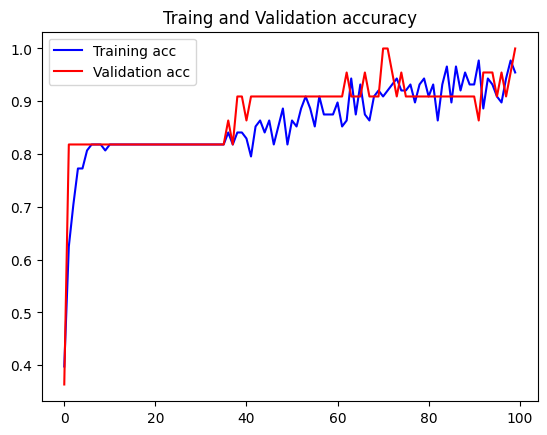

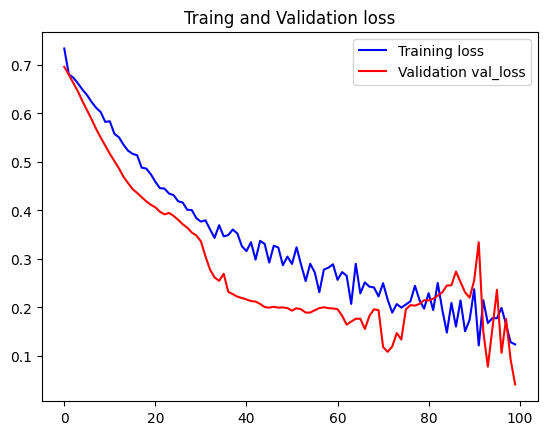

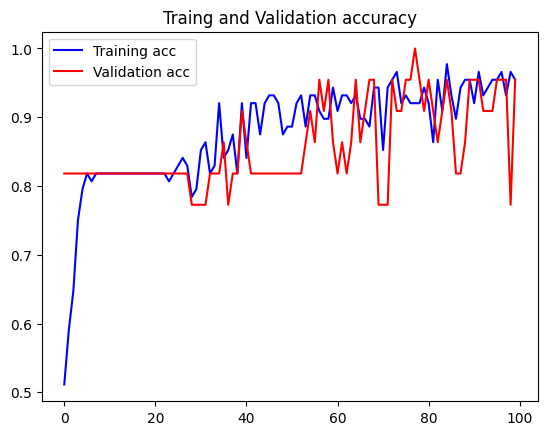

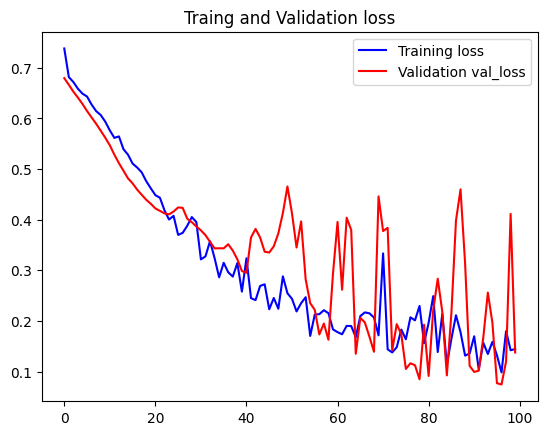

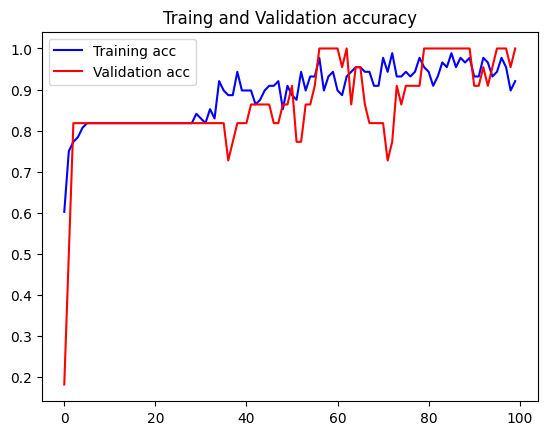

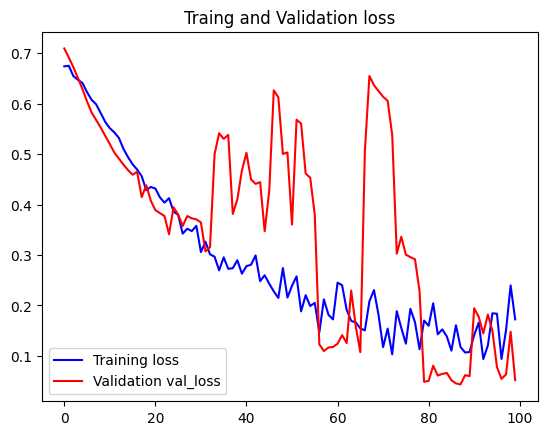

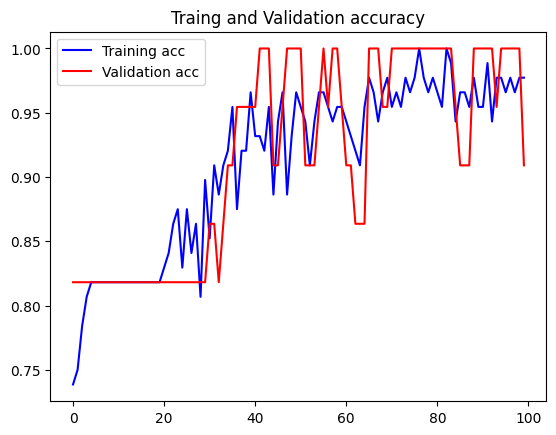

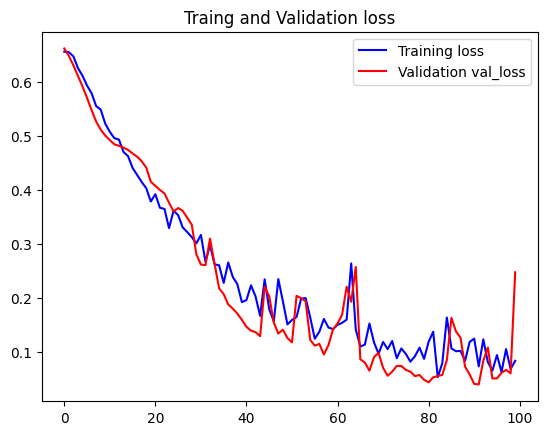

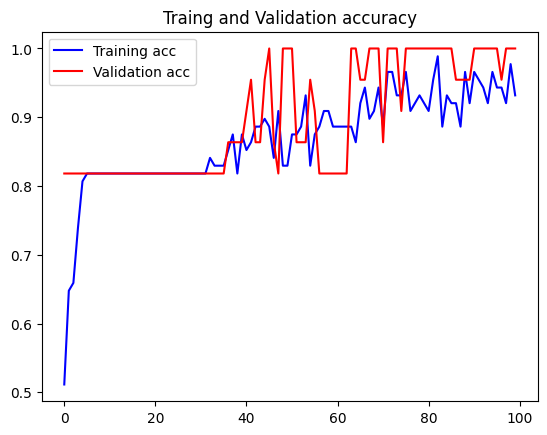

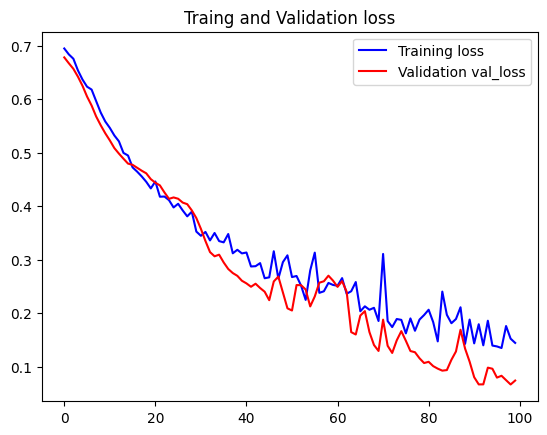

In [ ]:
#@title !!!自采数据集 训练Mid_EEGNet 单模态
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,0].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 2, Chans = 16, Samples = 74, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #compile the model and set the optimizers
  # model = KerasClassifier(build_fn=create_model, verbose=0)

  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # 原模型best 100实际50 新模型 20实际30
  # break;
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

x shape  (110, 16, 74)
y shape  (110,)
[0.06818182021379471, 0.07954545319080353, 0.09090909361839294, 0.13636364042758942, 0.11363636702299118, 0.13636364042758942, 0.15909090638160706, 0.10227272659540176, 0.25, 0.20454545319080353, 0.2954545319080353, 0.25, 0.3295454680919647, 0.28409090638160706, 0.27272728085517883, 0.3068181872367859, 0.3181818127632141, 0.35227271914482117, 0.4545454680919647, 0.35227271914482117, 0.3636363744735718, 0.5, 0.4886363744735718, 0.5113636255264282, 0.5227272510528564, 0.5340909361839294, 0.5340909361839294, 0.5909090638160706, 0.6363636255264282, 0.5909090638160706, 0.5454545617103577, 0.4204545319080353, 0.5568181872367859, 0.5681818127632141, 0.5, 0.5795454382896423, 0.5113636255264282, 0.5909090638160706, 0.46590909361839294, 0.5568181872367859, 0.6931818127632141, 0.625, 0.5454545617103577, 0.5795454382896423, 0.6477272510528564, 0.6136363744735718, 0.5795454382896423, 0.5909090638160706, 0.6136363744735718, 0.5909090638160706, 0.625, 0.63636362

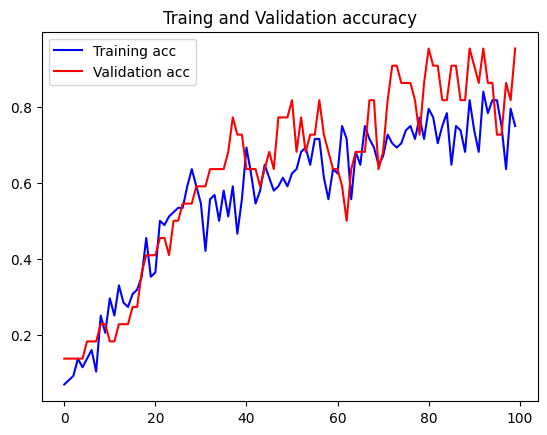

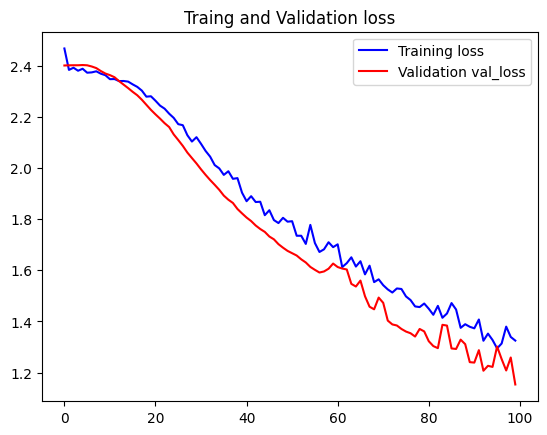

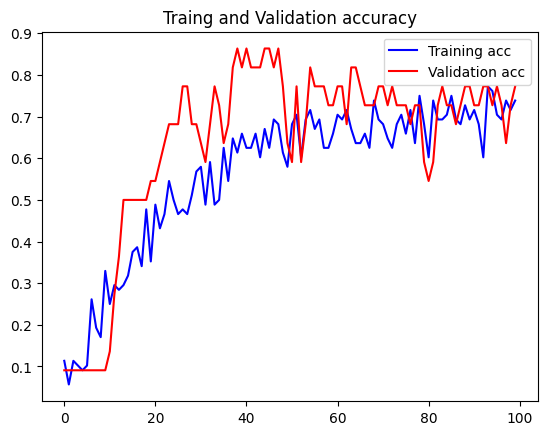

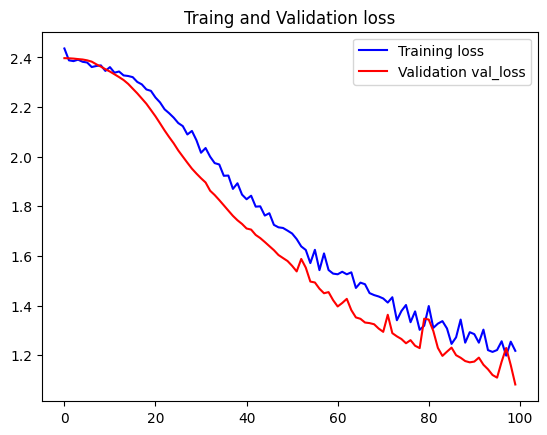

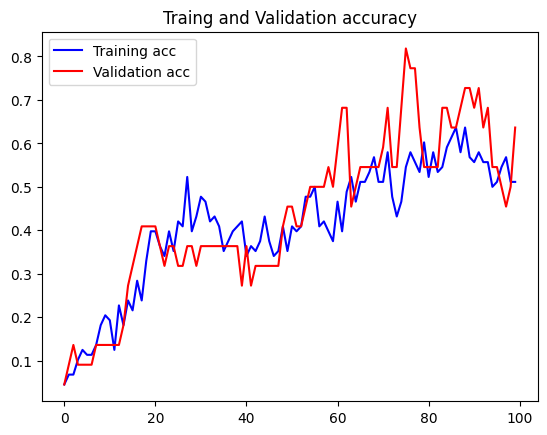

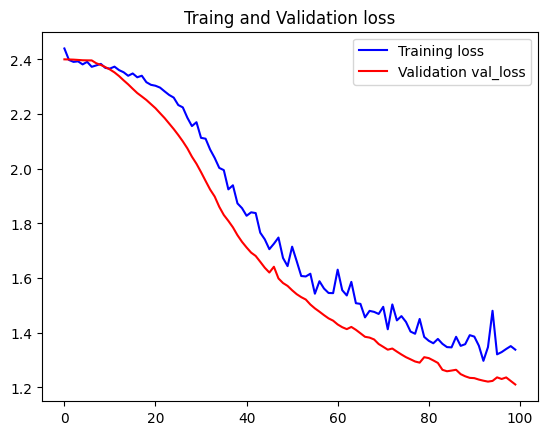

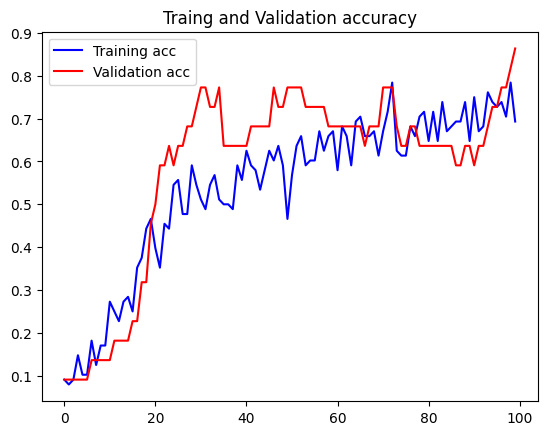

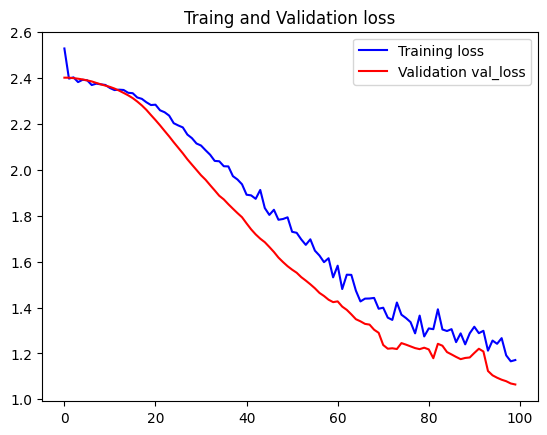

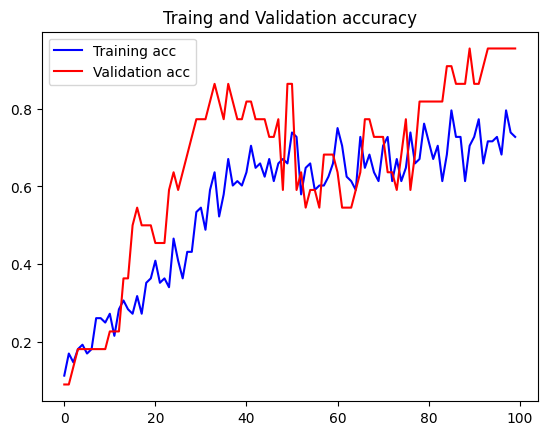

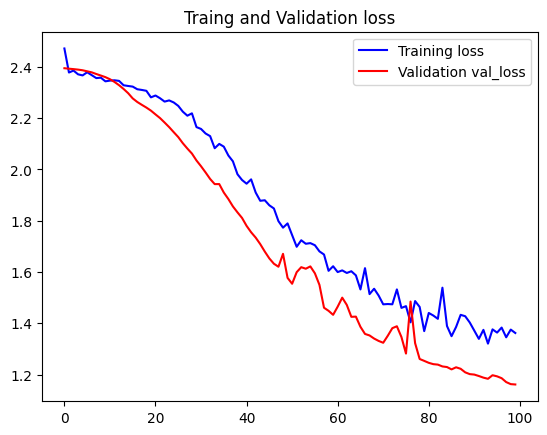

In [ ]:
#@title 自采数据集 训练Mid_EEGNet 序号表示 训练效果差说明并非是记忆了人
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 11
batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
# y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
y = np.arange(0,11)
y = np.repeat(y,10)
# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,0].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
print("y shape ",y.shape)
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 11, Chans = 16, Samples = 74, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #compile the model and set the optimizers
  # model = KerasClassifier(build_fn=create_model, verbose=0)

  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # 原模型best 100实际50 新模型 20实际30
  # break;
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

x shape  (110, 16, 74)
[0.5113636255264282, 0.5909090638160706, 0.7159090638160706, 0.7954545617103577, 0.8295454382896423, 0.8181818127632141, 0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.7954545617103577, 0.8181818127632141, 0.8068181872367859, 0.8181818127632141, 0.8522727489471436, 0.82954543828964

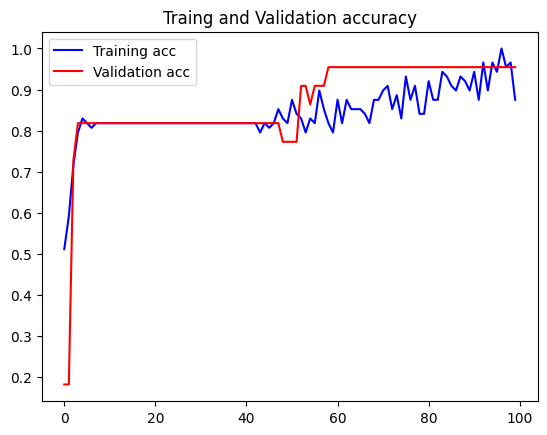

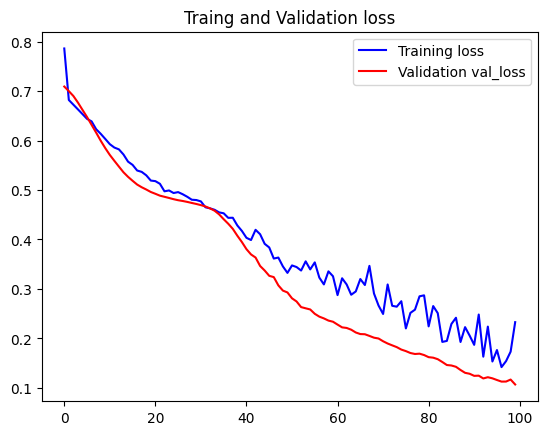

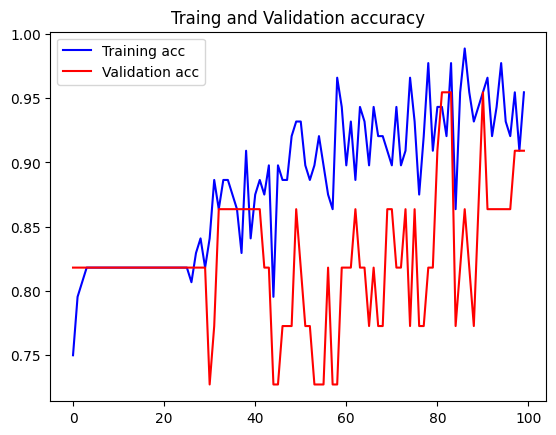

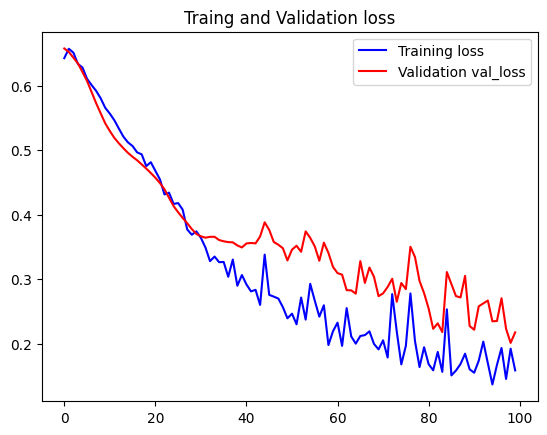

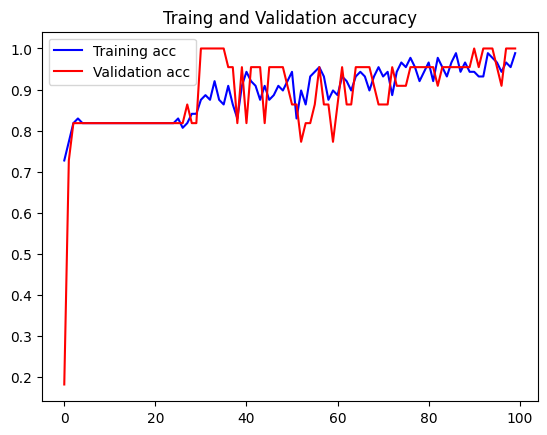

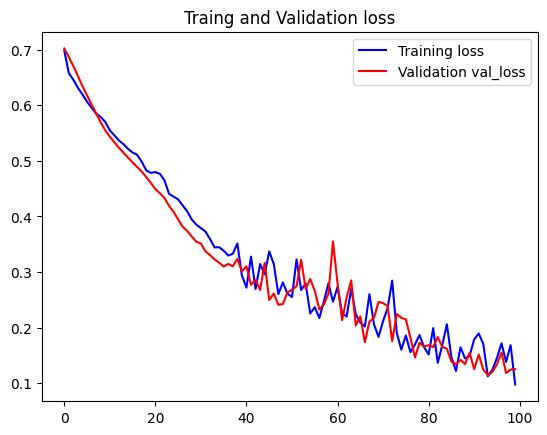

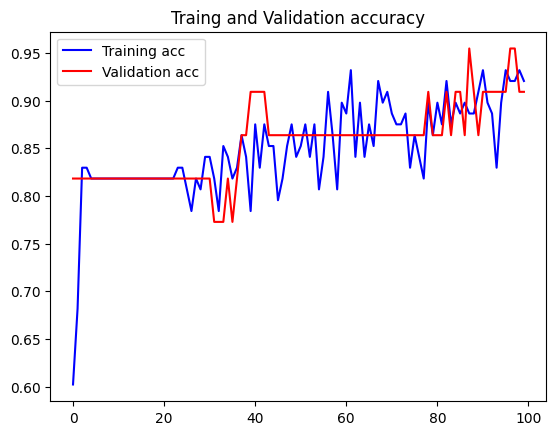

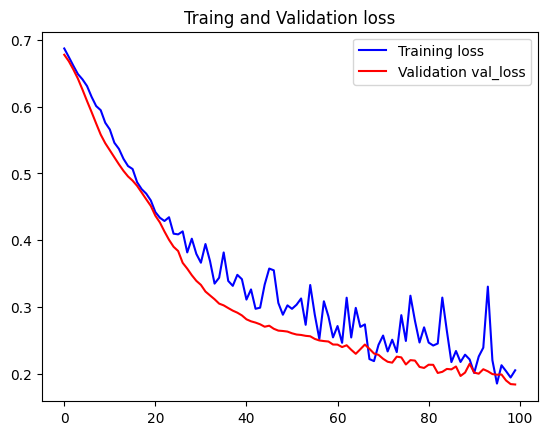

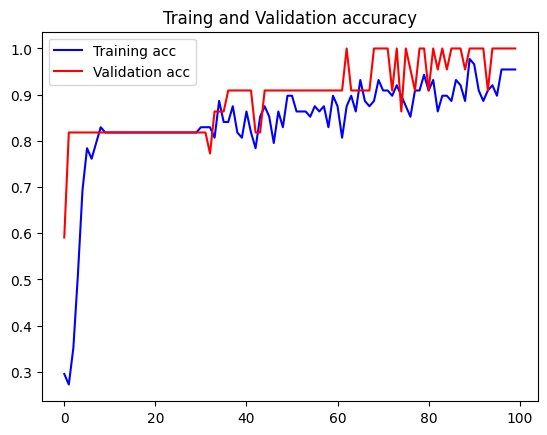

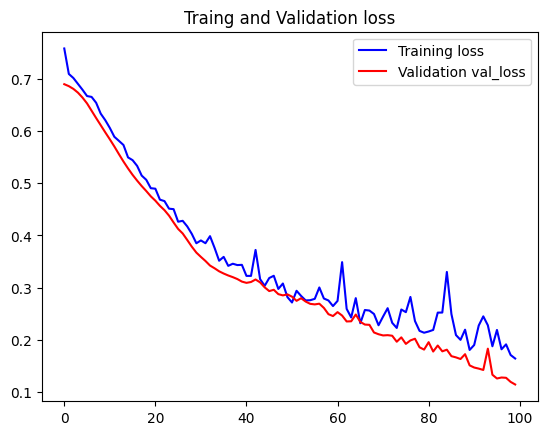

In [ ]:
#@title 自采数据集 训练single_EEGNet 单模态
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,0].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Single_EEGNet(nb_classes = 2, Chans = 16, Samples = 74, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #compile the model and set the optimizers
  # model = KerasClassifier(build_fn=create_model, verbose=0)

  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # 原模型best 100实际50 新模型 20实际30
  # break;
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

x shape  (90, 16, 74)
[0.4722222089767456, 0.7361111044883728, 0.7638888955116272, 0.7638888955116272, 0.7638888955116272, 0.7777777910232544, 0.7777777910232544, 0.7916666865348816, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7777777910232544, 0.7916666865348816, 0.7777777910232544, 0.7916666865348816, 0.7916666865348816, 0.7916666865348816, 0.7777777910232544, 0.75, 0.8194444179534912, 0.7916666865348816, 0.8055555820465088, 0.8611111044883728, 0.7638888955116272, 0.8055555820465088, 0.7916666865348816, 0.8055555820465088, 0.75, 0.8472222089767456, 0.8472222089767456, 0.8194444179534912, 0.8472222089767456, 0.8472222089767456, 0.8611111044883728, 0.8611111044883728, 0.8333333134651184, 0.8611111044883728, 0.8888888955116272, 0.944

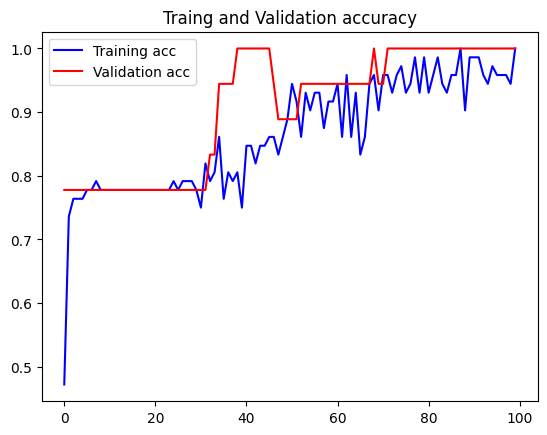

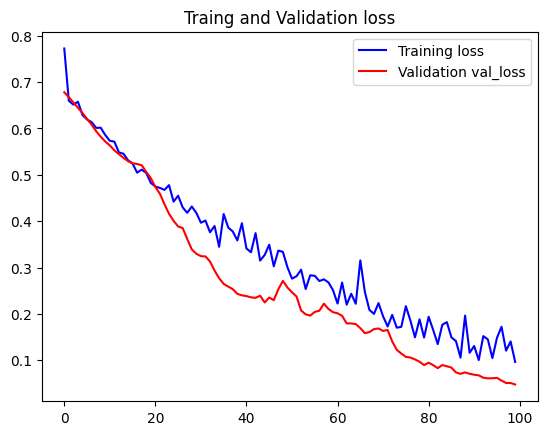

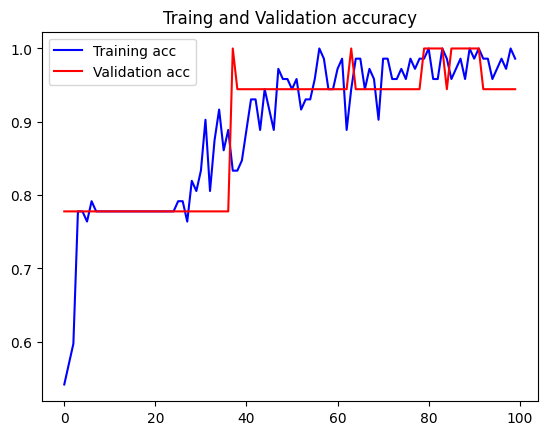

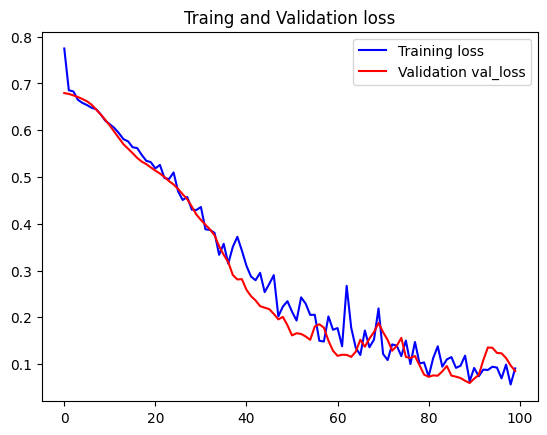

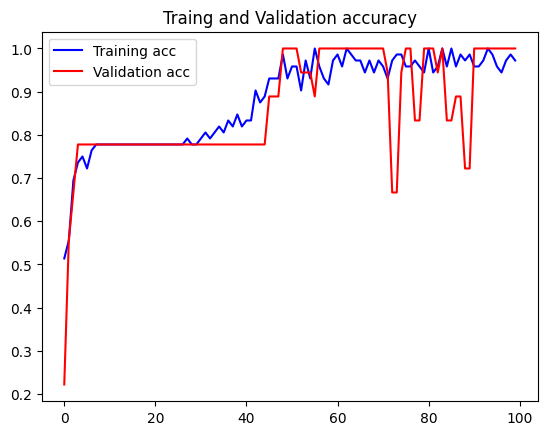

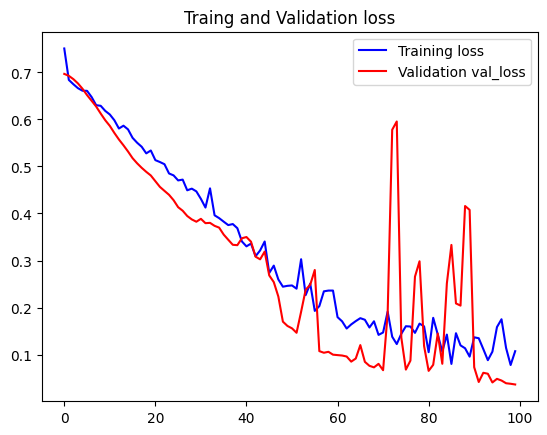

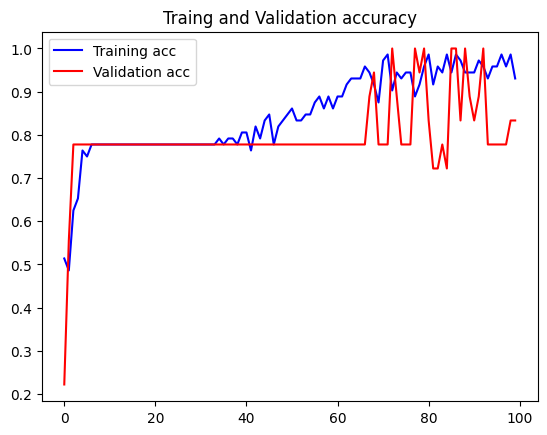

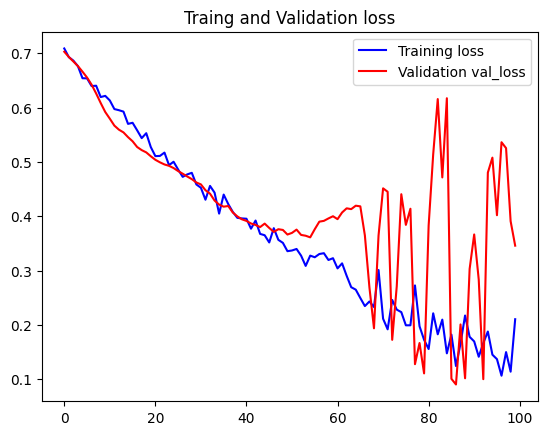

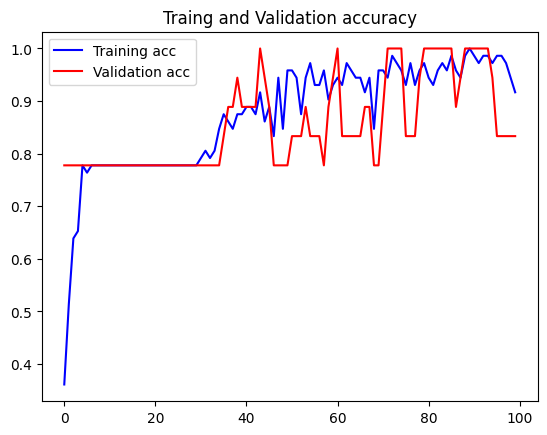

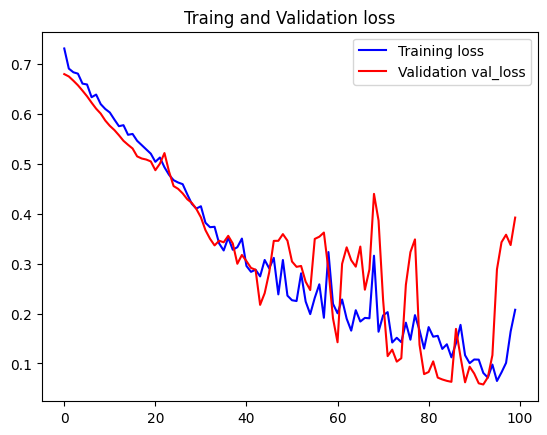

In [ ]:
#@title 自采数据集 情绪图片 对比实验
#@title !!!自采数据集 训练Mid_EEGNet 单模态
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/SE_X_16ch_qingxu.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch_qingxu.npy')
# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,0].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 2, Chans = 16, Samples = 74, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #compile the model and set the optimizers
  # model = KerasClassifier(build_fn=create_model, verbose=0)

  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # 原模型best 100实际50 新模型 20实际30
  # break;
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/qxtp_model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/qxtp_model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc)) 

x shape  (2526, 62, 32)
[0.36039602756500244, 0.35544553399086, 0.3648514747619629, 0.37227723002433777, 0.41386139392852783, 0.4450494945049286, 0.4727722704410553, 0.503960371017456, 0.5207920670509338, 0.5425742864608765, 0.5737623572349548, 0.592079222202301, 0.6158415675163269, 0.6336633563041687, 0.646039605140686, 0.6603960394859314, 0.6747524738311768, 0.6638613939285278, 0.6861386299133301, 0.6851485371589661, 0.6935643553733826, 0.7123762369155884, 0.6995049715042114, 0.7103960514068604, 0.7242574095726013, 0.7306930422782898, 0.7381188273429871, 0.7356435656547546, 0.7425742745399475, 0.7445544600486755, 0.7400990128517151, 0.7579208016395569, 0.7410891056060791, 0.7663366198539734, 0.7673267126083374, 0.7613861560821533, 0.7599009871482849, 0.7811881303787231, 0.7712871432304382, 0.7663366198539734, 0.7668316960334778, 0.7737624049186707, 0.763861358165741, 0.7732673287391663, 0.7772276997566223, 0.7643564343452454, 0.7712871432304382, 0.7737624049186707, 0.7821782231330872

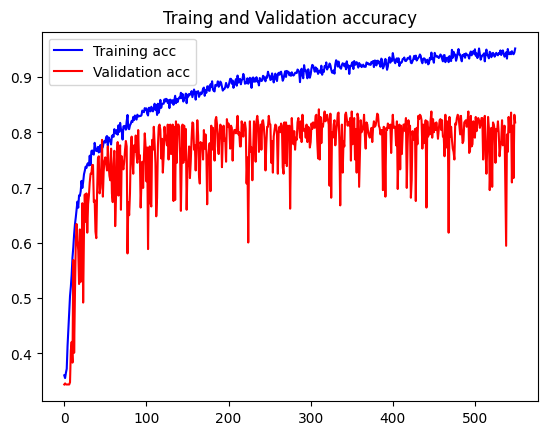

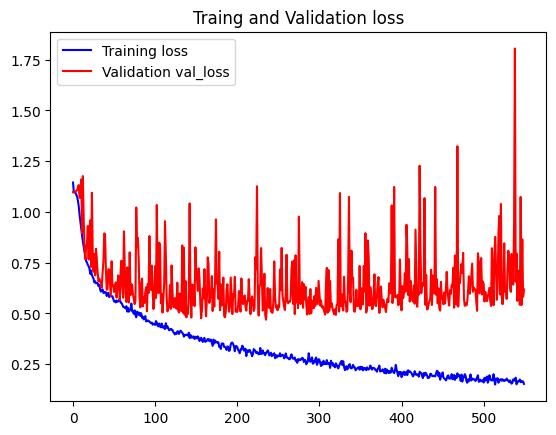

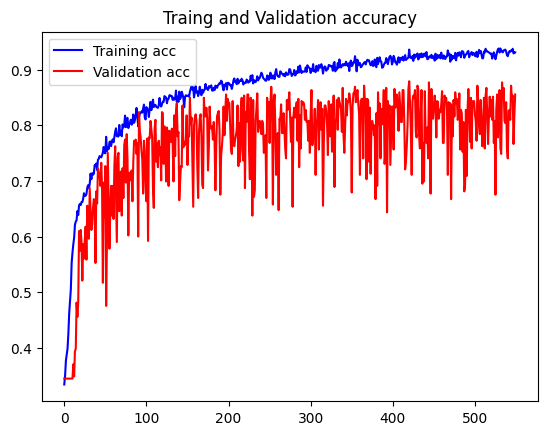

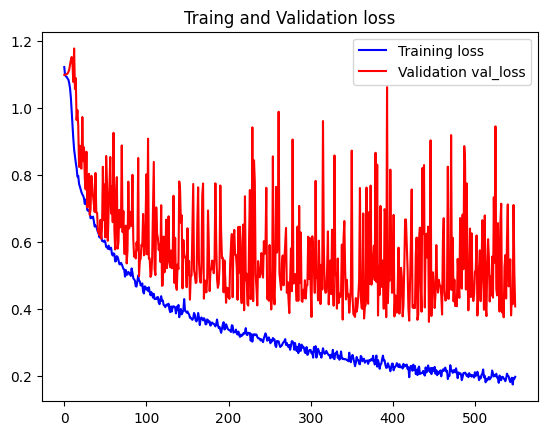

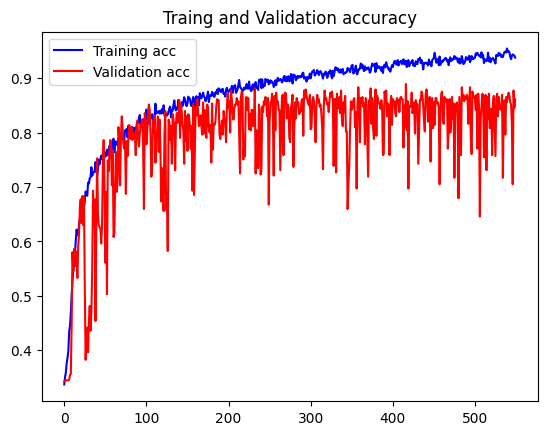

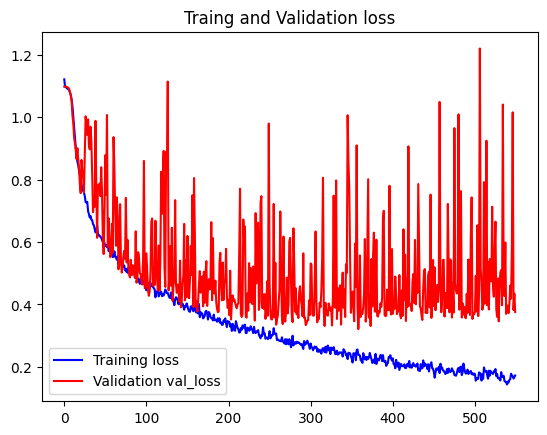

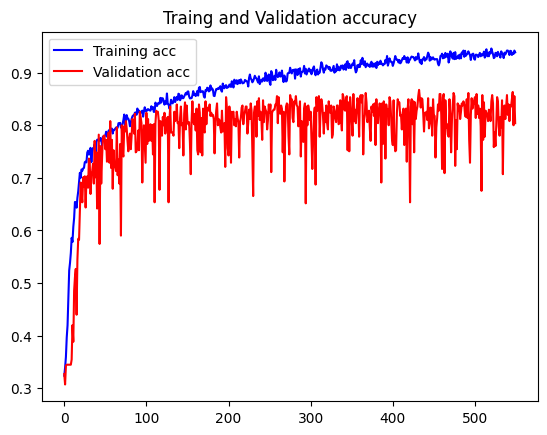

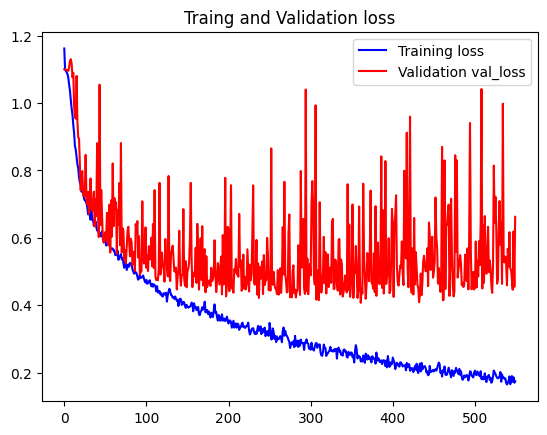

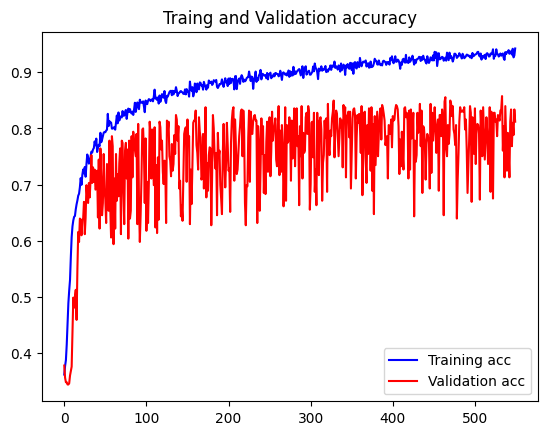

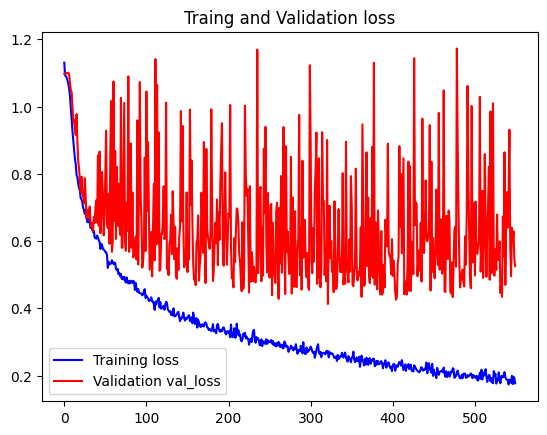

In [ ]:
#@title SEED 训练Mid_EEGNet 4s
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 3
batch_size = 128
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/t8x_seed.npy')
y = np.load('/content/drive/MyDrive/t8y_seed.npy')
x = x.reshape(-1,8,62,5)
x = x[:,:,:,0:4]
x = x.transpose(0,3,1,2)
x = x.reshape(-1,32,62).transpose(0,2,1)
print("x shape ",x.shape)
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 3, Chans = 62, Samples = 32, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0007, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  model = create_model(20)
  p= p+1
  history = model.fit(x_train, y_train, epochs=550, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

(5076, 3)
(5076, 72, 16)
[0.33990147709846497, 0.34014779329299927, 0.3724137842655182, 0.39408865571022034, 0.4219211935997009, 0.4610837399959564, 0.5108374357223511, 0.5497536659240723, 0.5620689392089844, 0.5793103575706482, 0.5837438702583313, 0.5871921181678772, 0.5982758402824402, 0.5842364430427551, 0.5916256308555603, 0.5852216482162476, 0.5869458317756653, 0.5921182036399841, 0.5918719172477722, 0.5955665111541748, 0.6002463102340698, 0.6041871905326843, 0.6024630665779114, 0.6083743572235107, 0.629802942276001, 0.6322659850120544, 0.624876856803894, 0.6413792967796326, 0.6507388949394226, 0.6472906470298767, 0.6477832794189453, 0.6546797752380371, 0.6583743691444397, 0.6593596339225769, 0.6642857193946838, 0.6660098433494568, 0.6610837578773499, 0.6571428775787354, 0.6544334888458252, 0.6576354503631592, 0.6578817963600159, 0.6625615954399109, 0.6605911254882812, 0.6605911254882812, 0.6726601123809814, 0.6628078818321228, 0.6677339673042297, 0.6628078818321228, 0.66453200578

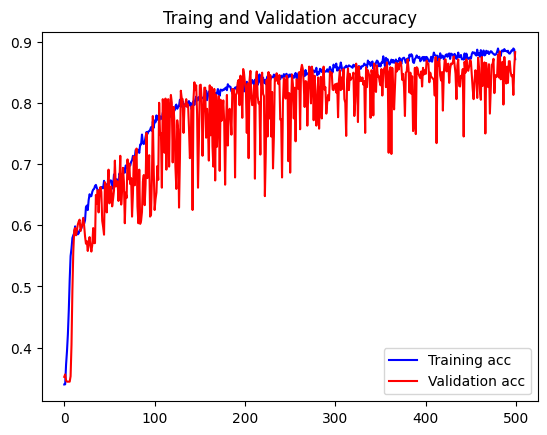

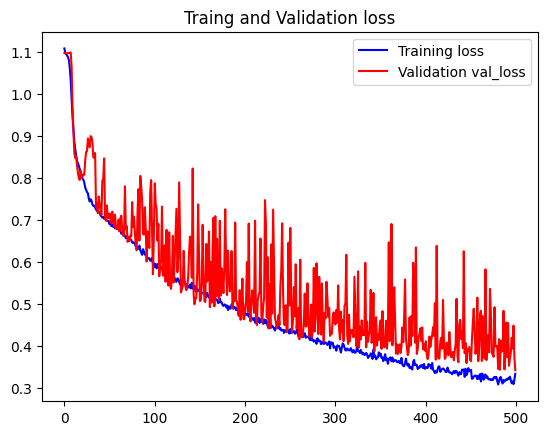

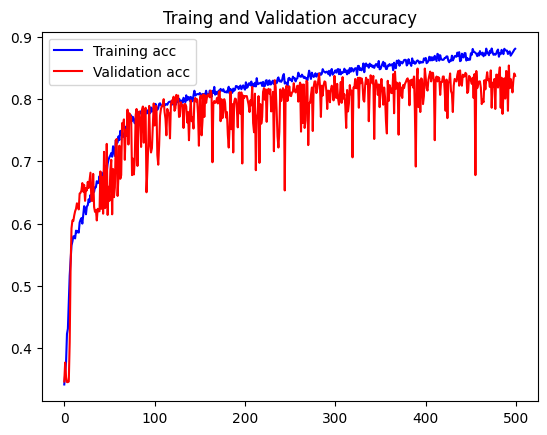

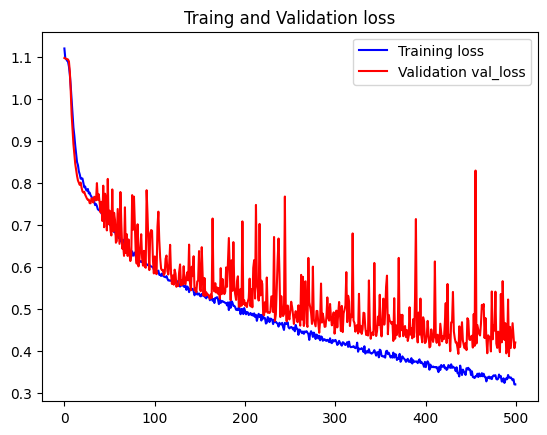

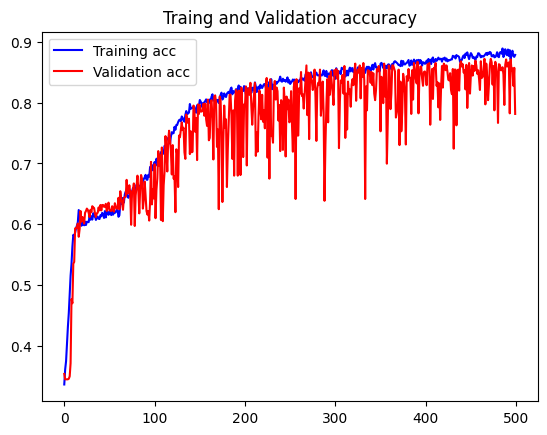

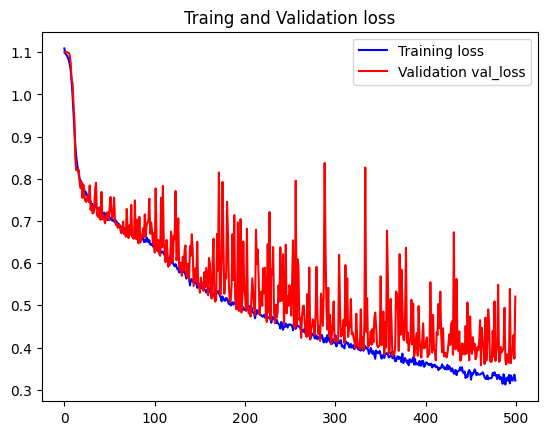

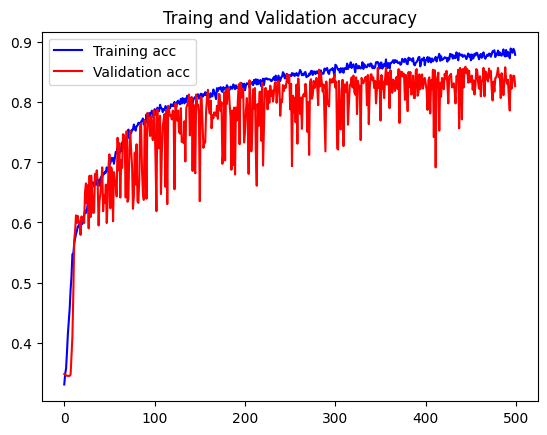

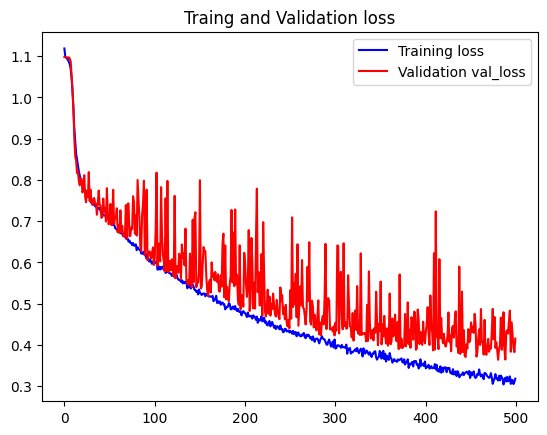

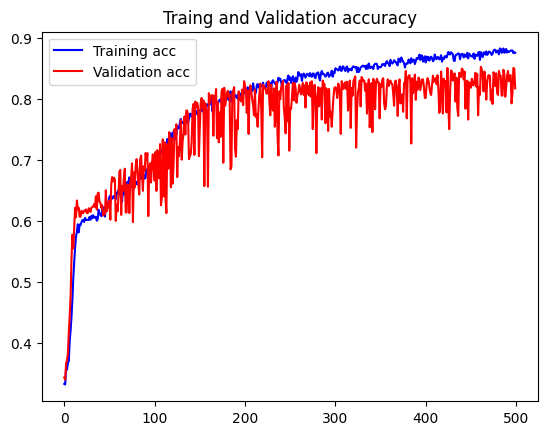

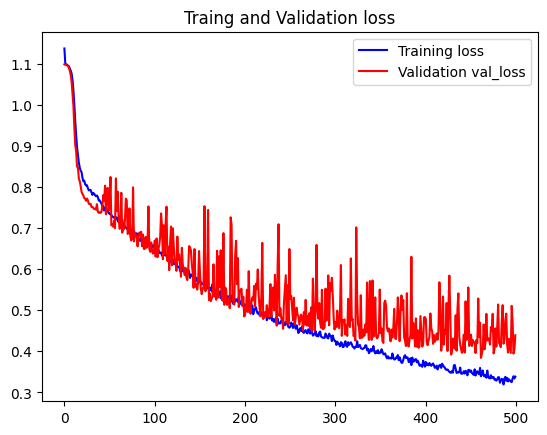

In [ ]:
#@title SEED 训练Mid_EEGNet 2s
import tensorflow as tf
import numpy as np
import time
import keras
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout,Bidirectional
from keras.layers import Flatten, Dense, Concatenate, Reshape, LSTM
from keras.models import Sequential, Model


from keras import backend as K
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

num_classes = 3
batch_size = 128
img_rows, img_cols, num_chan = 8, 9, 4

img_size = (img_rows, img_cols, num_chan)


falx = np.load('/content/drive/MyDrive/t4x_89.npy')
y = np.load('/content/drive/MyDrive/t4y_89.npy')
# one_y = np.array([y[:1697]] * 3).reshape((-1,))
# one_y = to_categorical(one_y, num_classes)
one_y_1 = np.array([y[:1692]] * 3).reshape((-1,))
one_y_1 = to_categorical(one_y_1, num_classes)

cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0

def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 3, Chans = 72, Samples = 16, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for nb in range(1):
    K.clear_session()
    start = time.time()
    one_falx_1 = falx[nb * 3:nb * 3 + 3]
    one_falx_1 = one_falx_1.reshape((-1, 4, img_rows, img_cols, 5))

    one_y = one_y_1
    one_falx = one_falx_1[:,:,:,:,1:5]
    one_falx = one_falx.transpose((0,1,4,2,3))
    one_falx = one_falx.reshape(-1,16,72)
    one_falx = one_falx.transpose((0,2,1))
    print(one_y.shape)
    print(one_falx.shape)
    x = one_falx
    y = one_y

    seed = 7
    np.random.seed(seed)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cvscores = []


   
    for train, test in kfold.split(x, y.argmax(1)):
        img_size = (16,72)
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        model = create_model(6)
        p= p+1
        history = model.fit(x_train, y_train, epochs=500, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
        epochs = range(len(history.history['accuracy']))
        plt.figure()
        plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
        plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
        plt.title('Traing and Validation accuracy')
        plt.legend()
        plt.savefig('/content/drive/MyDrive/eegnet_seed_model_V3.'+str(p)+'_acc.jpg')

        plt.figure()
        plt.plot(epochs,history.history['loss'],'b',label='Training loss')
        plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
        plt.title('Traing and Validation loss')
        plt.legend()
        plt.savefig('/content/drive/MyDrive/eegnet_seed_model_V3.'+str(p)+'_loss.jpg')
        
        print(history.history['accuracy'])
        print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
        max_acc.append(max(history.history['val_accuracy']))
        print(history.history['val_accuracy'])
        scores = history.history['val_accuracy'][-1]
        # scores = model.evaluate(x_test, y_test, verbose=0)

        print("%.2f" % (scores)) # Accuracy
        all_acc.append(scores)

    print("mean acc: {}".format(np.mean(all_acc)))
    print("std acc: {}".format(np.std(all_acc)))
    acc_list.append(np.mean(all_acc))
    std_list.append(np.std(all_acc))
    print("进度： {}".format(nb))
    all_acc = []
    end = time.time()
    print("%.2f" % (end - start))   # run time
print('Acc_all: {}'.format(acc_list))
print('Std_all: {}'.format(std_list))
print("Acc_mean: {}".format(np.mean(acc_list)))
print("Std_all: {}".format(np.std(std_list)))


In [ ]:
#@title seed 特征提取 
from keras.layers import Dense, Concatenate,Reshape
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.regularizers import l2
from sklearn import svm

def left_EEGNet(nb_classes = 3, Chans = 72, Samples = 16,dropoutRate = 0.5, kernLength = 6, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples,1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  # block2   = Flatten(name = 'flatten1')(block2)
  block2  = Reshape((-1, 32))(block2)
  block2   = tf.squeeze(block2,[1])
  return Model(inputs=sequence_input,outputs=block2)



def right_EEGNet(nb_classes = 3, Chans = 72, Samples = 16,dropoutRate = 0.5, kernLength = 6, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples,1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')
      
  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  # block4   = Flatten(name = 'flatten2')(block4) 
  block4  = Reshape((-1, 32))(block4)
  block4   = tf.squeeze(block4,[1])
  return Model(inputs=sequence_input,outputs=block4)
  
def svm_classify(x_train,y_train,x_test,y_test,C):
    print('training SVM...')
    clf = svm.SVC(C=C)
    clf.fit(x_train,y_train)
    accuracy = clf.score(x_test, y_test)
    print("Model accuracy:", accuracy)

    return accuracy

(5076,)
after x shape  (5076, 72, 16)
float64
(None, 32, 32)
[0.33078816533088684, 0.346059113740921, 0.34458127617836, 0.34408867359161377, 0.34704434871673584, 0.3455665111541748, 0.3453201949596405, 0.3458127975463867, 0.3453201949596405, 0.3453201949596405, 0.34359607100486755, 0.34334975481033325, 0.34408867359161377, 0.3455665111541748, 0.3458127975463867, 0.34334975481033325, 0.34359607100486755, 0.34655171632766724, 0.3421182334423065, 0.34285715222358704, 0.3497537076473236, 0.3453201949596405, 0.34458127617836, 0.3450738787651062, 0.3463054299354553, 0.3490147888660431, 0.34433498978614807, 0.34655171632766724, 0.35467979311943054, 0.34704434871673584, 0.3495073914527893, 0.34802955389022827, 0.34458127617836, 0.35443350672721863, 0.3527093529701233, 0.3519704341888428, 0.3463054299354553, 0.35517242550849915, 0.3487684726715088, 0.34729063510894775, 0.35492610931396484, 0.3532019555568695, 0.3536945879459381, 0.35073891282081604, 0.36699506640434265, 0.35394087433815, 0.3536

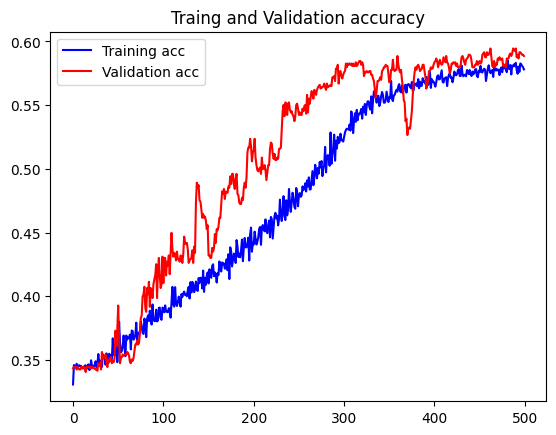

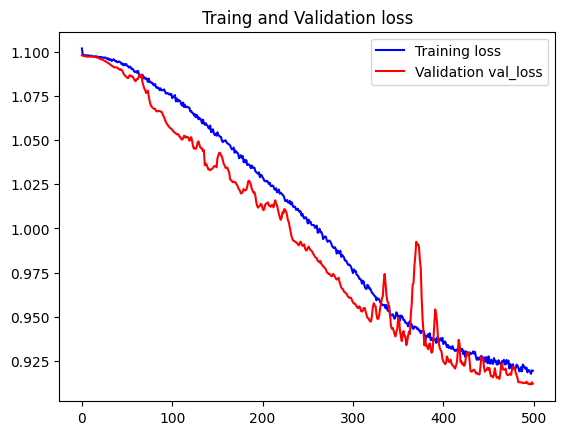

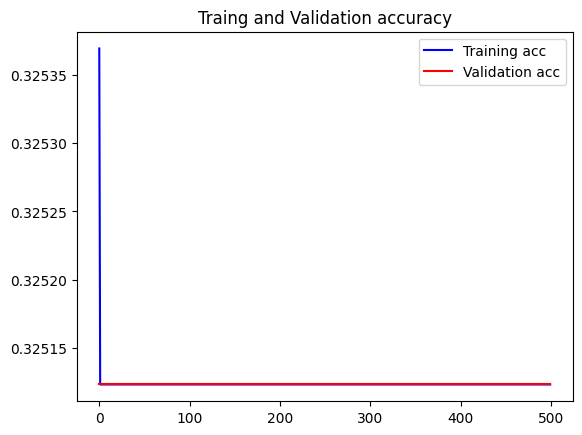

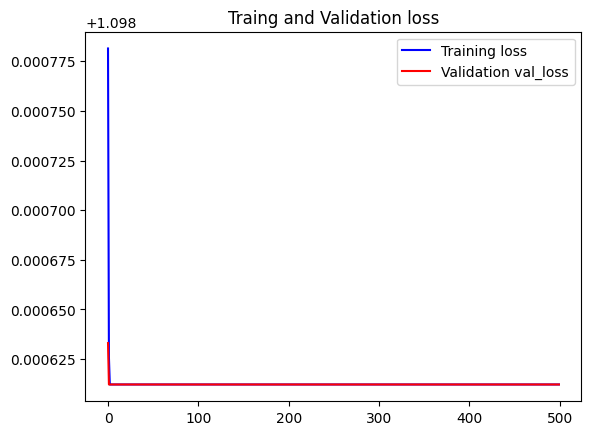

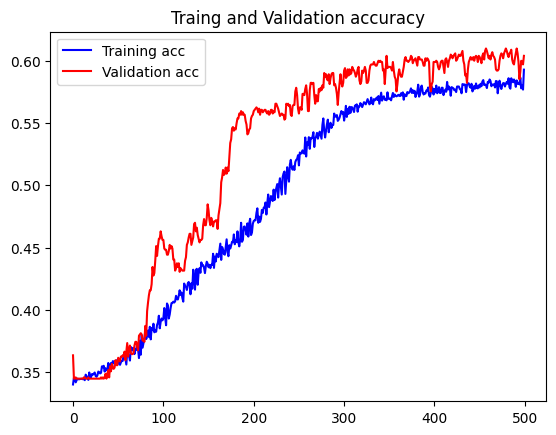

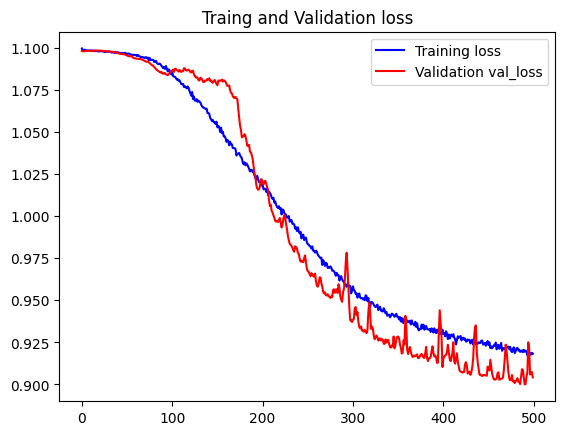

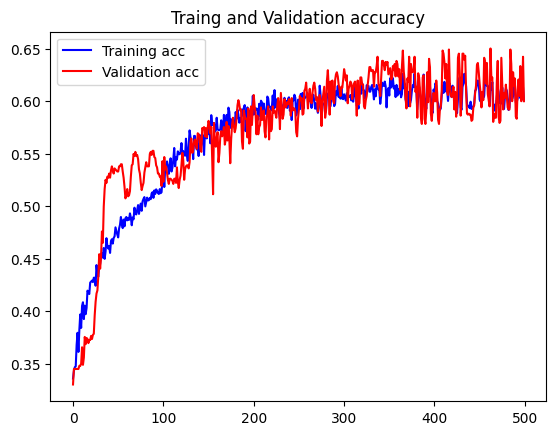

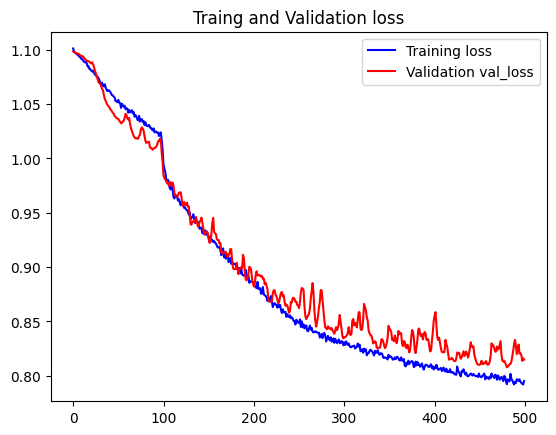

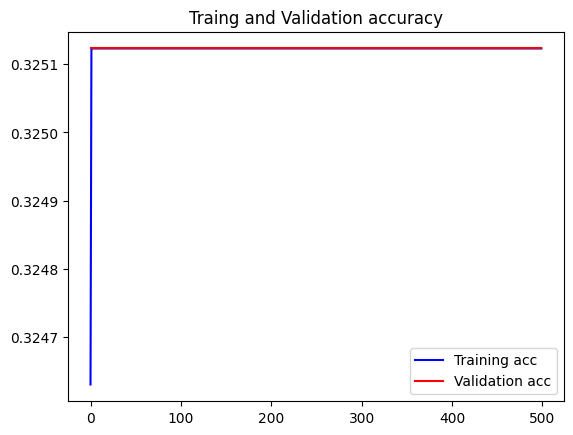

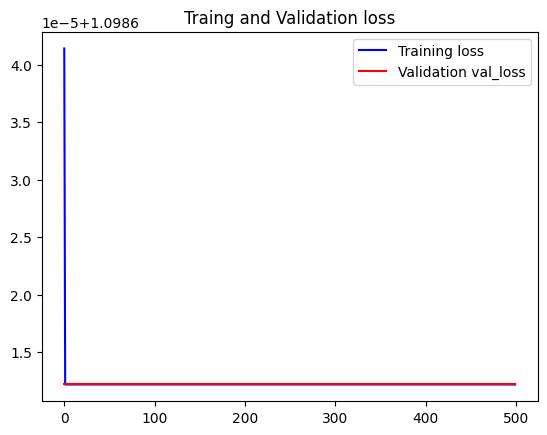

In [ ]:
#@title seed 对比
#@title 多模态 DCCA cca_loss函数
from keras import backend as K
import tensorflow as tf

class cca_loss():
    def __init__(self, outdim_size, use_all_singular_values):
        self.outdim_size = outdim_size
        self.use_all_singular_values = use_all_singular_values

    def loss(self, y_true, y_pred):
        r1 = 1e-3
        r2 = 1e-3
        eps = 1e-9
        print('y_pred shape',y_pred.shape)
        o1 = o2 = y_pred.shape[1]//2

        # unpack (separate) the output of networks for view 1 and view 2
        H1 = y_pred[:, 0:o1]
        H2 = y_pred[:, o1:o1+o2]

        H1, H2 = tf.transpose(H1), tf.transpose(H2)
        o1 = o2 = K.int_shape(H1)[0]

        m = K.int_shape(H1)[1]

        H1bar = H1 - tf.expand_dims(tf.reduce_mean(H1, axis=1), axis=1)
        H2bar = H2 - tf.expand_dims(tf.reduce_mean(H2, axis=1), axis=1)

        SigmaHat12 = (1.0 / (m - 1)) * tf.matmul(H1bar, tf.transpose(H2bar))
        SigmaHat11 = (1.0 / (m - 1)) * tf.matmul(H1bar, tf.transpose(H1bar)) + r1 * tf.eye(o1)
        SigmaHat22 = (1.0 / (m - 1)) * tf.matmul(H2bar, tf.transpose(H2bar)) + r2 * tf.eye(o2)
        # 计算特征值及特征向量
        # Calculating the root inverse of covariance matrices by using eigen decomposition
        [D1, V1] = tf.linalg.eigh(SigmaHat11)
        [D2, V2] = tf.linalg.eigh(SigmaHat22)

        # Added to increase stability posInd1为特征值大于eps的位置
        posInd1 = tf.squeeze(tf.where(tf.greater(D1, eps)), axis=1)
        D1 = tf.gather(D1, posInd1)
        V1 = tf.gather(V1, posInd1, axis=1)
        posInd2 = tf.squeeze(tf.where(tf.greater(D2, eps)), axis=1)
        D2 = tf.gather(D2, posInd2)
        V2 = tf.gather(V2, posInd2, axis=1)

        SigmaHat11RootInv = tf.matmul(tf.matmul(V1, tf.linalg.diag(D1 ** -0.5)), tf.transpose(V1))
        SigmaHat22RootInv = tf.matmul(tf.matmul(V2, tf.linalg.diag(D2 ** -0.5)), tf.transpose(V2))

        Tval = tf.matmul(tf.matmul(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)

        if self.use_all_singular_values:
            # all singular values are used to calculate the correlation
            tmp = tf.matmul(tf.transpose(Tval), Tval)
            corr = tf.trace(tf.sqrt(tmp))
            # assert tf.math.is_nan(corr).numpy() == 0
        else:
            # just the top self.outdim_size singular values are used
            trace_TT = tf.matmul(tf.transpose(Tval), Tval)
            trace_TT = trace_TT + r1 * tf.eye(K.int_shape(trace_TT)[0])
            U, V = tf.linalg.eigh(trace_TT)
            U = tf.where(tf.greater(U, eps), U, tf.ones_like(U) * eps)
            U = tf.math.top_k(U, k=self.outdim_size)[0]
            corr = tf.reduce_sum(tf.sqrt(U))
        return -corr

from keras.layers import Dense, Concatenate
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.regularizers import l2
from sklearn import svm


def svm_classify(x_train,y_train,x_test,y_test,C):
    """
    trains a linear SVM on the data
    input C specifies the penalty factor of SVM
    """
    print('training SVM...')
    clf = svm.SVC(C=C)
    clf.fit(x_train,y_train)
    accuracy = clf.score(x_test, y_test)
    print("Model accuracy:", accuracy)

    return accuracy
#@title 多模态 特征提取及训练,并使用svm分类
import numpy as np
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.layers import Lambda, Input, Dense
import keras.backend as K

# 定义双线性池化函数
def bilinear_pooling(x):
    # x[0]和x[1]分别代表两个输入的特征图
    # 下面的代码实现了双线性池化的公式
    out = K.batch_dot(K.reshape(x[0], (-1, 1, K.int_shape(x[0])[1])),
                      K.reshape(x[1], (-1, 1,K.int_shape(x[1])[1])),
                      axes=[1, 1])
    out = K.sqrt(K.abs(out) + 1e-10)
    out = K.l2_normalize(out, axis=-1)
    return out

def dcca_multi_modal(nb_classes = 3,Chans = 72, Samples = 16, dropoutRate = 0.5, kernLength = 30, F1 = 8,D = 2,F2 = 16,norm_rate = 0.25,dropoutType = 'Dropout'):
    sequence_input = Input(shape=(Chans, Samples, 1))
    sequence_input1 = Input(shape=(Chans, Samples, 1))
    model1 = left_EEGNet(nb_classes,Chans,Samples,dropoutRate,kernLength,F1,D,F2,norm_rate,dropoutType)(sequence_input)
    model2 = right_EEGNet(nb_classes,Chans,Samples,dropoutRate,kernLength,F1,D,F2,norm_rate,dropoutType)(sequence_input1)
    bilinear_layer = Lambda(bilinear_pooling)
    out = bilinear_layer([model1,model2])
    print(out.shape)
    out = Flatten()(out)
    out   = Dense(nb_classes, name = 'dense', activation='relu',
                         kernel_constraint = max_norm(norm_rate))(out)
    out  = Activation('softmax', name = 'softmax')(out)
    return Model(inputs=[sequence_input, sequence_input1], outputs=out)

def train_model(x_train,y_train,pic_train,x_test,y_test,pic_test,epoch_num,batch_size,nb_classes,Chans,Samples,kernLength):
    """
    trains the model
    # Arguments
        data1 and data2: the train, validation, and test data for view 1 and view 2 respectively. data should be packed
        like ((X for train, Y for train), (X for validation, Y for validation), (X for test, Y for test))
        epoch_num: number of epochs to train the model
        batch_size: the size of batches
    # Returns
        the trained model
    """
    model = dcca_multi_modal(nb_classes = nb_classes,Chans = Chans,Samples = Samples,kernLength = kernLength)
    model_optimizer = Adam(learning_rate=1, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
    model.compile(loss=cca_loss(3, False).loss, optimizer=model_optimizer)
  
    model.fit([x_train, pic_train], np.zeros(len(x_train)),
              batch_size=batch_size, epochs=epoch_num)

    return model


def test_model(model,x_train,y_train,pic_train,x_test,y_test,pic_test):
    """produce the new features by using the trained model
    # Arguments
        model: the trained model
        data1 and data2: the train, validation, and test data for view 1 and view 2 respectively.
            Data should be packed like
            ((X for train, Y for train), (X for validation, Y for validation), (X for test, Y for test))
        outdim_size: dimension of new features
        apply_linear_cca: if to apply linear CCA on the new features
    # Returns
        new features packed like
            ((new X for train - view 1, new X for train - view 2, Y for train),
            (new X for validation - view 1, new X for validation - view 2, Y for validation),
            (new X for test - view 1, new X for test - view 2, Y for test))
    """
    new_data = []
    train = model.predict([x_train,pic_train])
    print('shape after test model ',train.shape)
    test = model.predict([x_test,pic_test])
    return train,test


num_classes = 3
batch_size = 53
img_rows, img_cols, num_chan = 8, 9, 4

x = np.load('/content/drive/MyDrive/t4x_89.npy')
ano = np.load('/content/drive/MyDrive/t4x_89.npy')
y = np.load('/content/drive/MyDrive/t4y_89.npy')
print(y.shape)

x = x[0:3]
x = x.reshape((-1, 4, img_rows, img_cols, 5))
x = x[:,:,:,:,1:5]
x = x.transpose((0,1,4,2,3))
x = x.reshape(-1,16,72)
x = x.transpose((0,2,1))  
  
print("after x shape ",x.shape)
print(x.dtype)
pics = ano[0:3]
pics = pics.reshape((-1, 4, img_rows, img_cols, 5))
pics = pics[:,:,:,:,1:5]
pics = pics.transpose((0,1,4,2,3))
pics = pics.reshape(-1,16,72)
pics = pics.transpose((0,2,1)) 

all_acc = []
max_acc = []
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
p = 0
y = to_categorical(y, num_classes)

for train, test in kfold.split(x, y.argmax(1)):
  if len(train) != 4060:
    if len(train) > 4060:
      train = train[:4060]
  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model = dcca_multi_modal(nb_classes = 3,Chans = 72,Samples = 16,kernLength = 8)
  model_optimizer = Adam(learning_rate=7e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.03)
  model.compile(loss='categorical_crossentropy',optimizer=model_optimizer, 
              metrics = ['accuracy'])

  # model = train_model(x_train,y_train,pic_train,x_test,y_test,pic_test,epoch_num=100,batch_size=406,nb_classes = 3,
  #                     Chans = 72,Samples = 16,kernLength = 8)
  # train,test = test_model(model,x_train,y_train,pic_train,x_test,y_test,pic_test)
  # acc = svm_classify(train,y_train,test,y_test,C=1)
  # print("%.2f" % (acc*100)) 
  # all_acc.append(acc)

  history = model.fit([x_train,pic_train], y_train, epochs=500, batch_size=406, verbose=0,validation_data = ([x_test,pic_test],y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("std max acc: {}".format(np.std(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

x shape  (110, 16, 74)
[0.7727272510528564, 0.7954545617103577, 0.8181818127632141, 0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8068181872367859, 0.8636363744735718, 0.875, 0.8295454382896423, 0.8977272510528564, 0.9204545617103577, 0.9090909361839294, 0.9318181872367859, 0.9318181872367859, 0.9090909361839294, 0.8977272510528564, 0.9431818127632141, 0.9431818127632141, 0.9659090638160706, 0.9204545617103577, 0.9090909361839294, 0.9090909361839294, 0.9090909361839294, 0.8863636255264282, 0.9318181

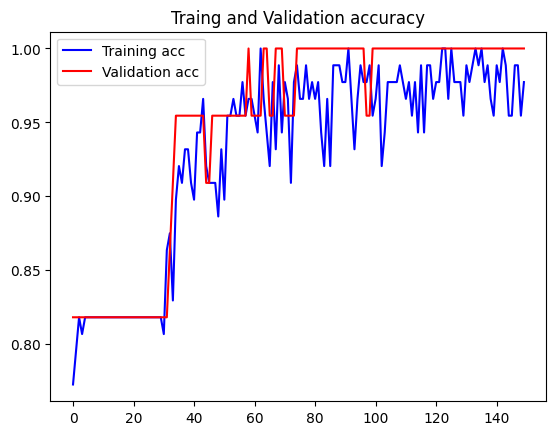

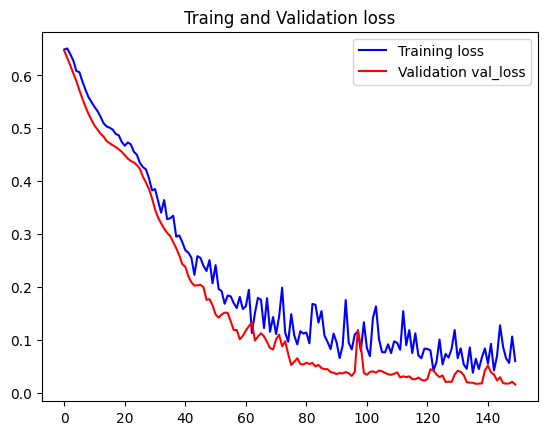

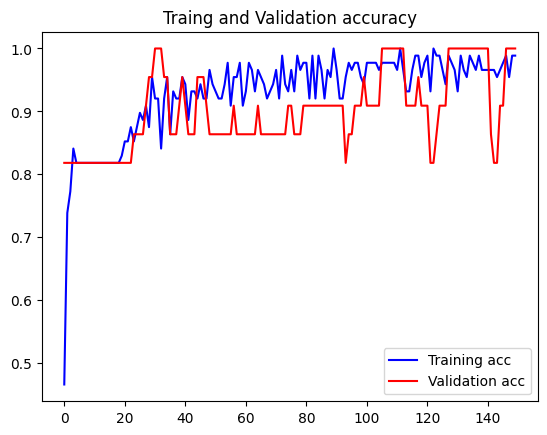

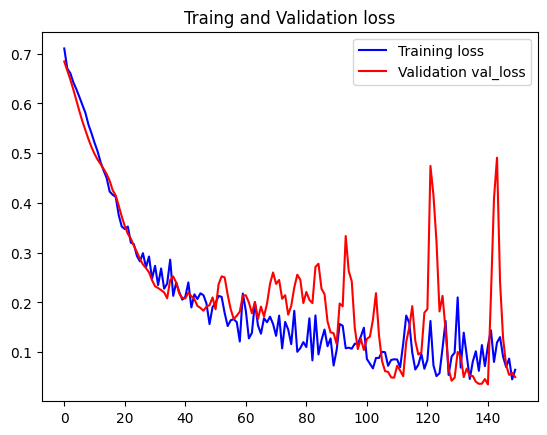

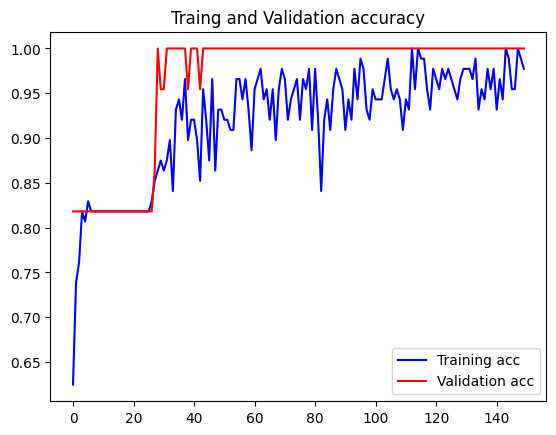

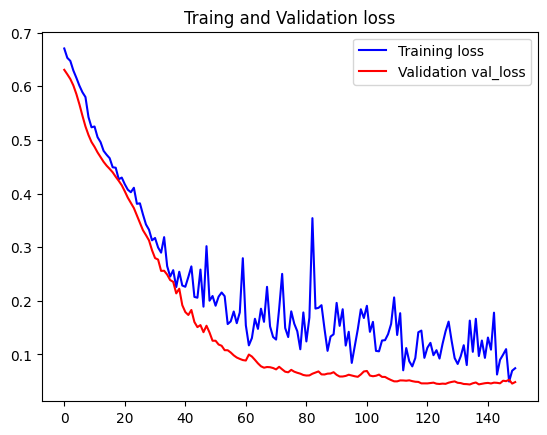

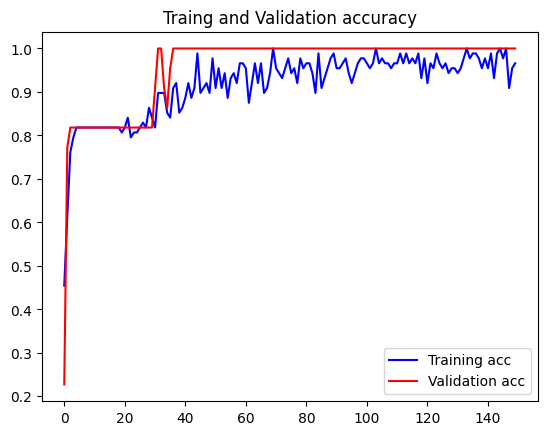

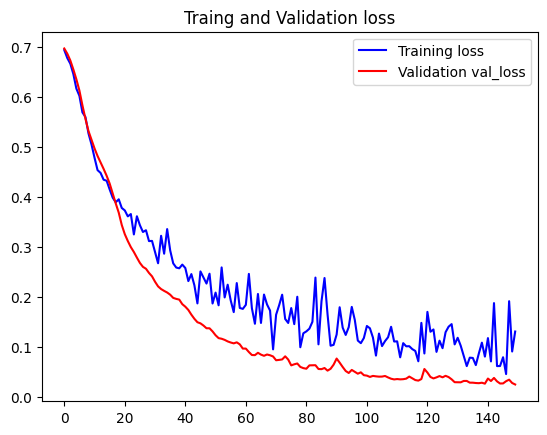

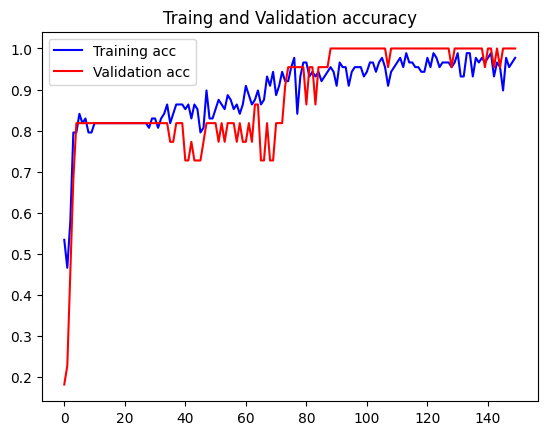

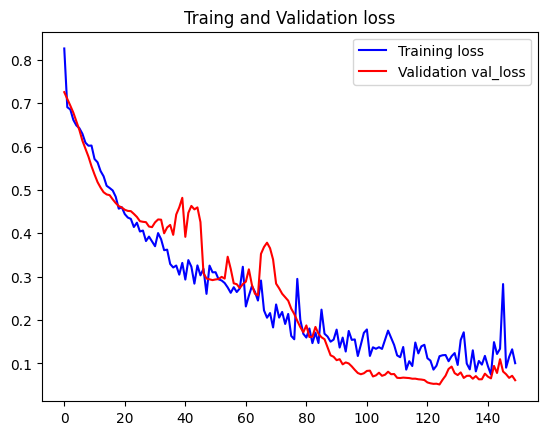

In [ ]:
#@title 自采数据集 训练OLD_EEGNet与New_EEGNet
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/EEG_Y_16ch.npy')
# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 2, Chans = 16, Samples = 74, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=150, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/oldeegnet_model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/oldeegnet_model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

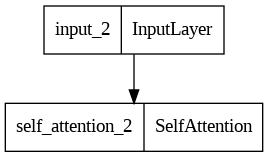

In [ ]:
#@title 架构画图 EEGNet(OLD_EEGNet) 
from tensorflow.keras.utils import plot_model
inputs = Input(shape=input_dim)
attention_output = SelfAttention(embed_dim, num_heads)(inputs)
model = Model(inputs=inputs, outputs=attention_output)
plot_model(model, to_file='eegnet.png')

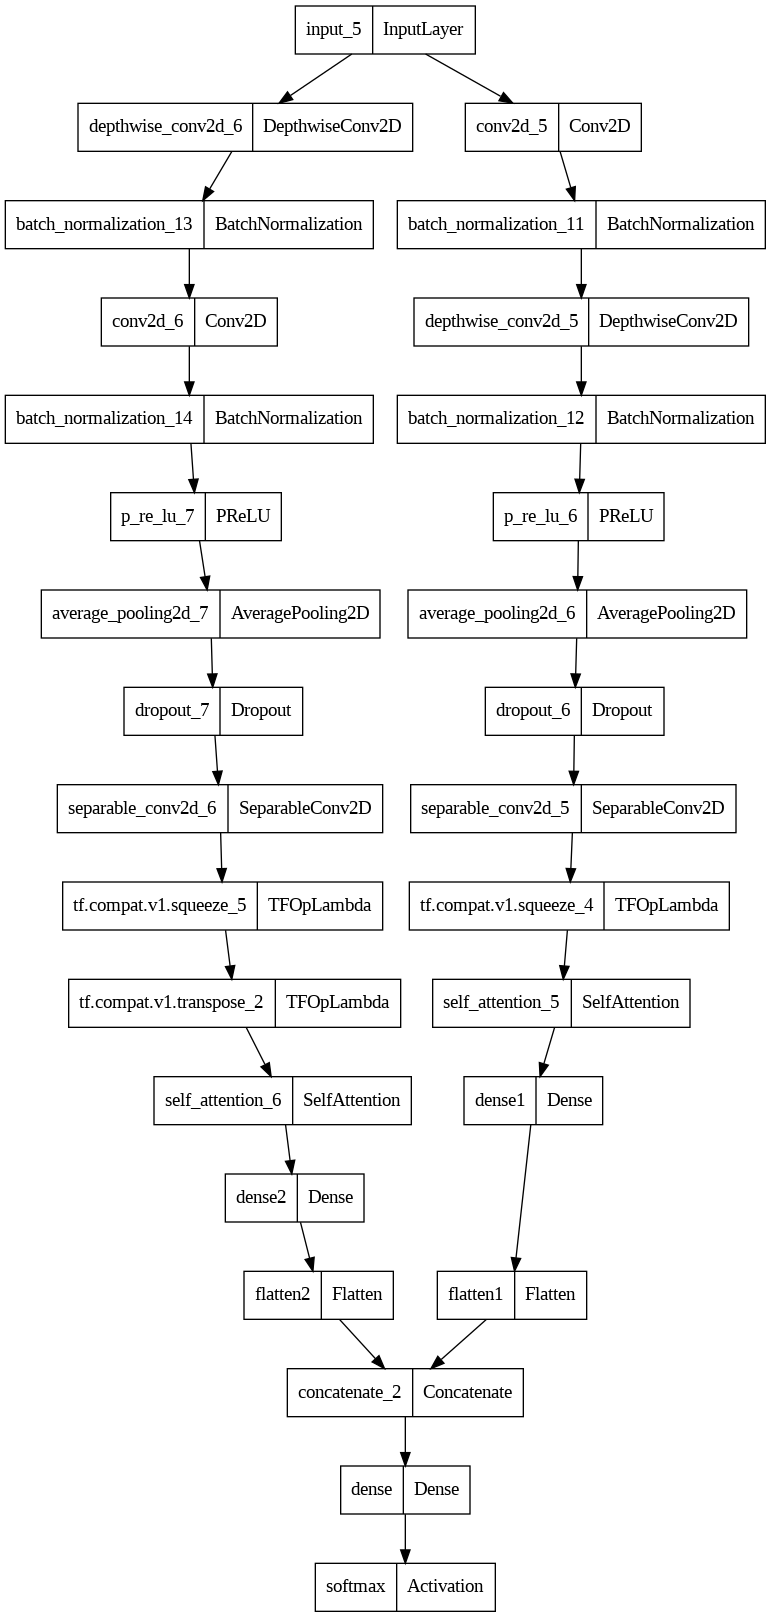

In [ ]:
#@title 架构画图 mid_eegnet 
model_trans = Mid_EEGNet(2)
plot_model(model_trans, to_file='trans_eegnet.png')

In [ ]:
#@title 多模态 DCCA cca_loss函数
from keras import backend as K
import tensorflow as tf

class cca_loss():
    def __init__(self, outdim_size, use_all_singular_values):
        self.outdim_size = outdim_size
        self.use_all_singular_values = use_all_singular_values

    def loss(self, y_true, y_pred):
        r1 = 1e-3
        r2 = 1e-3
        eps = 1e-9
        print('y_pred shape',y_pred.shape)
        o1 = o2 = y_pred.shape[1]//2

        # unpack (separate) the output of networks for view 1 and view 2
        H1 = y_pred[:, 0:o1]
        H2 = y_pred[:, o1:o1+o2]

        H1, H2 = tf.transpose(H1), tf.transpose(H2)
        o1 = o2 = K.int_shape(H1)[0]

        m = K.int_shape(H1)[1]

        H1bar = H1 - tf.expand_dims(tf.reduce_mean(H1, axis=1), axis=1)
        H2bar = H2 - tf.expand_dims(tf.reduce_mean(H2, axis=1), axis=1)

        SigmaHat12 = (1.0 / (m - 1)) * tf.matmul(H1bar, tf.transpose(H2bar))
        SigmaHat11 = (1.0 / (m - 1)) * tf.matmul(H1bar, tf.transpose(H1bar)) + r1 * tf.eye(o1)
        SigmaHat22 = (1.0 / (m - 1)) * tf.matmul(H2bar, tf.transpose(H2bar)) + r2 * tf.eye(o2)
        # 计算特征值及特征向量
        # Calculating the root inverse of covariance matrices by using eigen decomposition
        [D1, V1] = tf.linalg.eigh(SigmaHat11)
        [D2, V2] = tf.linalg.eigh(SigmaHat22)

        # Added to increase stability posInd1为特征值大于eps的位置
        posInd1 = tf.squeeze(tf.where(tf.greater(D1, eps)), axis=1)
        D1 = tf.gather(D1, posInd1)
        V1 = tf.gather(V1, posInd1, axis=1)
        posInd2 = tf.squeeze(tf.where(tf.greater(D2, eps)), axis=1)
        D2 = tf.gather(D2, posInd2)
        V2 = tf.gather(V2, posInd2, axis=1)

        SigmaHat11RootInv = tf.matmul(tf.matmul(V1, tf.linalg.diag(D1 ** -0.5)), tf.transpose(V1))
        SigmaHat22RootInv = tf.matmul(tf.matmul(V2, tf.linalg.diag(D2 ** -0.5)), tf.transpose(V2))

        Tval = tf.matmul(tf.matmul(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)

        if self.use_all_singular_values:
            # all singular values are used to calculate the correlation
            tmp = tf.matmul(tf.transpose(Tval), Tval)
            corr = tf.trace(tf.sqrt(tmp))
            # assert tf.math.is_nan(corr).numpy() == 0
        else:
            # just the top self.outdim_size singular values are used
            trace_TT = tf.matmul(tf.transpose(Tval), Tval)
            trace_TT = trace_TT + r1 * tf.eye(K.int_shape(trace_TT)[0])
            U, V = tf.linalg.eigh(trace_TT)
            U = tf.where(tf.greater(U, eps), U, tf.ones_like(U) * eps)
            U = tf.math.top_k(U, k=self.outdim_size)[0]
            corr = tf.reduce_sum(tf.sqrt(U))
        return -corr


In [ ]:
#@title 多模态 特征提取 
from keras.layers import Dense, Concatenate
from keras.models import Sequential
from keras.optimizers import RMSprop,Adam
from keras.regularizers import l2
from sklearn import svm

def trans_EEGNet(nb_classes = 2,Chans = 16, Samples = 74, dropoutRate = 0.5, kernLength = 30, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)  
  
  sequence_output  = Concatenate(axis=-1)([block2, block4])
  sequence_output = Dense(144)(sequence_output)
  sequence_output  = Activation('softmax', name = 'softmax')(sequence_output)
  # print('output shape',sequence_output.shape) 
  return Model(inputs=sequence_input,outputs=sequence_output)

# def vit_use(nb_classes=2):
#   image_input = Input(shape=(224, 224, 3))
#   image = vit.vit_b16(classes = nb_classes,pretrained=True,pretrained_top=False)(image_input)
#   return Model(inputs=image_input,outputs= image)


def svm_classify(x_train,y_train,x_test,y_test,C):
    """
    trains a linear SVM on the data
    input C specifies the penalty factor of SVM
    """
    print('training SVM...')
    clf = svm.SVC(C=C)
    clf.fit(x_train,y_train)
    accuracy = clf.score(x_test, y_test)
    print("Model accuracy:", accuracy)

    return accuracy

In [ ]:
#@title 多模态 特征提取及训练,并使用svm分类
import numpy as np
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def train_model(x_train,y_train,pic_train,x_test,y_test,pic_test,epoch_num,batch_size):
    """
    trains the model
    # Arguments
        data1 and data2: the train, validation, and test data for view 1 and view 2 respectively. data should be packed
        like ((X for train, Y for train), (X for validation, Y for validation), (X for test, Y for test))
        epoch_num: number of epochs to train the model
        batch_size: the size of batches
    # Returns
        the trained model
    """

    def dcca_multi_modal(nb_classes = 2,Chans = 16, Samples = 74, dropoutRate = 0.5, kernLength = 30, F1 = 8,D = 2,F2 = 16,norm_rate = 0.25,dropoutType = 'Dropout'):
      sequence_input = Input(shape=(Chans, Samples, 1))
      image_input = Input(shape=(224, 224, 3))
      model1 = trans_EEGNet(nb_classes,Chans,Samples,dropoutRate,kernLength,F1,D,F2,norm_rate,dropoutType)(sequence_input)
      emb_model = vit_test(embedding_dim=144)
      model2 = emb_model(image_input)
      model2 = Activation('softmax', name = 'softmax')(model2)
      # model2 = vit_test(embedding_dim =  )(image_input)
      out  = Concatenate(axis=-1)([model1, model2])
      return Model(inputs=[sequence_input, image_input], outputs=out)
      

    model = dcca_multi_modal()
    model.summary()
    model_optimizer = Adam(learning_rate=6e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
    model.compile(loss=cca_loss(2, False).loss, optimizer=model_optimizer)
    # best weights are saved in "temp_weights.hdf5" during training
    # it is done to return the best model based on the validation loss
    checkpointer = ModelCheckpoint(filepath="temp_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)

    # used dummy Y because labels are not used in the loss function
    model.fit([x_train, pic_train], np.zeros(len(x_train)), validation_data=([x_test, pic_test], np.zeros(len(x_test))),
              batch_size=batch_size, epochs=epoch_num,callbacks=[checkpointer])

    return model


def test_model(model,x_train,y_train,pic_train,x_test,y_test,pic_test):
    """produce the new features by using the trained model
    # Arguments
        model: the trained model
        data1 and data2: the train, validation, and test data for view 1 and view 2 respectively.
            Data should be packed like
            ((X for train, Y for train), (X for validation, Y for validation), (X for test, Y for test))
        outdim_size: dimension of new features
        apply_linear_cca: if to apply linear CCA on the new features
    # Returns
        new features packed like
            ((new X for train - view 1, new X for train - view 2, Y for train),
            (new X for validation - view 1, new X for validation - view 2, Y for validation),
            (new X for test - view 1, new X for test - view 2, Y for test))
    """

    new_data = []
    train = model.predict([x_train,pic_train])
    print('shape after test model ',train.shape)
    test = model.predict([x_test,pic_test])
    return train,test

x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
pics = np.load('/content/drive/MyDrive/SE_pics.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道/16通道
x = x_alpha
print("x shape ",x.shape)

pics = pics.transpose((0,2,3,1))
print("pics shape ",pics.shape)
all_acc = []
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
p = 0


for train, test in kfold.split(x, y):
  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model.load_weights('/content/drive/MyDrive/new_emb_model.h5',by_name=True, skip_mismatch=True)
  model = train_model(x_train,y_train,pic_train,x_test,y_test,pic_test,epoch_num=100,batch_size=11)
  
  train,test = test_model(model,x_train,y_train,pic_train,x_test,y_test,pic_test)
  acc = svm_classify(train,y_train,test,y_test,C=1)
  print("%.2f" % (acc*100)) 
  all_acc.append(acc)
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

x shape  (110, 16, 74)
pics shape  (110, 224, 224, 3)


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 16, 74, 1)]  0           []                               
                                                                                                  
 model_5 (Functional)           (None, 144)          86711800    ['input_9[0][0]']                
                                                                                                  
 model_4 (Functional)           (None, 144)          55785       ['input_8[0][0]']          

NameError: ignored

In [ ]:
#@title 架构 多模态模型 仅拼接
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


def multi_modal(nb_classes = 2,Chans = 64, Samples = 128, dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)  
  
  sequence_output  = Concatenate(axis=-1)([block2, block4])

  image_input = Input(shape=(224, 224, 3))
  image = vit.vit_b16(classes = 288,pretrained=False,pretrained_top=False)(image_input)

  concatenated_output = Concatenate()([sequence_output, image])
  dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(concatenated_output)
  softmax = Activation('softmax', name = 'softmax')(dense)
  return Model(inputs=[sequence_input, image_input], outputs=softmax)
  
num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
pics = np.load('/content/drive/MyDrive/SE_pics.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道/16通道
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)
pics = pics.transpose((0,2,3,1))
print("pics shape ",pics.shape)

seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = multi_modal(nb_classes = 2, Chans = 16, Samples = 74, dropoutRate = 0.5,
                      kernLength = kernLength, F1 = 4, D = 8, F2 = 8)
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model = create_model(30)
  p= p+1
  history = model.fit([x_train,pic_train], y_train, epochs=100, batch_size=batch_size, 
                      verbose=0,validation_data = ([x_test,pic_test],y_test))
  # epochs=range(len(history.history['accuracy']))
  # plt.figure()
  # plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  # plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  # plt.title('Traing and Validation accuracy')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_acc.jpg')

  # plt.figure()
  # plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  # plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  # plt.title('Traing and Validation loss')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


x shape  (110, 16, 74)
pics shape  (110, 224, 224, 3)
[0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8295454382896423, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8409090638160706, 0.6704545617103577, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8636363744735718, 0.7840909361839294, 0.8295454382896423, 0.8522727489471436, 0.9772727489471436, 0.8522727489471436, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8977272510528564, 0.9659090638160706, 0.8863636255264282, 0.8863636255264282, 0.9659090638160706, 0.9431818127632141, 0.9318181872367859, 0.9659090638160706, 0.7954545617103577, 0.9090909361839294, 0.875, 0.9204545617103577, 0.875, 0.9090909361839294, 0.9431818127632141, 0.9204545617103577, 0.9772727489471436, 0.9772727489471436, 0.9886363744735718, 0.829545438

In [ ]:
#@title 架构 多模态模型 仅拼接 同数据维度
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


def multi_modal(nb_classes = 2,Chans = 64, Samples = 128, dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)  
  
  sequence_output  = Concatenate(axis=-1)([block2, block4])

  image_input = Input(shape=(224, 224, 3))
  image = vit.vit_b16(classes = 144,pretrained=False,pretrained_top=False)(image_input)

  concatenated_output = Concatenate()([sequence_output, image])
  dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(concatenated_output)
  softmax = Activation('softmax', name = 'softmax')(dense)
  return Model(inputs=[sequence_input, image_input], outputs=softmax)
  
num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
pics = np.load('/content/drive/MyDrive/SE_pics.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道/16通道
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)
pics = pics.transpose((0,2,3,1))
print("pics shape ",pics.shape)

seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = multi_modal(nb_classes = 2, Chans = 16, Samples = 74, dropoutRate = 0.5,
                      kernLength = kernLength, F1 = 4, D = 8, F2 = 8)
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model = create_model(30)
  p= p+1
  history = model.fit([x_train,pic_train], y_train, epochs=100, batch_size=batch_size, 
                      verbose=0,validation_data = ([x_test,pic_test],y_test))
  # epochs=range(len(history.history['accuracy']))
  # plt.figure()
  # plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  # plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  # plt.title('Traing and Validation accuracy')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_acc.jpg')

  # plt.figure()
  # plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  # plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  # plt.title('Traing and Validation loss')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))


In [ ]:
#@title 架构 多模态模型 使用双线性池化
from keras.layers import Lambda, Input, Dense
import keras.backend as K
def bilinear_pooling(x):
    # x[0]和x[1]分别代表两个输入的特征图
    # 下面的代码实现了双线性池化的公式
    out = K.batch_dot(K.reshape(x[0], (-1, 1, K.int_shape(x[0])[1])),
                      K.reshape(x[1], (-1, 1,K.int_shape(x[1])[1])),
                      axes=[1, 1])
    out = K.sqrt(K.abs(out) + 1e-10)
    out = K.l2_normalize(out, axis=-1)
    return out
#
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


def multi_modal(nb_classes = 2,Chans = 64, Samples = 128, dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)  
  
  sequence_output  = Concatenate(axis=-1)([block2, block4])

  image_input = Input(shape=(224, 224, 3))
  # image = vit.vit_b16(classes = nb_classes,pretrained=False,pretrained_top=False)(image_input)
  emb_model = vit_test(embedding_dim=144)
  image = emb_model(image_input)

  bilinear_layer = Lambda(bilinear_pooling)
  out = bilinear_layer([sequence_output, image])
  concatenated_output = Flatten()(out)
  # concatenated_output = Concatenate()([sequence_output, image])
  dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(concatenated_output)
  softmax = Activation('softmax', name = 'softmax')(dense)
  return Model(inputs=[sequence_input, image_input], outputs=softmax)
  
num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
pics = np.load('/content/drive/MyDrive/SE_pics.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道/16通道
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)
pics = pics.transpose((0,2,3,1))
print("pics shape ",pics.shape)

seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = multi_modal(nb_classes = 2, Chans = 16, Samples = 74, dropoutRate = 0.5,
                      kernLength = kernLength, F1 = 4, D = 8, F2 = 8)
  adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model = create_model(30)
  model.load_weights('models/new_emb_model.h5',by_name=True, skip_mismatch=True)
  p= p+1
  history = model.fit([x_train,pic_train], y_train, epochs=100, batch_size=batch_size, 
                      verbose=0,validation_data = ([x_test,pic_test],y_test))
  # epochs=range(len(history.history['accuracy']))
  # plt.figure()
  # plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  # plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  # plt.title('Traing and Validation accuracy')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_acc.jpg')

  # plt.figure()
  # plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  # plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  # plt.title('Traing and Validation loss')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))


x shape  (110, 16, 74)
pics shape  (110, 224, 224, 3)
[0.6704545617103577, 0.7045454382896423, 0.7727272510528564, 0.7954545617103577, 0.6931818127632141, 0.7613636255264282, 0.7045454382896423, 0.8068181872367859, 0.8636363744735718, 0.8295454382896423, 0.8409090638160706, 0.8863636255264282, 0.8522727489471436, 0.875, 0.875, 0.875, 0.9090909361839294, 0.875, 0.9204545617103577, 0.9545454382896423, 0.9545454382896423, 0.9204545617103577, 0.9318181872367859, 0.9318181872367859, 0.9431818127632141, 0.9318181872367859, 0.9431818127632141, 0.9545454382896423, 0.9886363744735718, 0.9659090638160706, 0.9431818127632141, 0.9204545617103577, 0.8863636255264282, 0.9431818127632141, 0.9772727489471436, 0.9090909361839294, 0.9772727489471436, 0.9772727489471436, 0.9772727489471436, 0.9431818127632141, 0.9431818127632141, 0.9431818127632141, 1.0, 0.9431818127632141, 0.9772727489471436, 0.9772727489471436, 0.9545454382896423, 0.9545454382896423, 0.9886363744735718, 0.9772727489471436, 0.9772727489

In [ ]:
#@title 架构 多模态模型 双通道attention
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


def multi_modal(nb_classes = 2,Chans = 64, Samples = 128, dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1])
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)  
  
  sequence_output  = Concatenate(axis=-1)([block2, block4])
  sequence_output = Dense(144)(sequence_output)

  image_input = Input(shape=(224, 224, 3))
  # image = vit.vit_b16(classes = 144,pretrained=True,pretrained_top=False)(image_input)
  emb_model = vit_test(embedding_dim=144)
  image = emb_model(image_input)

  sequence_output = tf.expand_dims(sequence_output,1)
  image = tf.expand_dims(image,1)
  concatenated_output = Concatenate(axis = 1)([sequence_output, image])
  out =  concatenated_output
  out = tf.transpose(out,perm= [0,2,1])
  out = SelfAttention(2, 8)(out)
  out = Flatten()(out)
  dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(out)
  softmax = Activation('softmax', name = 'softmax')(dense)
  return Model(inputs=[sequence_input, image_input], outputs=softmax)
  
num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
pics = np.load('/content/drive/MyDrive/SE_pics.npy')
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道/16通道
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)
pics = pics.transpose((0,2,3,1))
print("pics shape ",pics.shape)

seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = multi_modal(nb_classes = 2, Chans = 16, Samples = 74, dropoutRate = 0.5,
                      kernLength = kernLength, F1 = 4, D = 8, F2 = 8)
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  pic_train = pics[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = pics[test]
  model = create_model(30)
  model.load_weights('models/new_emb_model.h5',by_name=True, skip_mismatch=True)
  p= p+1
  history = model.fit([x_train,pic_train], y_train, epochs=100, batch_size=batch_size, 
                      verbose=0,validation_data = ([x_test,pic_test],y_test))
  # epochs=range(len(history.history['accuracy']))
  # plt.figure()
  # plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  # plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  # plt.title('Traing and Validation accuracy')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_acc.jpg')

  # plt.figure()
  # plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  # plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  # plt.title('Traing and Validation loss')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/multi_model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))


x shape  (110, 16, 74)
pics shape  (110, 224, 224, 3)
[0.6136363744735718, 0.7045454382896423, 0.7613636255264282, 0.8181818127632141, 0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8068181872367859, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8295454382896423, 0.8181818127632141, 0.8181818127632141, 0.8295454382896423, 0.8295454382896423, 0.8181818127632141, 0.8409090638160706, 0.8181818127632141, 0.8295454382896423, 0.8181818127632141, 0.8295454382896423, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8295454382896423, 0.8409090638160706, 0.8409090638160706, 0.8181818127632141, 0.8522727489471436, 0.8295454382896423, 0.8181818127632141, 0.8295454382896423, 0.8181818127632141, 0.840

x shape  (110, 16, 74)
[0.6704545617103577, 0.8522727489471436, 0.8295454382896423, 0.8522727489471436, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8181818127632141, 0.8295454382896423, 0.8636363744735718, 0.7954545617103577, 0.8295454382896423, 0.8409090638160706, 0.8409090638160706, 0.8863636255264282, 0.8636363744735718, 0.9090909361839294, 0.8636363744735718, 0.8977272510528564, 0.875, 0.8863636255264282, 0.9431818127632141, 0.9318181872367859, 0.9318181872367859, 0.9545454382896423, 0.9431818127632141, 0.9318181872367859, 0.8977272510528564, 0.9431818127632141, 0.9204545617103577, 0.9204545617103577, 0.9431818127632141, 0.9659090638160706, 0.9545454

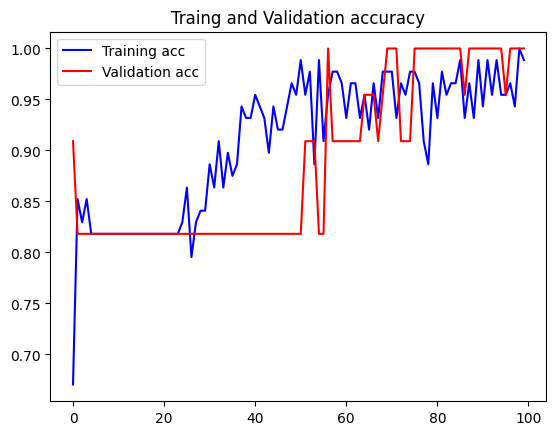

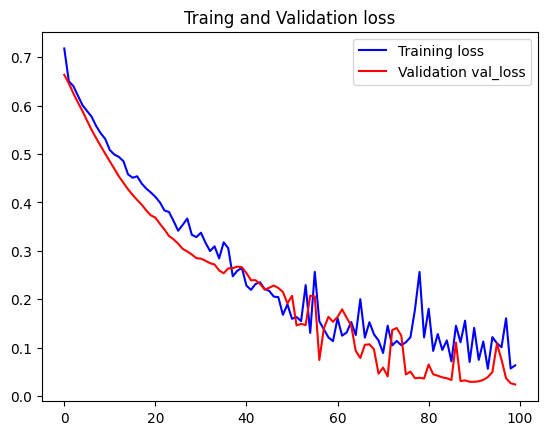

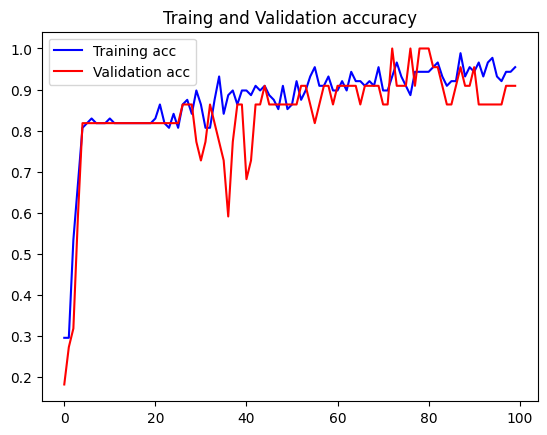

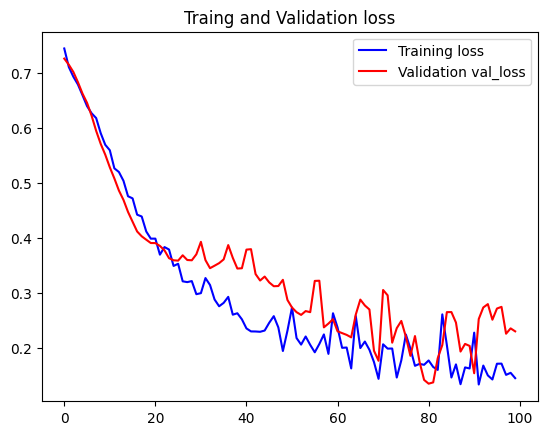

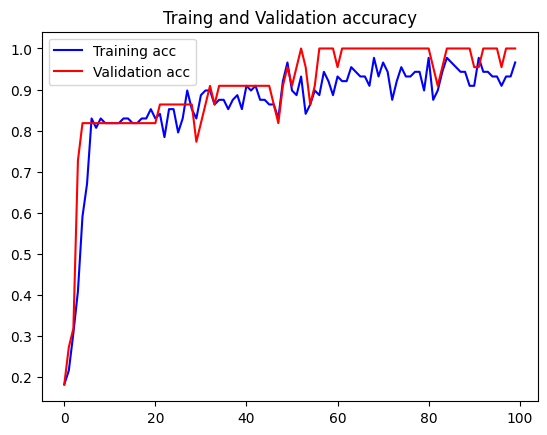

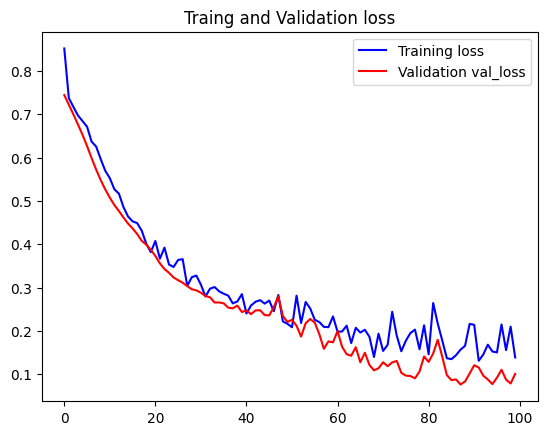

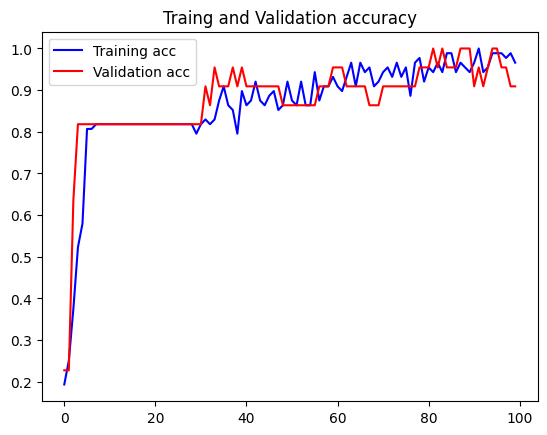

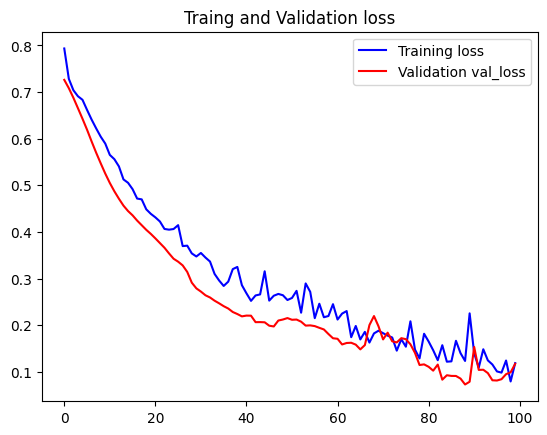

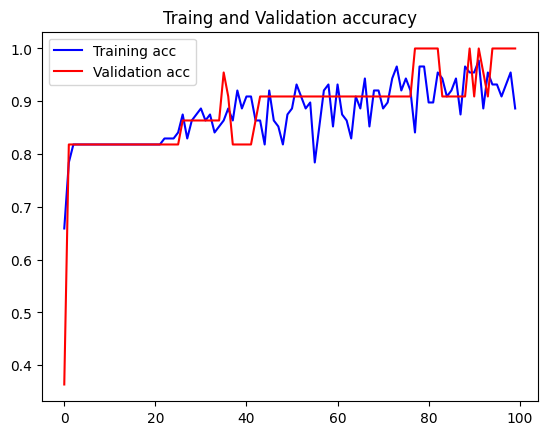

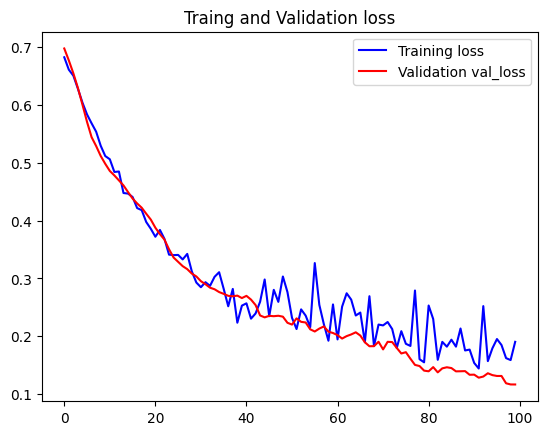

In [ ]:
#@title 架构 多模态(仅标签)
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Conv2D, MaxPooling2D, Flatten, Concatenate
from keras.models import Model
import numpy as np
from vit_keras import vit
import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


def half_multi_modal(nb_classes = 2,Chans = 64, Samples = 128, dropoutRate = 0.5, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
  sequence_input = Input(shape=(Chans, Samples, 1))
  if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
  elif dropoutType == 'Dropout':
      dropoutType = Dropout
  else:
      raise ValueError('dropoutType must be one of SpatialDropout2D '
                        'or Dropout, passed as a string.')

  block1   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = (Chans, Samples, 1), use_bias = False)(sequence_input)
  block1   = BatchNormalization()(block1)
  block1   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(block1)
  block1   = BatchNormalization()(block1)
  block1   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block1)
  block1   = AveragePooling2D((1, 4))(block1)
  block1   = dropoutType(dropoutRate)(block1)
  
  block2   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block1)
  block2   = tf.squeeze(block2,[1]) #block2完之后32为序列 16为通道
  # block2   = Transformer_Block(block2.shape[-2],block2.shape[-1],4,2)(block2)
  block2   = SelfAttention(block2.shape[-1], 4)(block2)
  block2   = Dense(block2.shape[-1]//2, name = 'dense1', kernel_constraint = max_norm(norm_rate))(block2)
  block2   = Flatten(name = 'flatten1')(block2)

  block3   = DepthwiseConv2D((Chans, 1), use_bias = False, depth_multiplier = D,depthwise_constraint = max_norm(1.))(sequence_input)
  block3   = BatchNormalization()(block3)
  block3   = Conv2D(F1, (1, kernLength), padding = 'same',input_shape = block3.shape[1:], use_bias = False)(block3)
  block3   = BatchNormalization()(block3)
  block3   = PReLU(alpha_initializer='zeros', alpha_regularizer=None,
              alpha_constraint=None)(block3)
  block3   = AveragePooling2D((1, 4))(block3)
  block3   = dropoutType(dropoutRate)(block3)

  block4   = SeparableConv2D(F2, (1, 32), use_bias = False, padding = 'same')(block3)
  block4   = tf.squeeze(block4,[1]) #block2完之后32为序列 16为通道
  block4   = tf.transpose(block4,perm= [0,2,1])
  # block4   = Transformer_Block(block4.shape[-2],block4.shape[-1],4,2)(block4)
  block4   = SelfAttention(block4.shape[-1], 4)(block4)
  block4   = Dense(block4.shape[-1]//2, name = 'dense2', kernel_constraint = max_norm(norm_rate))(block4)
  block4   = Flatten(name = 'flatten2')(block4)  #应不应该使用flatten直接展平
  
  sequence_output  = Concatenate(axis=-1)([block2, block4])

  label_input = Input(shape=(4))
  # image = vit.vit_b16(classes = nb_classes,pretrained=False,pretrained_top=False)(image_input)

  concatenated_output = Concatenate()([sequence_output, label_input])
  dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(concatenated_output)
  softmax = Activation('softmax', name = 'softmax')(dense)
  return Model(inputs=[sequence_input, label_input], outputs=softmax)
  
num_classes = 2
batch_size = 6
x = np.load('/content/drive/MyDrive/SE_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_Y_16ch.npy')
labels = np.load('/content/drive/MyDrive/SE_labels.npy')
x_alpha = x[:,:,:,0].transpose(0,2,1) #128通道/16通道
x = x_alpha
print("x shape ",x.shape)
y = to_categorical(y, num_classes)


seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = half_multi_modal(nb_classes = 2, Chans = 16, Samples = 74, dropoutRate = 0.5,
                      kernLength = kernLength, F1 = 4, D = 8, F2 = 8)
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  pic_train = labels[train]
  x_test = x[test]
  y_test = y[test]
  pic_test = labels[test]
  model = create_model(30)
  p= p+1
  history = model.fit([x_train,pic_train], y_train, epochs=100, batch_size=batch_size, 
                      verbose=0,validation_data = ([x_test,pic_test],y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/half_model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/half_model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))


x shape  (110, 16, 74)
{0.0, 1.0}
[0.5, 0.4886363744735718, 0.5340909361839294, 0.5113636255264282, 0.5340909361839294, 0.5795454382896423, 0.5909090638160706, 0.6022727489471436, 0.5795454382896423, 0.6363636255264282, 0.6363636255264282, 0.6477272510528564, 0.6477272510528564, 0.7159090638160706, 0.6931818127632141, 0.7386363744735718, 0.6818181872367859, 0.75, 0.7272727489471436, 0.75, 0.75, 0.7727272510528564, 0.75, 0.7727272510528564, 0.7613636255264282, 0.7613636255264282, 0.75, 0.7840909361839294, 0.7613636255264282, 0.7386363744735718, 0.8068181872367859, 0.7840909361839294, 0.8181818127632141, 0.7954545617103577, 0.7727272510528564, 0.8409090638160706, 0.8295454382896423, 0.8068181872367859, 0.7727272510528564, 0.7840909361839294, 0.7840909361839294, 0.8636363744735718, 0.8181818127632141, 0.8522727489471436, 0.9090909361839294, 0.8863636255264282, 0.8068181872367859, 0.8977272510528564, 0.8636363744735718, 0.875, 0.8977272510528564, 0.875, 0.8863636255264282, 0.86363637447357

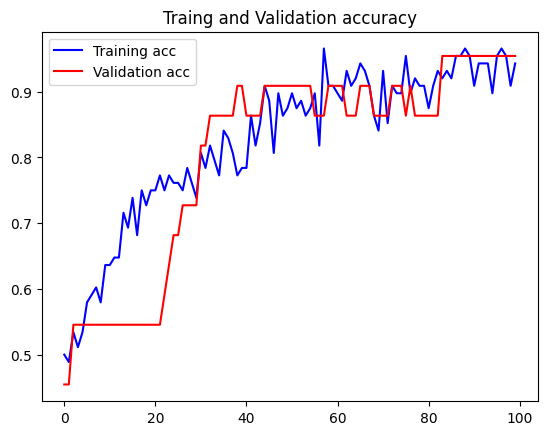

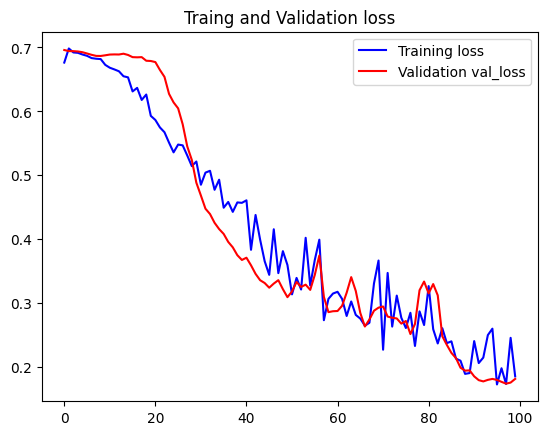

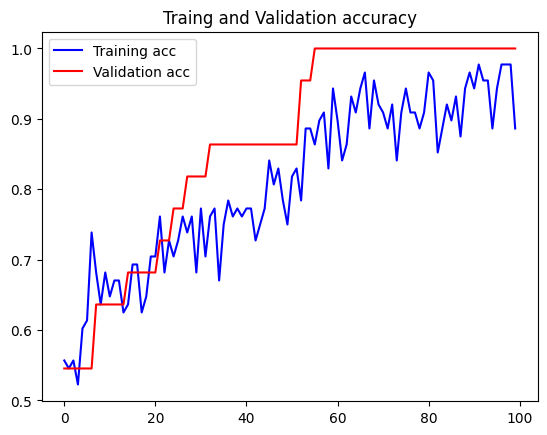

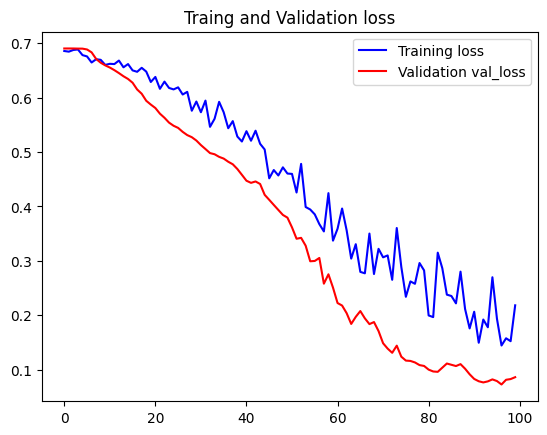

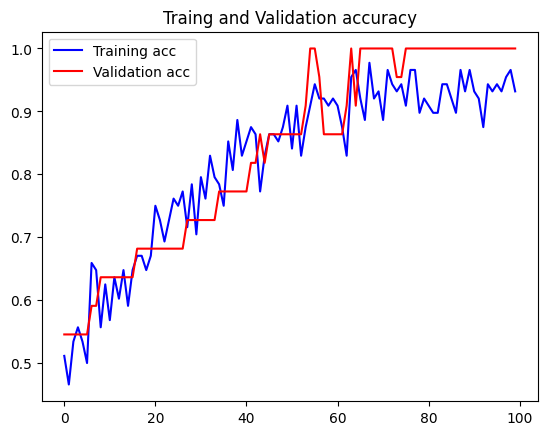

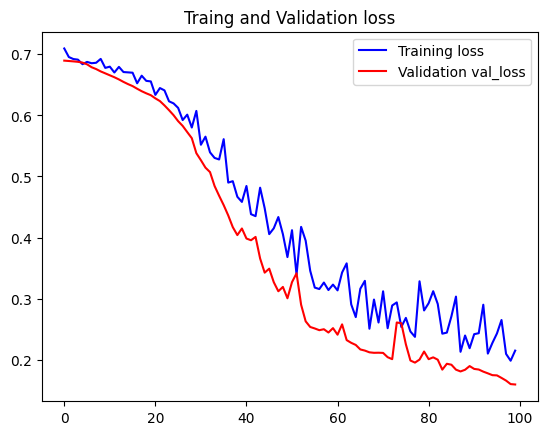

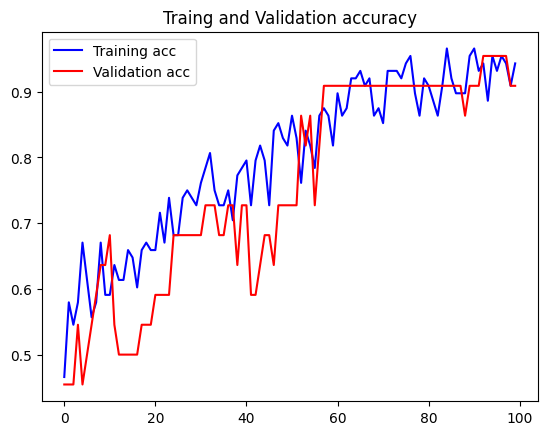

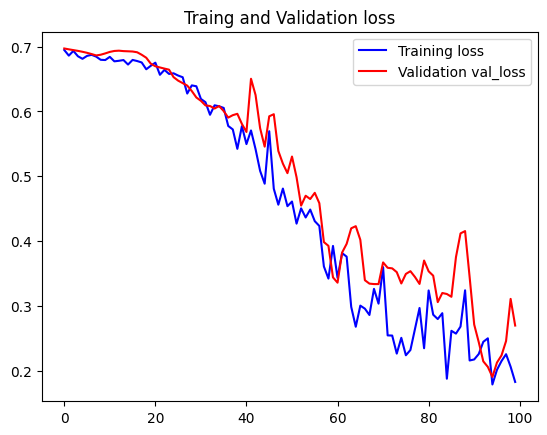

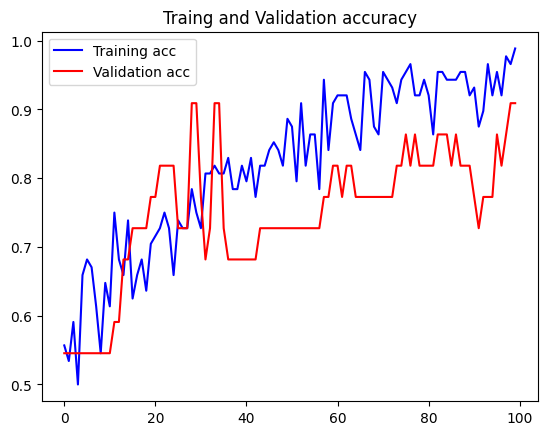

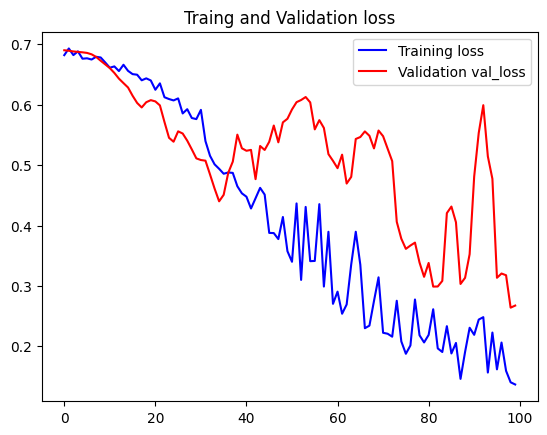

In [ ]:
#@title 自采数据集 训练Mid_EEGNet 由脑电到舌象
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEG_X_16ch.npy')
y = np.load('/content/drive/MyDrive/SE_labels.npy')
# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,0].transpose(0,2,1) #128通道
x = x_alpha
print("x shape ",x.shape)

y = y [:,3]
y_set = set(y)
num_classes = len(y_set)
print(y_set)
# for i in range(y.shape[0]): #舌色
#   if y[i]>=3:
#     y[i]-=2
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = num_classes, Chans = 16, Samples = 74, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #compile the model and set the optimizers
  # model = KerasClassifier(build_fn=create_model, verbose=0)

  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # 原模型best 100实际50 新模型 20实际30
  # break;
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

In [ ]:
#@title 128通道MODMA 训练MID_EEGNET
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEGNet_X.npy')
y = np.load('/content/drive/MyDrive/EEGNet_Y.npy')

# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
print('set y',set(y))
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 2, Chans = 128, Samples = 300, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  #还是1e-4吧
  adam = Adam(learning_rate=2e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #compile the model and set the optimizers
  # model = KerasClassifier(build_fn=create_model, verbose=0)

  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # 原模型best 100实际50 新模型 20实际30
  # break;
  model = create_model(15)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

set y {0.0, 1.0}


KeyboardInterrupt: ignored

In [ ]:
#@title 128通道MODMA 训练SVM
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout,Bidirectional
from keras.layers import Flatten, Dense, Concatenate, Reshape, LSTM
from keras.models import Sequential, Model

x = np.load('/content/drive/MyDrive/EEGNet_X.npy')
y = np.load('/content/drive/MyDrive/EEGNet_Y.npy')

def MLP(input_dim,num_classes):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_dim))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# print(x.shape)
# print(y)
x = x.reshape(318,50,128,5)
y = np.repeat(y,6)
# print(y)

x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
x = x.reshape(x.shape[0],-1)
print(x.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
y = to_categorical(y, 2)

for train, test in kfold.split(x, y.argmax(1)):
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # # clf = DecisionTreeClassifier()
  # clf = RandomForestClassifier(n_estimators=5)
  # # clf = svm.SVC()
  # # clf =  LogisticRegression()
  # clf.fit(x_train, y_train)
  # accuracy = clf.score(x_test, y_test)
  # print("Model accuracy:", accuracy)
  # scores = accuracy*100
  # print("%.2f" % (scores)) # Accuracy
  # all_acc.append(scores)

  model = MLP(x_train.shape[-1],2)
  adam = Adam(learning_rate=0.00002, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  history = model.fit(x_train, y_train, epochs=100, batch_size=30, verbose=0,validation_data = (x_test,y_test))
  epochs = range(len(history.history['accuracy']))
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) 
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  print("%.2f" % (scores))
  all_acc.append(scores)

 
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

(318, 6400)
[0.539370059967041, 0.5314960479736328, 0.6023622155189514, 0.5748031735420227, 0.5748031735420227, 0.5236220359802246, 0.5944882035255432, 0.6062992215156555, 0.5590550899505615, 0.6181102395057678, 0.5984252095222473, 0.6102362275123596, 0.5275590419769287, 0.4960629940032959, 0.5590550899505615, 0.5, 0.6220472455024719, 0.5944882035255432, 0.5944882035255432, 0.539370059967041, 0.5433070659637451, 0.6181102395057678, 0.6141732335090637, 0.6456692814826965, 0.6338582634925842, 0.6062992215156555, 0.5629921555519104, 0.6181102395057678, 0.6299212574958801, 0.6496062874794006, 0.5669291615486145, 0.6299212574958801, 0.5748031735420227, 0.539370059967041, 0.5354330539703369, 0.6141732335090637, 0.6141732335090637, 0.6141732335090637, 0.6456692814826965, 0.6338582634925842, 0.5787401795387268, 0.5748031735420227, 0.6574802994728088, 0.6062992215156555, 0.5905511975288391, 0.5669291615486145, 0.5984252095222473, 0.5905511975288391, 0.6299212574958801, 0.5826771855354309, 0.614

In [ ]:
#@title 128通道MODMA 训练MID_EEGNET 大数量切片
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold,LeaveOneOut
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 60
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEGNet_X.npy')
y = np.load('/content/drive/MyDrive/EEGNet_Y.npy')

x = x.reshape(318,50,128,5)
y = np.repeat(y,6)

# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
print('set y',set(y))
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = LeaveOneOut()
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 2, Chans = 128, Samples = 50, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  #还是1e-4吧
  adam = Adam(learning_rate=1.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

import tqdm
from tqdm import tqdm
for train, test in tqdm(kfold.split(x, y.argmax(1))):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  model = create_model(15)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  # plt.figure()
  # plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  # plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  # plt.title('Train and Validation accuracy')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  # plt.figure()
  # plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  # plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  # plt.title('Train and Validation loss')
  # plt.legend()
  # plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  # print(history.history['accuracy'])
  # print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  # max_acc.append(max(history.history['val_accuracy']))
  # print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
# print("mean max acc: {}".format(np.mean(max_acc)))
# print("std max acc: {}".format(np.std(max_acc)))
print("mean last acc: {}".format(np.mean(all_acc)))
print("std last acc: {}".format(np.std(all_acc)))

set y {0.0, 1.0}


1it [00:20, 20.48s/it]

1.00


2it [00:40, 20.15s/it]

1.00


3it [01:00, 20.35s/it]

1.00


4it [01:20, 20.19s/it]

1.00


5it [01:40, 20.05s/it]

1.00


6it [02:01, 20.22s/it]

1.00


7it [02:21, 20.14s/it]

1.00


8it [02:41, 20.05s/it]

0.00


9it [03:01, 20.28s/it]

1.00


10it [03:21, 20.17s/it]

1.00


11it [03:41, 20.06s/it]

1.00


12it [04:02, 20.32s/it]

1.00


13it [04:22, 20.33s/it]

1.00


14it [04:42, 20.21s/it]

1.00


15it [05:02, 20.06s/it]

0.00


16it [05:23, 20.39s/it]

1.00


17it [05:43, 20.30s/it]

1.00


18it [06:03, 20.19s/it]

1.00


19it [06:24, 20.44s/it]

1.00


20it [06:45, 20.41s/it]

1.00


21it [07:05, 20.28s/it]

1.00


22it [07:24, 20.17s/it]

1.00


23it [07:46, 20.60s/it]

1.00


24it [08:07, 20.56s/it]

1.00


25it [08:27, 20.42s/it]

1.00


26it [08:48, 20.74s/it]

0.00


27it [09:09, 20.68s/it]

1.00


28it [09:29, 20.51s/it]

1.00


29it [09:49, 20.35s/it]

1.00


30it [10:10, 20.74s/it]

1.00


31it [10:31, 20.66s/it]

1.00


32it [10:51, 20.52s/it]

1.00


33it [11:13, 20.79s/it]

1.00


34it [11:33, 20.76s/it]

1.00


35it [11:53, 20.57s/it]

1.00


36it [12:13, 20.38s/it]

1.00


37it [12:35, 20.85s/it]

1.00


38it [12:56, 20.77s/it]

1.00


39it [13:16, 20.61s/it]

1.00


40it [13:36, 20.41s/it]

1.00


41it [13:57, 20.72s/it]

1.00


42it [14:17, 20.53s/it]

1.00


43it [14:37, 20.35s/it]

1.00


44it [14:59, 20.67s/it]

1.00


45it [15:19, 20.54s/it]

1.00


46it [15:39, 20.32s/it]

1.00


47it [15:59, 20.14s/it]

1.00


48it [16:20, 20.53s/it]

1.00


49it [16:40, 20.41s/it]

1.00


50it [17:00, 20.27s/it]

1.00


51it [17:22, 20.62s/it]

1.00


52it [17:42, 20.52s/it]

1.00


53it [18:02, 20.33s/it]

1.00


54it [18:22, 20.18s/it]

1.00


55it [18:43, 20.57s/it]

1.00


56it [19:03, 20.35s/it]

1.00


57it [19:23, 20.14s/it]

1.00


58it [19:44, 20.44s/it]

1.00


59it [20:04, 20.32s/it]

1.00


60it [20:24, 20.18s/it]

1.00


61it [20:45, 20.53s/it]

1.00


62it [21:05, 20.53s/it]

1.00


63it [21:25, 20.33s/it]

1.00


64it [21:45, 20.15s/it]

1.00


65it [22:06, 20.51s/it]

1.00


66it [22:26, 20.37s/it]

1.00


67it [22:46, 20.17s/it]

1.00


68it [23:06, 20.03s/it]

1.00


69it [23:27, 20.43s/it]

1.00


70it [23:47, 20.31s/it]

1.00


71it [24:07, 20.16s/it]

1.00


72it [24:29, 20.72s/it]

1.00


73it [24:49, 20.61s/it]

1.00


74it [25:09, 20.39s/it]

1.00


75it [25:29, 20.19s/it]

1.00


76it [25:50, 20.56s/it]

0.00


77it [26:11, 20.44s/it]

1.00


78it [26:30, 20.27s/it]

1.00


79it [26:52, 20.71s/it]

1.00


80it [27:12, 20.55s/it]

1.00


81it [27:32, 20.31s/it]

1.00


82it [27:52, 20.16s/it]

1.00


83it [28:14, 20.60s/it]

1.00


84it [28:34, 20.46s/it]

1.00


85it [28:54, 20.29s/it]

1.00


86it [29:16, 20.80s/it]

1.00


87it [29:36, 20.69s/it]

1.00


88it [29:56, 20.41s/it]

1.00


89it [30:16, 20.23s/it]

1.00


90it [30:37, 20.67s/it]

1.00


91it [30:57, 20.51s/it]

1.00


92it [31:17, 20.27s/it]

1.00


93it [31:37, 20.09s/it]

1.00


94it [31:58, 20.51s/it]

1.00


95it [32:18, 20.39s/it]

1.00


96it [32:38, 20.14s/it]

0.00


97it [33:00, 20.69s/it]

1.00


98it [33:20, 20.63s/it]

1.00


99it [33:40, 20.39s/it]

1.00


100it [34:00, 20.17s/it]

1.00


101it [34:22, 20.62s/it]

1.00


102it [34:42, 20.50s/it]

1.00


103it [35:02, 20.28s/it]

0.00


104it [35:21, 20.05s/it]

1.00


105it [35:43, 20.48s/it]

1.00


106it [36:03, 20.35s/it]

1.00


107it [36:22, 20.16s/it]

1.00


108it [36:44, 20.69s/it]

0.00


109it [37:05, 20.58s/it]

1.00


110it [37:24, 20.36s/it]

1.00


111it [37:44, 20.21s/it]

1.00


112it [38:06, 20.61s/it]

1.00


113it [38:26, 20.48s/it]

1.00


114it [38:46, 20.28s/it]

1.00


115it [39:08, 20.85s/it]

1.00


116it [39:28, 20.70s/it]

1.00


117it [39:48, 20.38s/it]

1.00


118it [40:08, 20.21s/it]

1.00


119it [40:30, 20.75s/it]

1.00


120it [40:50, 20.61s/it]

1.00


121it [41:10, 20.35s/it]

1.00


122it [41:29, 20.14s/it]

0.00


123it [41:51, 20.54s/it]

1.00


124it [42:11, 20.38s/it]

1.00


125it [42:31, 20.16s/it]

1.00


126it [42:53, 20.73s/it]

1.00


127it [43:13, 20.61s/it]

1.00


128it [43:33, 20.36s/it]

0.00


129it [43:53, 20.22s/it]

1.00


130it [44:14, 20.71s/it]

1.00


131it [44:35, 20.54s/it]

1.00


132it [44:54, 20.33s/it]

1.00


133it [45:16, 20.64s/it]

1.00


134it [45:37, 20.68s/it]

1.00


135it [45:56, 20.44s/it]

1.00


136it [46:16, 20.23s/it]

1.00


137it [46:38, 20.78s/it]

1.00


138it [46:59, 20.64s/it]

1.00


139it [47:18, 20.40s/it]

1.00


140it [47:38, 20.15s/it]

1.00


141it [48:00, 20.72s/it]

1.00


142it [48:20, 20.60s/it]

1.00


143it [48:40, 20.37s/it]

1.00


144it [49:00, 20.16s/it]

0.00


145it [49:22, 20.65s/it]

1.00


146it [49:42, 20.47s/it]

1.00


147it [50:02, 20.27s/it]

1.00


148it [50:23, 20.58s/it]

1.00


149it [50:43, 20.60s/it]

1.00


150it [51:03, 20.33s/it]

1.00


151it [51:23, 20.08s/it]

1.00


152it [51:45, 20.69s/it]

1.00


153it [52:05, 20.62s/it]

1.00


154it [52:25, 20.37s/it]

1.00


155it [52:45, 20.15s/it]

1.00


156it [53:07, 20.70s/it]

1.00


157it [53:27, 20.53s/it]

1.00


158it [53:47, 20.34s/it]

1.00


159it [54:06, 20.13s/it]

1.00


160it [54:28, 20.62s/it]

1.00


161it [54:48, 20.53s/it]

1.00


162it [55:08, 20.28s/it]

1.00


163it [55:28, 20.07s/it]

1.00


164it [55:50, 20.60s/it]

1.00


165it [56:10, 20.46s/it]

1.00


166it [56:29, 20.24s/it]

1.00


167it [56:51, 20.57s/it]

1.00


168it [57:11, 20.56s/it]

1.00


169it [57:31, 20.33s/it]

1.00


170it [57:51, 20.15s/it]

1.00


171it [58:13, 20.72s/it]

1.00


172it [58:33, 20.59s/it]

1.00


173it [58:53, 20.34s/it]

1.00


174it [59:13, 20.14s/it]

0.00


175it [59:34, 20.66s/it]

1.00


176it [59:55, 20.53s/it]

1.00


177it [1:00:15, 20.33s/it]

1.00


178it [1:00:34, 20.13s/it]

1.00


179it [1:00:56, 20.61s/it]

1.00


180it [1:01:16, 20.47s/it]

1.00


181it [1:01:36, 20.20s/it]

1.00


182it [1:01:55, 19.98s/it]

1.00


183it [1:02:17, 20.48s/it]

1.00


184it [1:02:37, 20.34s/it]

1.00


185it [1:02:56, 20.15s/it]

1.00


186it [1:03:19, 20.75s/it]

1.00


187it [1:03:39, 20.67s/it]

1.00


188it [1:03:59, 20.41s/it]

1.00


189it [1:04:19, 20.22s/it]

1.00


190it [1:04:41, 20.71s/it]

1.00


191it [1:05:01, 20.57s/it]

1.00


192it [1:05:20, 20.30s/it]

1.00


193it [1:05:40, 20.06s/it]

1.00


194it [1:06:02, 20.55s/it]

1.00


195it [1:06:22, 20.37s/it]

1.00


196it [1:06:41, 20.17s/it]

1.00


197it [1:07:01, 20.01s/it]

1.00


198it [1:07:23, 20.50s/it]

1.00


199it [1:07:43, 20.41s/it]

1.00


200it [1:08:02, 20.17s/it]

1.00


201it [1:08:25, 20.83s/it]

1.00


202it [1:08:45, 20.67s/it]

1.00


203it [1:09:05, 20.40s/it]

1.00


204it [1:09:24, 20.17s/it]

1.00


205it [1:09:46, 20.72s/it]

1.00


206it [1:10:07, 20.54s/it]

1.00


207it [1:10:26, 20.31s/it]

1.00


208it [1:10:46, 20.08s/it]

1.00


209it [1:11:08, 20.63s/it]

1.00


210it [1:11:28, 20.53s/it]

1.00


211it [1:11:48, 20.33s/it]

1.00


212it [1:12:08, 20.12s/it]

1.00


213it [1:12:30, 20.68s/it]

1.00


214it [1:12:50, 20.52s/it]

1.00


215it [1:13:10, 20.33s/it]

1.00


216it [1:13:29, 20.09s/it]

0.00


217it [1:13:51, 20.66s/it]

1.00


218it [1:14:11, 20.51s/it]

0.00


219it [1:14:31, 20.25s/it]

1.00


220it [1:14:51, 20.05s/it]

1.00


221it [1:15:12, 20.58s/it]

1.00


222it [1:15:32, 20.44s/it]

1.00


223it [1:15:52, 20.22s/it]

1.00


224it [1:16:12, 20.03s/it]

1.00


225it [1:16:34, 20.56s/it]

1.00


226it [1:16:54, 20.40s/it]

1.00


227it [1:17:13, 20.14s/it]

1.00


228it [1:17:33, 20.00s/it]

1.00


229it [1:17:54, 20.49s/it]

1.00


230it [1:18:14, 20.30s/it]

1.00


231it [1:18:34, 20.07s/it]

1.00


232it [1:18:56, 20.83s/it]

1.00


233it [1:19:17, 20.74s/it]

1.00


234it [1:19:37, 20.47s/it]

1.00


235it [1:19:57, 20.25s/it]

1.00


236it [1:20:18, 20.66s/it]

1.00


237it [1:20:39, 20.63s/it]

1.00


238it [1:20:59, 20.43s/it]

1.00


239it [1:21:18, 20.21s/it]

1.00


240it [1:21:38, 19.97s/it]

1.00


241it [1:22:00, 20.57s/it]

1.00


242it [1:22:20, 20.40s/it]

1.00


243it [1:22:39, 20.20s/it]

1.00


244it [1:22:59, 20.02s/it]

1.00


245it [1:23:21, 20.55s/it]

1.00


246it [1:23:41, 20.42s/it]

1.00


247it [1:24:01, 20.17s/it]

1.00


248it [1:24:22, 20.60s/it]

1.00


249it [1:24:43, 20.70s/it]

1.00


250it [1:25:03, 20.47s/it]

1.00


251it [1:25:23, 20.19s/it]

1.00


252it [1:25:45, 20.91s/it]

1.00


253it [1:26:06, 20.89s/it]

1.00


254it [1:26:26, 20.58s/it]

1.00


255it [1:26:46, 20.34s/it]

1.00


256it [1:27:07, 20.71s/it]

1.00


257it [1:27:28, 20.81s/it]

1.00


258it [1:27:48, 20.59s/it]

1.00


259it [1:28:08, 20.33s/it]

1.00


260it [1:28:29, 20.67s/it]

1.00


261it [1:28:51, 20.78s/it]

1.00


262it [1:29:11, 20.56s/it]

1.00


263it [1:29:30, 20.32s/it]

1.00


264it [1:29:50, 20.11s/it]

1.00


265it [1:30:12, 20.77s/it]

1.00


266it [1:30:32, 20.59s/it]

1.00


267it [1:30:52, 20.34s/it]

1.00


268it [1:31:12, 20.22s/it]

1.00


269it [1:31:34, 20.84s/it]

1.00


270it [1:31:55, 20.65s/it]

0.00


271it [1:32:15, 20.42s/it]

1.00


272it [1:32:34, 20.18s/it]

1.00


273it [1:32:56, 20.73s/it]

1.00


274it [1:33:16, 20.54s/it]

1.00


275it [1:33:36, 20.31s/it]

1.00


276it [1:33:56, 20.09s/it]

1.00


277it [1:34:18, 20.64s/it]

1.00


278it [1:34:38, 20.48s/it]

0.00


279it [1:34:57, 20.19s/it]

1.00


280it [1:35:19, 20.63s/it]

1.00


281it [1:35:40, 20.79s/it]

0.00


282it [1:36:00, 20.61s/it]

1.00


283it [1:36:20, 20.35s/it]

1.00


284it [1:36:40, 20.18s/it]

1.00


285it [1:37:02, 20.77s/it]

1.00


286it [1:37:22, 20.59s/it]

1.00


287it [1:37:42, 20.34s/it]

1.00


288it [1:38:01, 20.10s/it]

1.00


289it [1:38:23, 20.72s/it]

1.00


290it [1:38:44, 20.60s/it]

1.00


291it [1:39:03, 20.32s/it]

1.00


292it [1:39:24, 20.24s/it]

1.00


293it [1:39:46, 20.85s/it]

1.00


294it [1:40:06, 20.73s/it]

1.00


295it [1:40:26, 20.44s/it]

1.00


296it [1:40:46, 20.33s/it]

0.00


297it [1:41:09, 20.97s/it]

0.00


298it [1:41:29, 20.92s/it]

1.00


299it [1:41:49, 20.63s/it]

1.00


300it [1:42:09, 20.35s/it]

1.00


301it [1:42:31, 20.89s/it]

1.00


302it [1:42:51, 20.68s/it]

1.00


303it [1:43:11, 20.46s/it]

1.00


304it [1:43:31, 20.24s/it]

1.00


305it [1:43:53, 20.90s/it]

1.00


306it [1:44:14, 20.69s/it]

1.00


307it [1:44:33, 20.41s/it]

1.00


308it [1:44:53, 20.20s/it]

1.00


309it [1:45:15, 20.74s/it]

1.00


310it [1:45:35, 20.62s/it]

1.00


311it [1:45:55, 20.40s/it]

1.00


312it [1:46:15, 20.14s/it]

1.00


313it [1:46:37, 20.72s/it]

1.00


314it [1:46:57, 20.60s/it]

1.00


315it [1:47:18, 20.50s/it]

1.00


316it [1:47:37, 20.27s/it]

1.00


317it [1:48:00, 20.94s/it]

1.00


318it [1:48:21, 20.44s/it]

1.00
mean last acc: 0.9433962264150944
std last acc: 0.231083937998413


set y {0.0, 1.0}
[0.437007874250412, 0.4488188922405243, 0.4566929042339325, 0.5118110179901123, 0.5433070659637451, 0.5, 0.5196850299835205, 0.5748031735420227, 0.5590550899505615, 0.5078740119934082, 0.5629921555519104, 0.5511810779571533, 0.5551180839538574, 0.5787401795387268, 0.586614191532135, 0.5669291615486145, 0.6220472455024719, 0.5944882035255432, 0.6181102395057678, 0.6535432934761047, 0.625984251499176, 0.6299212574958801, 0.6141732335090637, 0.665354311466217, 0.6181102395057678, 0.6692913174629211, 0.6574802994728088, 0.6496062874794006, 0.6456692814826965, 0.6574802994728088, 0.6614173054695129, 0.665354311466217, 0.7165354490280151, 0.712598443031311, 0.6811023354530334, 0.7283464670181274, 0.7362204790115356, 0.7322834730148315, 0.7283464670181274, 0.7559055089950562, 0.7362204790115356, 0.748031497001648, 0.7716535329818726, 0.7598425149917603, 0.7677165269851685, 0.8110235929489136, 0.787401556968689, 0.7716535329818726, 0.8070865869522095, 0.7952755689620972, 0.799

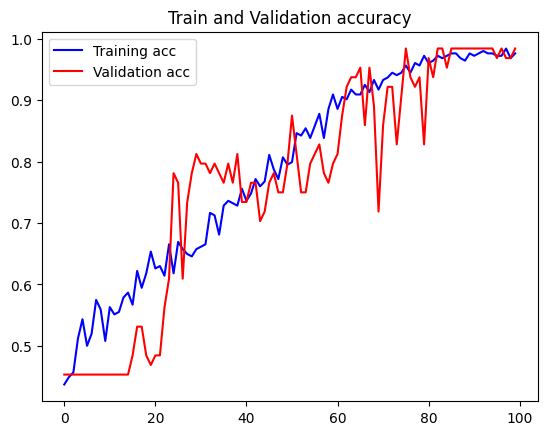

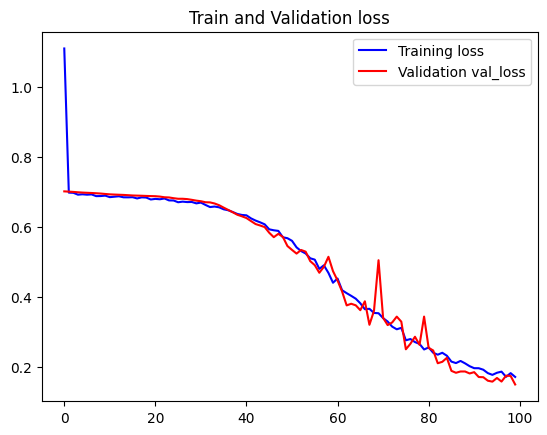

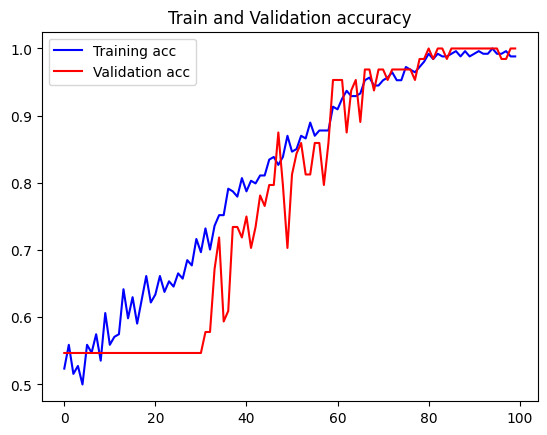

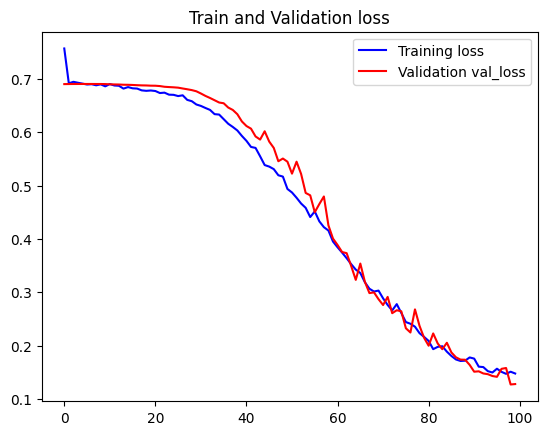

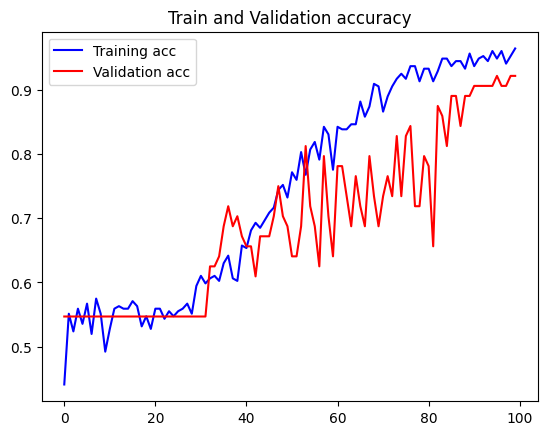

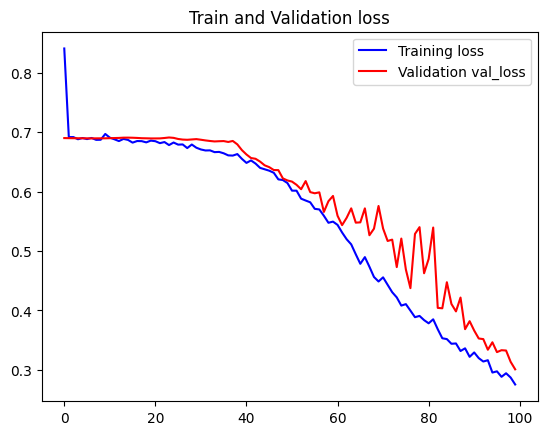

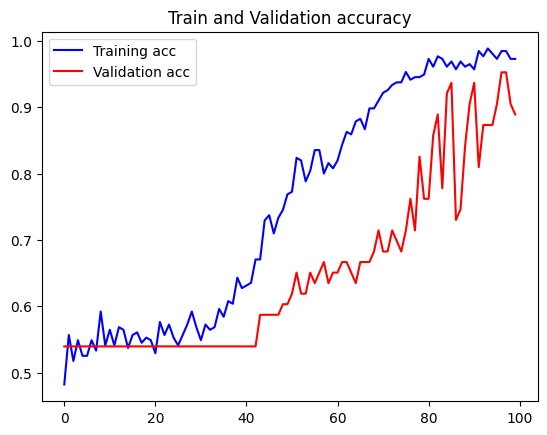

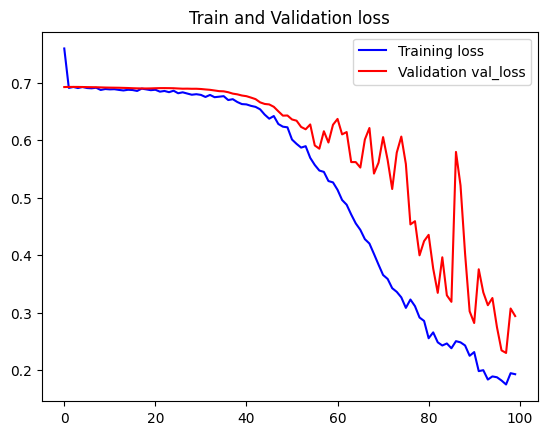

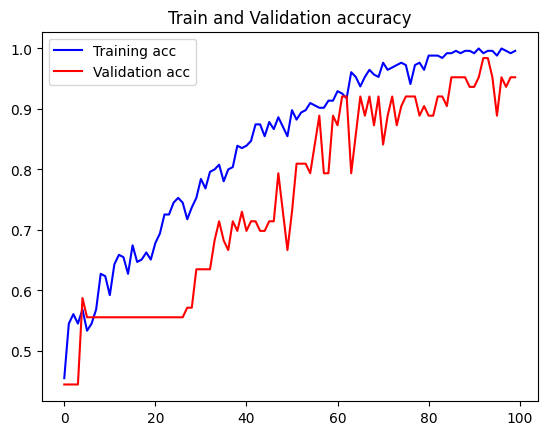

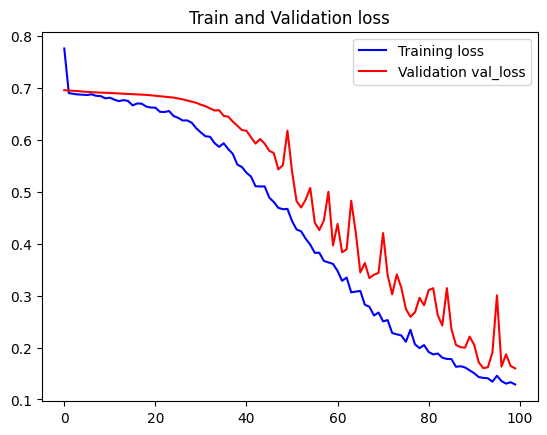

In [ ]:
#@title 128通道MODMA 训练Single_EEGNET 大数量切片
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 60
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEGNet_X.npy')
y = np.load('/content/drive/MyDrive/EEGNet_Y.npy')

x = x.reshape(318,50,128,5)
y = np.repeat(y,6)

# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,2].transpose(0,2,1) #128通道
x = x_alpha
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
print('set y',set(y))
y = to_categorical(y, num_classes)
# print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Single_EEGNet(nb_classes = 2, Chans = 128, Samples = 50, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  #还是1e-4吧
  adam = Adam(learning_rate=1.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # #compile the model and set the optimizers
  # model = KerasClassifier(build_fn=create_model, verbose=0)

  # kernLength = [10, 20, 25, 30, 50,100,150]
  # param_grid = dict(kernLength=kernLength)
  # grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
  # grid_result = grid.fit(x_train, y_train)

  # print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_)) # 原模型best 100实际50 新模型 20实际30
  # break;
  model = create_model(15)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Train and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Train and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("std max acc: {}".format(np.std(max_acc)))
print("mean last acc: {}".format(np.mean(all_acc)))
print("std last acc: {}".format(np.std(all_acc)))

(53, 128, 300)
[0.6428571343421936, 0.523809552192688, 0.5714285969734192, 0.5476190447807312, 0.5714285969734192, 0.7142857313156128, 0.5, 0.6190476417541504, 0.523809552192688, 0.4761904776096344, 0.5476190447807312, 0.5476190447807312, 0.523809552192688, 0.5476190447807312, 0.4523809552192688, 0.4523809552192688, 0.523809552192688, 0.4761904776096344, 0.5476190447807312, 0.523809552192688, 0.5476190447807312, 0.4523809552192688, 0.5952380895614624, 0.5952380895614624, 0.4047619104385376, 0.4523809552192688, 0.5952380895614624, 0.5, 0.4761904776096344, 0.5952380895614624, 0.5, 0.523809552192688, 0.5714285969734192, 0.3571428656578064, 0.5, 0.4523809552192688, 0.6190476417541504, 0.5476190447807312, 0.6190476417541504, 0.5, 0.5952380895614624, 0.5714285969734192, 0.523809552192688, 0.6666666865348816, 0.6190476417541504, 0.5952380895614624, 0.5476190447807312, 0.6190476417541504, 0.523809552192688, 0.4523809552192688, 0.4285714328289032, 0.5714285969734192, 0.4523809552192688, 0.61904

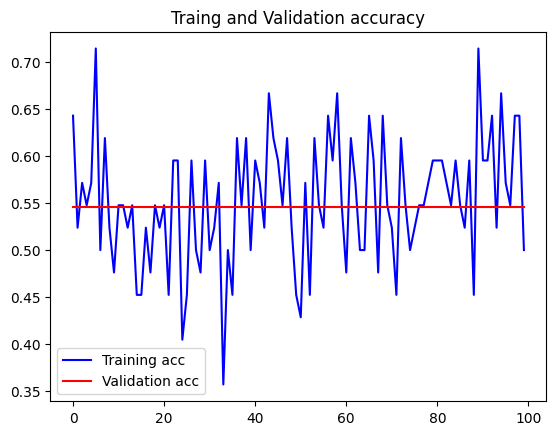

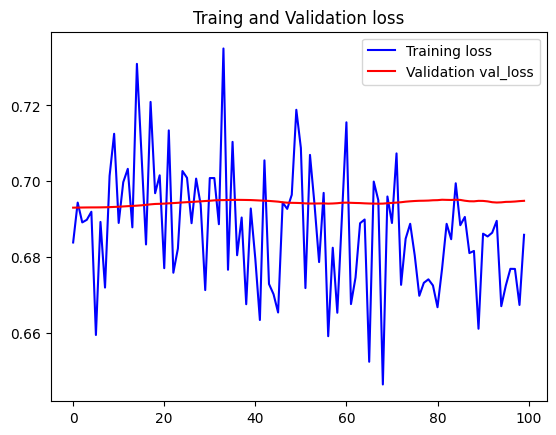

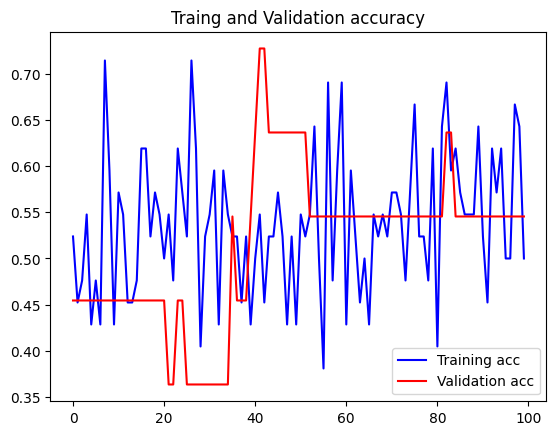

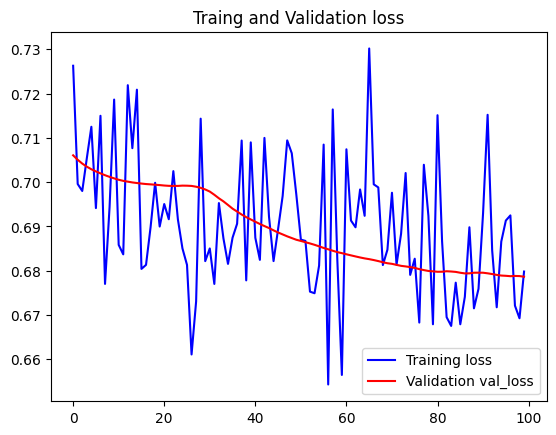

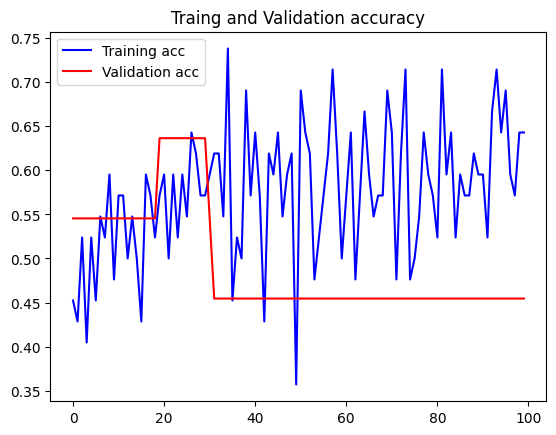

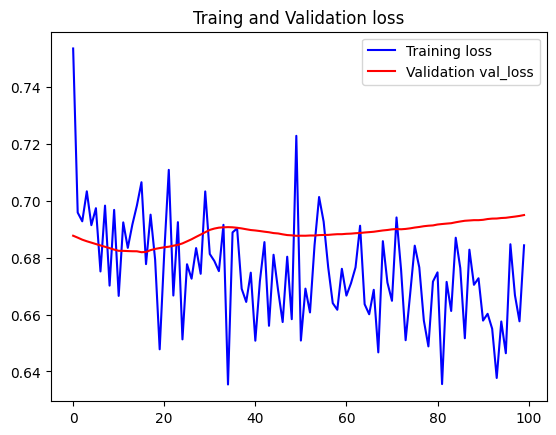

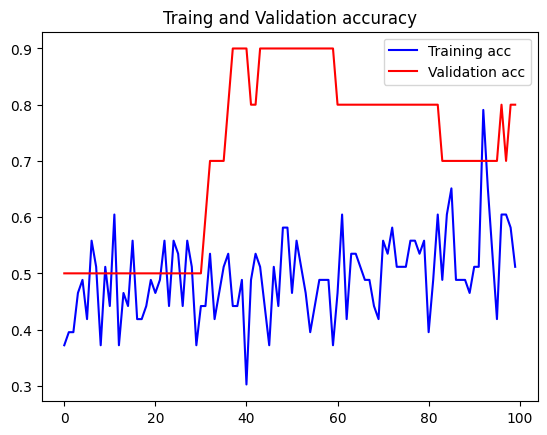

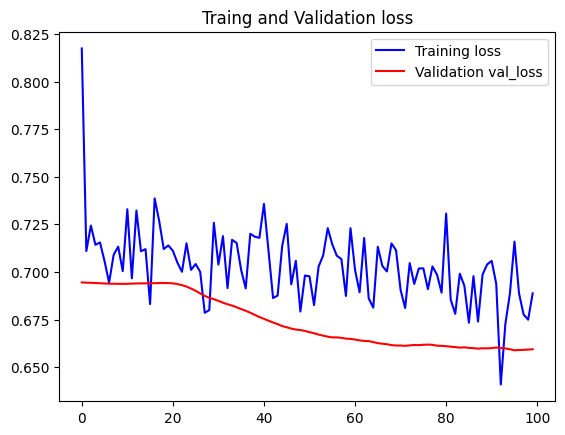

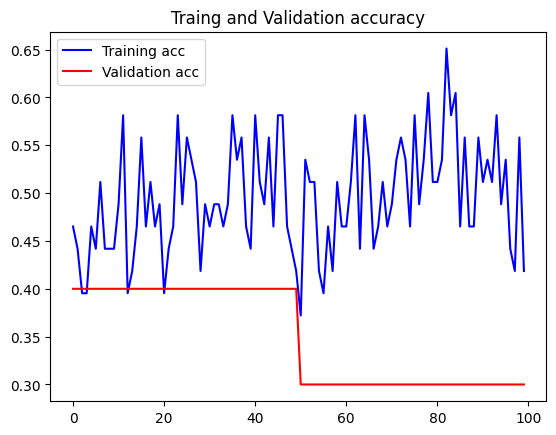

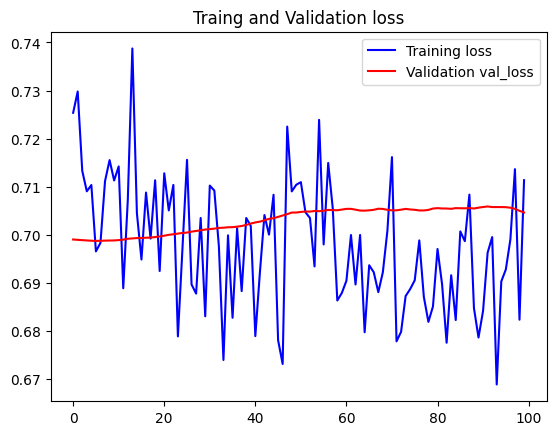

In [ ]:
#@title 128通道MODMA 训练OLD_EEGNET
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 6
# eegnet_x,eegnet_y均为128通道静息
# eegnet_x_3ch等为3通道
x = np.load('/content/drive/MyDrive/EEGNet_X.npy')
y = np.load('/content/drive/MyDrive/EEGNet_Y.npy')
# x = x.transpose(0,2,1) #三通道
x_alpha = x[:,:,:,0].transpose(0,2,1) #128通道
x = x_alpha
# x_alpha = x_alpha.reshape(-1,128,300,1) 128维度
# x.shape,y.shape
# x = x.reshape(-1,128)
y = to_categorical(y, num_classes)
print(x_alpha.shape)
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = OLD_EEGNet(nb_classes = 2, Chans = 128, Samples = 300, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.02)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  model = create_model(30)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

In [ ]:
#@title 数据 3通道MODMA读取 接下 
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

num_classes = 2
batch_size = 40
x = np.load('/content/drive/MyDrive/EEGNet_X_3ch_big.npy')
y = np.load('/content/drive/MyDrive/EEGNet_Y_3ch_big.npy')
y = to_categorical(y, num_classes)
x = x.transpose(0,2,1) #三通道


[0.5078558325767517, 0.5194085240364075, 0.5212569236755371, 0.5272642970085144, 0.5226432681083679, 0.5060073733329773, 0.5462107062339783, 0.5388169884681702, 0.5434380769729614, 0.5443623065948486, 0.5272642970085144, 0.5526801943778992, 0.5559149980545044, 0.5318853855133057, 0.5355822443962097, 0.5434380769729614, 0.5503696799278259, 0.543900191783905, 0.5429759621620178, 0.5318853855133057, 0.5559149980545044, 0.5494454503059387, 0.5517560243606567, 0.5651571154594421, 0.5314232707023621, 0.5434380769729614, 0.5351201295852661, 0.5383548736572266, 0.543900191783905, 0.55406653881073, 0.5646950006484985, 0.5291127562522888, 0.5522181391716003, 0.5332717299461365, 0.5434380769729614, 0.5619223713874817, 0.5471349358558655, 0.5471349358558655, 0.5462107062339783, 0.5184842944145203, 0.5526801943778992, 0.513863205909729, 0.5499075651168823, 0.543900191783905, 0.5637707710266113, 0.5304991006851196, 0.5374307036399841, 0.5448244214057922, 0.5286506414413452, 0.5485212802886963, 0.551

KeyboardInterrupt: ignored

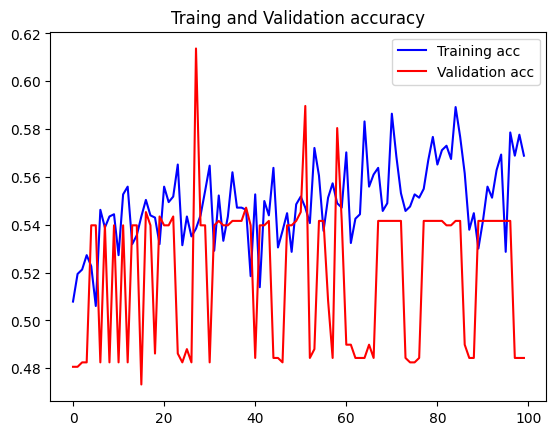

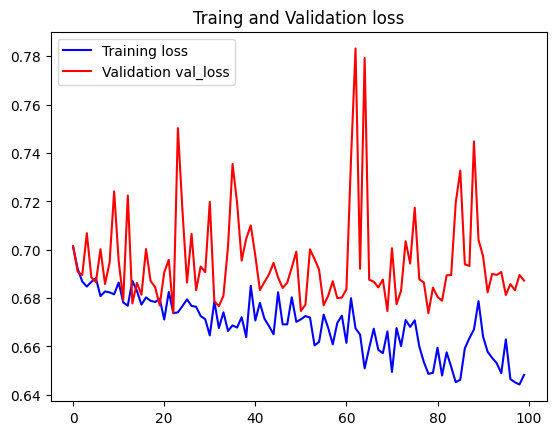

In [ ]:
#@title 3通道MODMA 训练New_EEGNet
seed = 19260817
batch_size = 40
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = Mid_EEGNet(nb_classes = 2, Chans = 3, Samples = 2000, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  model = create_model(250)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

[0.49768945574760437, 0.5134010910987854, 0.516173779964447, 0.5147874355316162, 0.5281885266304016, 0.5346580147743225, 0.5291127562522888, 0.5147874355316162, 0.527726411819458, 0.5175600647926331, 0.5203326940536499, 0.530036985874176, 0.5351201295852661, 0.5110905766487122, 0.5466728210449219, 0.5295748710632324, 0.540203332901001, 0.5397412180900574, 0.5457485914230347, 0.5462107062339783, 0.5254158973693848, 0.5392791032791138, 0.543900191783905, 0.5425138473510742, 0.5341959595680237, 0.5369685888290405, 0.5268022418022156, 0.5166358351707458, 0.5411275625228882, 0.5646950006484985, 0.5586876273155212, 0.5466728210449219, 0.5623844861984253, 0.5512939095497131, 0.5586876273155212, 0.5429759621620178, 0.5563770532608032, 0.5683918595314026, 0.5573012828826904, 0.5406654477119446, 0.5559149980545044, 0.5434380769729614, 0.5568391680717468, 0.5637707710266113, 0.5693160891532898, 0.5748613476753235, 0.5360443592071533, 0.5443623065948486, 0.5623844861984253, 0.5586876273155212, 0.5

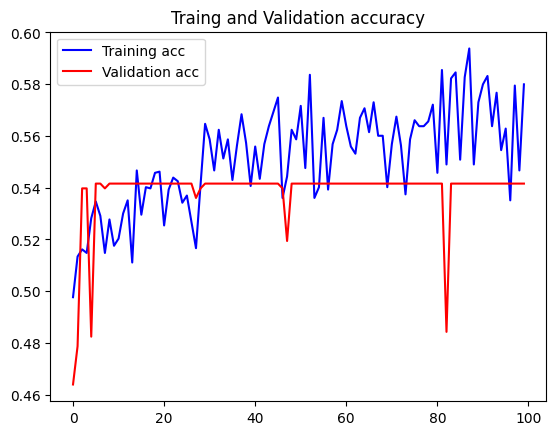

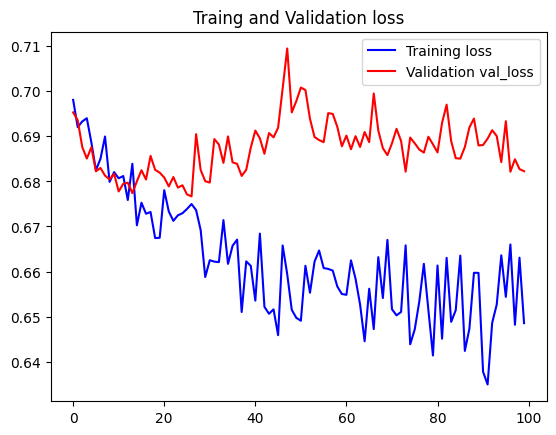

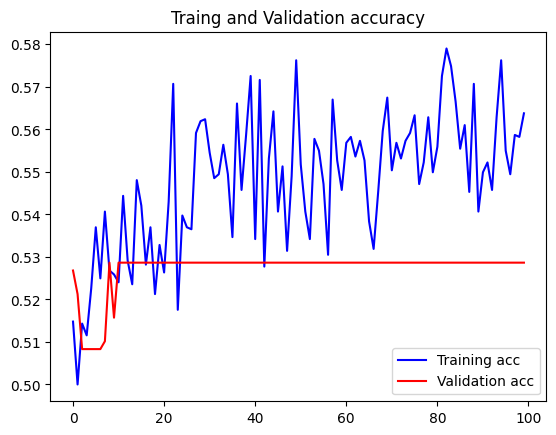

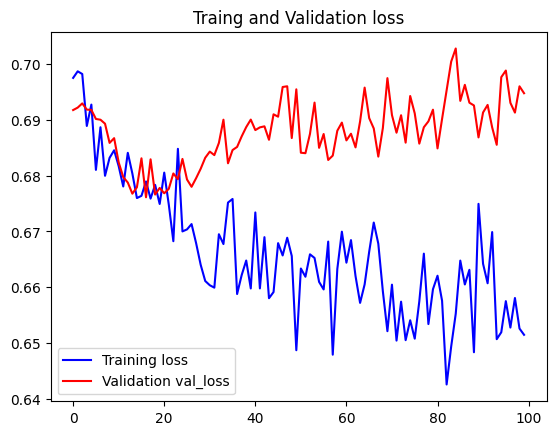

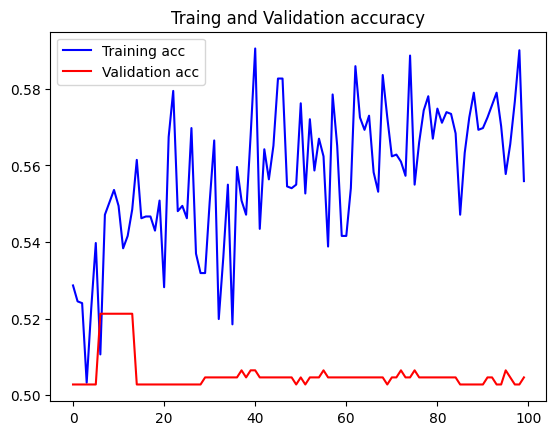

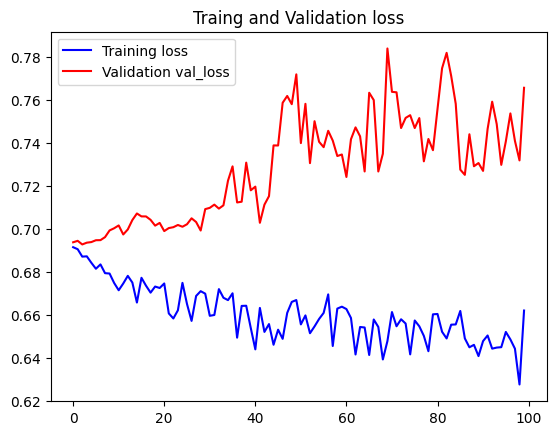

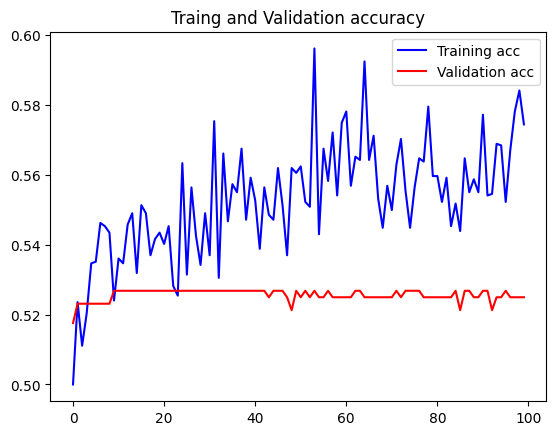

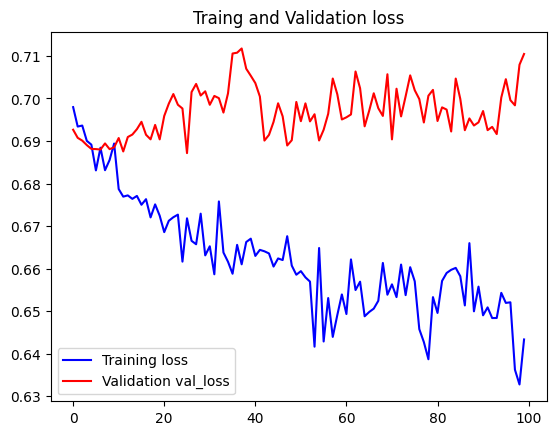

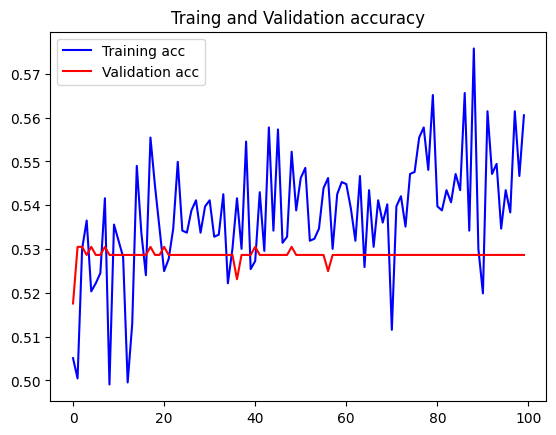

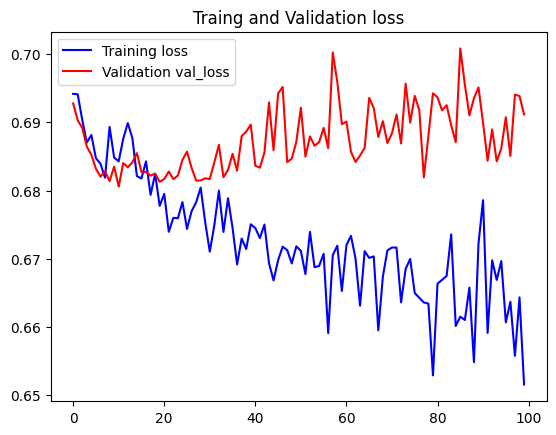

In [ ]:
#@title 3通道MODMA 训练OLD_EEGNet
seed = 19260817
batch_size = 40
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []
p = 0
def create_model(kernLength):
  model = OLD_EEGNet(nb_classes = 2, Chans = 3, Samples = 2000, 
                dropoutRate = 0.5, kernLength = kernLength, F1 = 4, D = 8, F2 = 8, 
                )
  adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,weight_decay = 0.01)
  model.compile(loss='categorical_crossentropy', optimizer=adam, 
              metrics = ['accuracy'])
  return model

for train, test in kfold.split(x, y.argmax(1)):

  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  model = create_model(250)
  p= p+1
  history = model.fit(x_train, y_train, epochs=100, batch_size=batch_size, verbose=0,validation_data = (x_test,y_test))
  epochs=range(len(history.history['accuracy']))
  plt.figure()
  plt.plot(epochs,history.history['accuracy'],'b',label='Training acc')
  plt.plot(epochs,history.history['val_accuracy'],'r',label='Validation acc')
  plt.title('Traing and Validation accuracy')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_acc.jpg')

  plt.figure()
  plt.plot(epochs,history.history['loss'],'b',label='Training loss')
  plt.plot(epochs,history.history['val_loss'],'r',label='Validation val_loss')
  plt.title('Traing and Validation loss')
  plt.legend()
  plt.savefig('/content/drive/MyDrive/model_V3.'+str(p)+'_loss.jpg')
  
  print(history.history['accuracy'])
  print("max ",max(history.history['val_accuracy'])) #128通道下 71.5% 73.96%
  max_acc.append(max(history.history['val_accuracy']))
  print(history.history['val_accuracy'])
  scores = history.history['val_accuracy'][-1]
  # scores = model.evaluate(x_test, y_test, verbose=0)

  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean max acc: {}".format(np.mean(max_acc)))
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))
acc_list.append(np.mean(all_acc))
std_list.append(np.std(all_acc))

In [ ]:
#@title 3通道MODMA 训练SVM
# from EEGModels import EEGNet
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

x = np.load('/content/drive/MyDrive/EEGNet_X_3ch_big.npy')
y = np.load('/content/drive/MyDrive/EEGNet_Y_3ch_big.npy')
x = x.transpose(0,2,1) #三通道
print("x shape ",x.shape)
x = x.reshape((x.shape[0], -1))
seed = 19260817
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
acc_list = []
std_list = []
all_acc = []
max_acc = []

for train, test in kfold.split(x, y):
  x_train = x[train]
  y_train = y[train]
  x_test = x[test]
  y_test = y[test]
  # clf = svm.SVC()
  # clf =  LogisticRegression()
  # clf =  DecisionTreeClassifier()
  clf =  RandomForestClassifier(n_estimators = 3)
  clf.fit(x_train, y_train)
  accuracy = clf.score(x_test, y_test)
  print("Model accuracy:", accuracy)
  scores = accuracy*100
  print("%.2f" % (scores)) # Accuracy
  all_acc.append(scores)
print("mean acc: {}".format(np.mean(all_acc)))
print("std acc: {}".format(np.std(all_acc)))

x shape  (2705, 3, 2000)
Model accuracy: 0.9020332717190388
90.20
Model accuracy: 0.9297597042513863
92.98
Model accuracy: 0.922365988909427
92.24
Model accuracy: 0.9316081330868762
93.16
Model accuracy: 0.9279112754158965
92.79
mean acc: 92.2735674676525
std acc: 1.0803430089613657
